### Imports

In [212]:
# Basic packages
import pandas as pd
import numpy as np
import datetime
import json
import time

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as scp

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, Binarizer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer

# Metrics
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, 
    classification_report, accuracy_score, f1_score, 
    make_scorer, r2_score, mean_absolute_error, 
    mean_squared_error
)

# Modeling - Classification
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import xgboost as XGBClassifier
from sklearn.svm import SVC

# Modeling - Regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as XGBRegressor

# Boosting
import xgboost as xgb
# import lightgbm as lgbm
# import catboost as cb

# Clustering packages
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
# from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.cm as cm
import scipy.cluster.hierarchy as shc

# Model selection and evaluation
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, cross_validate, GridSearchCV
from imblearn.pipeline import Pipeline

# Oversampling and undersampling techniques
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN, KMeansSMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks

# Dimensionality Reduction / Feature Selection
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Hyperparameter tuning
from scipy.stats import randint, uniform

# Utils
from statistics import mean
from collections import Counter
from numpy import polyfit

from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.cm as cm
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from IPython.display import display

### Helper functions

> Imputation

In [213]:
def impute_values(df, cols, strategy='auto'):
    """
    Impute missing values in specified columns of a DataFrame.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    cols (list): List of column names to impute
    strategy (str): Imputation strategy ('auto', 'mean', 'median', 'mode')
                  'auto' selects strategy based on column dtype
    
    Returns:
    pd.DataFrame: DataFrame with imputed values
    """
    df_copy = df.copy()
    
    for col in cols:
        if col not in df_copy.columns:
            raise ValueError(f"Column {col} not found in DataFrame")
            
        # Skip if no missing values
        if not df_copy[col].isna().any():
            continue
            
        # Determine imputation strategy
        if strategy == 'auto':
            if np.issubdtype(df_copy[col].dtype, np.number):
                col_strategy = 'mean'
            else:
                col_strategy = 'mode'
        else:
            col_strategy = strategy
            
        # Perform imputation
        if col_strategy == 'mean':
            if np.issubdtype(df_copy[col].dtype, np.number):
                df_copy[col] = df_copy[col].fillna(df_copy[col].mean())
            else:
                raise ValueError(f"Mean imputation not applicable for non-numeric column {col}")
        elif col_strategy == 'median':
            if np.issubdtype(df_copy[col].dtype, np.number):
                df_copy[col] = df_copy[col].fillna(df_copy[col].median())
            else:
                raise ValueError(f"Median imputation not applicable for non-numeric column {col}")
        elif col_strategy == 'mode':
            df_copy[col] = df_copy[col].fillna(df_copy[col].mode()[0])
        else:
            raise ValueError(f"Unsupported strategy: {strategy}")
    
    return df_copy

> Handling outliers

In [214]:
import pandas as pd
import numpy as np
from scipy import stats

def clip_outliers(df, cols, lower_percentile=0.05, upper_percentile=0.95, min_values=None):
    """
    Clip outliers in specified columns to percentile-based or custom thresholds.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    cols (list): List of numerical column names
    lower_percentile (float): Lower percentile for clipping (default: 0.05)
    upper_percentile (float): Upper percentile for clipping (default: 0.95)
    min_values (dict): Optional dictionary of column-specific minimum values (e.g., {'Age': 18})
    
    Returns:
    pd.DataFrame: DataFrame with clipped values
    """
    df_copy = df.copy()
    if min_values is None:
        min_values = {}
    
    for col in cols:
        if col not in df_copy.columns:
            raise ValueError(f"Column {col} not found in DataFrame")
        if not np.issubdtype(df_copy[col].dtype, np.number):
            raise ValueError(f"Column {col} must be numeric")
        
        # Calculate percentile-based thresholds
        lower = df_copy[col].quantile(lower_percentile)
        upper = df_copy[col].quantile(upper_percentile)
        
        # Apply column-specific minimum value if provided
        if col in min_values:
            lower = max(lower, min_values[col])
        
        # Clip values
        df_copy[col] = df_copy[col].clip(lower=lower, upper=upper)
    
    return df_copy

def winsorize_outliers(df, cols, lower_percentile=0.05, upper_percentile=0.95, min_values=None):
    """
    Winsorize outliers in specified columns by replacing with percentile-based values.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    cols (list): List of numerical column names
    lower_percentile (float): Lower percentile for winsorization (default: 0.05)
    upper_percentile (float): Upper percentile for winsorization (default: 0.95)
    min_values (dict): Optional dictionary of column-specific minimum values
    
    Returns:
    pd.DataFrame: DataFrame with winsorized values
    """
    df_copy = df.copy()
    if min_values is None:
        min_values = {}
    
    for col in cols:
        if col not in df_copy.columns:
            raise ValueError(f"Column {col} not found in DataFrame")
        if not np.issubdtype(df_copy[col].dtype, np.number):
            raise ValueError(f"Column {col} must be numeric")
        
        # Calculate percentile-based thresholds
        lower = df_copy[col].quantile(lower_percentile)
        upper = df_copy[col].quantile(upper_percentile)
        
        # Apply column-specific minimum value if provided
        if col in min_values:
            lower = max(lower, min_values[col])
        
        # Winsorize by replacing values
        df_copy[col] = np.where(df_copy[col] < lower, lower, df_copy[col])
        df_copy[col] = np.where(df_copy[col] > upper, upper, df_copy[col])
    
    return df_copy

def zscore_filter(df, cols, threshold=3, cap=True):
    """
    Handle outliers using z-score: cap or remove rows with z-scores beyond threshold.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    cols (list): List of numerical column names
    threshold (float): Z-score threshold for identifying outliers (default: 3)
    cap (bool): If True, cap outliers at threshold; if False, remove rows (default: True)
    
    Returns:
    pd.DataFrame: DataFrame with handled outliers
    """
    df_copy = df.copy()
    
    for col in cols:
        if col not in df_copy.columns:
            raise ValueError(f"Column {col} not found in DataFrame")
        if not np.issubdtype(df_copy[col].dtype, np.number):
            raise ValueError(f"Column {col} must be numeric")
        
        # Calculate z-scores
        z_scores = np.abs(stats.zscore(df_copy[col].dropna()))
        mask = z_scores <= threshold
        
        if cap:
            # Cap values at mean ± threshold * std
            mean = df_copy[col].mean()
            std = df_copy[col].std()
            lower = mean - threshold * std
            upper = mean + threshold * std
            df_copy[col] = df_copy[col].clip(lower=lower, upper=upper)
        else:
            # Remove rows with outliers
            df_copy = df_copy.loc[df_copy[col].index.isin(z_scores[mask].index)]
    
    return df_copy

def iqr_filter(df, cols, multiplier=1.5, cap=True):
    """
    Handle outliers using IQR: cap or remove rows with values outside Q1 - multiplier*IQR and Q3 + multiplier*IQR.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    cols (list): List of numerical column names
    multiplier (float): Multiplier for IQR to determine outlier bounds (default: 1.5)
    cap (bool): If True, cap outliers at bounds; if False, remove rows (default: True)
    
    Returns:
    pd.DataFrame: DataFrame with handled outliers
    """
    df_copy = df.copy()
    
    for col in cols:
        if col not in df_copy.columns:
            raise ValueError(f"Column {col} not found in DataFrame")
        if not np.issubdtype(df_copy[col].dtype, np.number):
            raise ValueError(f"Column {col} must be numeric")
        
        # Calculate IQR bounds
        Q1 = df_copy[col].quantile(0.25)
        Q3 = df_copy[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        
        if cap:
            # Cap values at bounds
            df_copy[col] = df_copy[col].clip(lower=lower_bound, upper=upper_bound)
        else:
            # Remove rows with outliers
            mask = (df_copy[col] >= lower_bound) & (df_copy[col] <= upper_bound)
            df_copy = df_copy[mask]
    
    return df_copy

def log_transform_outliers(df, cols):
    """
    Apply log1p transformation to reduce the impact of outliers in specified columns.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    cols (list): List of numerical column names
    
    Returns:
    pd.DataFrame: DataFrame with log-transformed values
    """
    df_copy = df.copy()
    
    for col in cols:
        if col not in df_copy.columns:
            raise ValueError(f"Column {col} not found in DataFrame")
        if not np.issubdtype(df_copy[col].dtype, np.number):
            raise ValueError(f"Column {col} must be numeric for log transformation")
        if df_copy[col].isna().any():
            raise ValueError(f"Column {col} contains missing values; impute them first")
        if (df_copy[col] < 0).any():
            raise ValueError(f"Column {col} contains negative values; ensure non-negative values")
        df_copy[col] = np.log1p(df_copy[col])
    
    return df_copy

def handle_outliers(df, cols, method='clip', **kwargs):
    """
    Apply specified outlier handling method to numerical columns.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    cols (list): List of numerical column names
    method (str): Outlier handling method ('clip', 'winsorize', 'zscore', 'iqr', 'log')
    **kwargs: Additional arguments for specific methods (e.g., lower_percentile, threshold)
    
    Returns:
    pd.DataFrame: DataFrame with handled outliers
    """
    method_map = {
        'clip': clip_outliers,
        'winsorize': winsorize_outliers,
        'zscore': zscore_filter,
        'iqr': iqr_filter,
        'log': log_transform_outliers
    }
    
    if method not in method_map:
        raise ValueError(f"Unsupported method: {method}. Choose from {list(method_map.keys())}")
    
    return method_map[method](df, cols, **kwargs)

def clean_data(df, numerical_cols):
    """
    Clean numerical columns by clipping invalid values without aggressive outlier handling.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    numerical_cols (list): List of numerical column names
    
    Returns:
    pd.DataFrame: Cleaned DataFrame
    """
    df_clean = df.copy()
    for col in ['DistanceFromHome', 'NumCompaniesWorked', 'TotalWorkingYears',
                'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']:
        if col in numerical_cols:
            df_clean[col] = df_clean[col].clip(lower=0)  # Ensure non-negative values
    df_clean['Age'] = df_clean['Age'].clip(lower=18)  # Minimum age 18
    if 'StandardHours' in df_clean.columns:
        df_clean = df_clean.drop('StandardHours', axis=1)  # Drop constant column
    return df_clean

> Scaling/Normalzation

In [215]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, PowerTransformer

def standard_scale(df, cols):
    """
    Apply z-score standardization to specified numeric columns.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    cols (list): List of column names to scale
    
    Returns:
    pd.DataFrame: DataFrame with standardized values
    """
    df_copy = df.copy()
    scaler = StandardScaler()
    
    for col in cols:
        if col not in df_copy.columns:
            raise ValueError(f"Column {col} not found in DataFrame")
        if not np.issubdtype(df_copy[col].dtype, np.number):
            raise ValueError(f"Column {col} must be numeric for scaling")
        df_copy[col] = scaler.fit_transform(df_copy[[col]].values.reshape(-1, 1)).flatten()
    
    return df_copy

def minmax_scale(df, cols, feature_range=(0, 1)):
    """
    Apply min-max normalization to specified numeric columns.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    cols (list): List of column names to scale
    feature_range (tuple): Desired range of transformed data (default: (0, 1))
    
    Returns:
    pd.DataFrame: DataFrame with normalized values
    """
    df_copy = df.copy()
    scaler = MinMaxScaler(feature_range=feature_range)
    
    for col in cols:
        if col not in df_copy.columns:
            raise ValueError(f"Column {col} not found in DataFrame")
        if not np.issubdtype(df_copy[col].dtype, np.number):
            raise ValueError(f"Column {col} must be numeric for scaling")
        df_copy[col] = scaler.fit_transform(df_copy[[col]].values.reshape(-1, 1)).flatten()
    
    return df_copy

def robust_scale(df, cols):
    """
    Apply robust scaling to specified numeric columns using median and IQR.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    cols (list): List of column names to scale
    
    Returns:
    pd.DataFrame: DataFrame with scaled values
    """
    df_copy = df.copy()
    scaler = RobustScaler()
    
    for col in cols:
        if col not in df_copy.columns:
            raise ValueError(f"Column {col} not found in DataFrame")
        if not np.issubdtype(df_copy[col].dtype, np.number):
            raise ValueError(f"Column {col} must be numeric for scaling")
        df_copy[col] = scaler.fit_transform(df_copy[[col]].values.reshape(-1, 1)).flatten()
    
    return df_copy

def maxabs_scale(df, cols):
    """
    Apply max-absolute scaling to specified numeric columns.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    cols (list): List of column names to scale
    
    Returns:
    pd.DataFrame: DataFrame with scaled values
    """
    df_copy = df.copy()
    scaler = MaxAbsScaler()
    
    for col in cols:
        if col not in df_copy.columns:
            raise ValueError(f"Column {col} not found in DataFrame")
        if not np.issubdtype(df_copy[col].dtype, np.number):
            raise ValueError(f"Column {col} must be numeric for scaling")
        df_copy[col] = scaler.fit_transform(df_copy[[col]].values.reshape(-1, 1)).flatten()
    
    return df_copy

def normalize_all(df, cols, method='standard'):
    """
    Apply specified normalization/standardization method to columns.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    cols (list): List of column names to normalize
    method (str): Scaling method ('standard', 'minmax', 'robust', 'maxabs')
    
    Returns:
    pd.DataFrame: DataFrame with normalized values
    """
    method_map = {
        'standard': standard_scale,
        'minmax': minmax_scale,
        'robust': robust_scale,
        'maxabs': maxabs_scale
    }
    
    if method not in method_map:
        raise ValueError(f"Unsupported method: {method}. Choose from {list(method_map.keys())}")
    
    return method_map[method](df, cols)

def yeo_johnson_transform(df, cols):
    """
    Apply Yeo-Johnson transformation to specified numeric columns.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    cols (list): List of column names to transform
    
    Returns:
    pd.DataFrame: DataFrame with transformed values
    """
    df_copy = df.copy()
    transformer = PowerTransformer(method='yeo-johnson', standardize=True)
    
    for col in cols:
        if col not in df_copy.columns:
            raise ValueError(f"Column {col} not found in DataFrame")
        if not np.issubdtype(df_copy[col].dtype, np.number):
            raise ValueError(f"Column {col} must be numeric for Yeo-Johnson transformation")
        if df_copy[col].isna().any():
            raise ValueError(f"Column {col} contains missing values; impute them first")
        
        # Apply transformation
        df_copy[col] = transformer.fit_transform(df_copy[[col]].values.reshape(-1, 1)).flatten()
    
    return df_copy

def box_cox_transform(df, cols):
    """
    Apply Box-Cox transformation to specified numeric columns.
    Note: Box-Cox requires strictly positive values.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    cols (list): List of column names to transform
    
    Returns:
    pd.DataFrame: DataFrame with transformed values
    """
    df_copy = df.copy()
    transformer = PowerTransformer(method='box-cox', standardize=True)
    
    for col in cols:
        if col not in df_copy.columns:
            raise ValueError(f"Column {col} not found in DataFrame")
        if not np.issubdtype(df_copy[col].dtype, np.number):
            raise ValueError(f"Column {col} must be numeric for Box-Cox transformation")
        if df_copy[col].isna().any():
            raise ValueError(f"Column {col} contains missing values; impute them first")
        if (df_copy[col] <= 0).any():
            raise ValueError(f"Column {col} contains non-positive values; Box-Cox requires strictly positive values")
        
        # Apply transformation
        df_copy[col] = transformer.fit_transform(df_copy[[col]].values.reshape(-1, 1)).flatten()
    
    return df_copy

def power_transform(df, cols, method='yeo-johnson'):
    """
    Apply specified power transformation (Yeo-Johnson or Box-Cox) to columns.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    cols (list): List of column names to transform
    method (str): Transformation method ('yeo-johnson', 'box-cox')
    
    Returns:
    pd.DataFrame: DataFrame with transformed values
    """
    method_map = {
        'yeo-johnson': yeo_johnson_transform,
        'box-cox': box_cox_transform
    }
    
    if method not in method_map:
        raise ValueError(f"Unsupported method: {method}. Choose from {list(method_map.keys())}")
    
    return method_map[method](df, cols)

import pandas as pd
import numpy as np

def log_transform(df, cols):
    """
    Apply log1p (log(1+x)) transformation to specified numeric columns.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    cols (list): List of column names to transform
    
    Returns:
    pd.DataFrame: DataFrame with log-transformed values
    """
    df_copy = df.copy()
    
    for col in cols:
        if col not in df_copy.columns:
            raise ValueError(f"Column {col} not found in DataFrame")
        if not np.issubdtype(df_copy[col].dtype, np.number):
            raise ValueError(f"Column {col} must be numeric for log transformation")
        if df_copy[col].isna().any():
            raise ValueError(f"Column {col} contains missing values; impute them first")
        if (df_copy[col] < 0).any():
            raise ValueError(f"Column {col} contains negative values; log transformation requires non-negative values")
        
        # Apply log1p transformation
        df_copy[col] = np.log1p(df_copy[col])
    
    return df_copy

def robust_scale(df, cols):
    """
    Apply RobustScaler to specified numerical columns.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    cols (list): List of numerical column names
    
    Returns:
    pd.DataFrame: DataFrame with scaled columns
    """
    df_copy = df.copy()
    scaler = RobustScaler()
    for col in cols:
        if col not in df_copy.columns:
            raise ValueError(f"Column {col} not found in DataFrame")
        if not np.issubdtype(df_copy[col].dtype, np.number):
            raise ValueError(f"Column {col} must be numeric for scaling")
        df_copy[col] = scaler.fit_transform(df_copy[[col]].values.reshape(-1, 1)).flatten()
    return df_copy

>  Get unique values

In [216]:
import pandas as pd

def get_unique_values(df):
    """
    Get unique values for each column in a DataFrame.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    
    Returns:
    dict: Dictionary with column names as keys and lists of unique values as values
    """
    unique_values = {}
    for col in df.columns:
        unique_values[col] = df[col].dropna().unique().tolist()
    
    return unique_values

> Encoding

In [217]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def label_encode(df, cols, mappings=None):
    """
    Apply label encoding to specified ordinal columns with optional custom mappings.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    cols (list): List of column names to encode
    mappings (dict): Optional dictionary of column names to ordered value lists
    
    Returns:
    pd.DataFrame: DataFrame with label-encoded columns
    dict: Dictionary of encoders used
    """
    df_copy = df.copy()
    encoders = {}
    
    # Default mappings for ordinal columns
    default_mappings = {
        'Education': ['Below College', 'College', 'Bachelor', 'Master', 'Doctor'],
        'EnvironmentSatisfaction': ['Low', 'Medium', 'High', 'Very High'],
        'JobInvolvement': ['Low', 'Medium', 'High', 'Very High'],
        'JobSatisfaction': ['Low', 'Medium', 'High', 'Very High'],
        'PerformanceRating': ['Good', 'Excellent', 'Outstanding'],
        'RelationshipSatisfaction': ['Low', 'Medium', 'High', 'Very High'],
        'WorkLifeBalance': ['Bad', 'Better', 'Good', 'Best'],
        'JobLevel': [0, 1, 2, 3, 4, 5],
        'StockOptionLevel': [0, 1, 2, 3, 4]
    }
    
    # Update mappings with user-provided ones, if any
    if mappings:
        default_mappings.update(mappings)
    
    for col in cols:
        if col not in df_copy.columns:
            raise ValueError(f"Column {col} not found in DataFrame")
        
        # Use custom mapping if available, otherwise use LabelEncoder
        if col in default_mappings:
            mapping = {val: idx for idx, val in enumerate(default_mappings[col])}
            df_copy[col] = df_copy[col].map(mapping)
            encoders[col] = mapping
        else:
            le = LabelEncoder()
            df_copy[col] = le.fit_transform(df_copy[col].astype(str))
            encoders[col] = le
    
    return df_copy, encoders

def one_hot_encode(df, cols):
    """
    Apply one-hot encoding to specified non-ordinal columns.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    cols (list): List of column names to encode
    
    Returns:
    pd.DataFrame: DataFrame with one-hot encoded columns
    dict: Dictionary of encoders used
    """
    df_copy = df.copy()
    encoders = {}
    
    for col in cols:
        if col not in df_copy.columns:
            raise ValueError(f"Column {col} not found in DataFrame")
        
        ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        # Fit and transform the column
        encoded = ohe.fit_transform(df_copy[[col]].astype(str))
        # Create new column names
        new_cols = [f"{col}_{cat}" for cat in ohe.categories_[0]]
        # Add encoded columns to DataFrame
        df_copy = pd.concat([df_copy, pd.DataFrame(encoded, columns=new_cols, index=df_copy.index)], axis=1)
        # Drop original column
        df_copy = df_copy.drop(col, axis=1)
        encoders[col] = ohe
    
    return df_copy, encoders

def encode_categorical(df, ordinal_cols, non_ordinal_cols, mappings=None):
    """
    Apply label encoding to ordinal columns and one-hot encoding to non-ordinal columns.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    ordinal_cols (list): List of ordinal column names
    non_ordinal_cols (list): List of non-ordinal column names
    mappings (dict): Optional dictionary of column names to ordered value lists
    
    Returns:
    pd.DataFrame: DataFrame with encoded columns
    dict: Dictionary of all encoders used
    """
    df_encoded = df.copy()
    all_encoders = {}
    
    # Apply label encoding to ordinal columns
    if ordinal_cols:
        df_encoded, label_encoders = label_encode(df_encoded, ordinal_cols, mappings)
        all_encoders.update(label_encoders)
    
    # Apply one-hot encoding to non-ordinal columns
    if non_ordinal_cols:
        df_encoded, ohe_encoders = one_hot_encode(df_encoded, non_ordinal_cols)
        all_encoders.update(ohe_encoders)
    
    return df_encoded, all_encoders
 

> Visualizations

In [218]:
def plot_kde_histograms(df, continuous_cols):
    """Plots KDE and histogram plots for continuous features."""
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))
    axes = axes.flatten()
    for ax, col in zip(axes, continuous_cols):
        if col == 'MonthlyIncome':
            sns.kdeplot(df[col].dropna(), ax=ax, fill=True)
        else:
            sns.histplot(df[col].dropna(), ax=ax, kde=True, bins=30, stat="density", alpha=0.5)
        ax.set_title(f'KDE Plot: {col}')
    plt.tight_layout()
    plt.show()

def plot_box_plots(df, cols):
    """Plots box plots for discrete features."""
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))
    axes = axes.flatten()
    for ax, col in zip(axes, cols):
        sns.boxplot(x=df[col].dropna(), ax=ax)
        ax.set_title(f'Box Plot: {col}')
    plt.tight_layout()
    plt.show()

def plot_bar_charts(df, discrete_cols):
    """Plots bar charts (count plots) for discrete features."""
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))
    axes = axes.flatten()
    for ax, col in zip(axes, discrete_cols):
        sns.countplot(x=df[col].dropna(), ax=ax)
        ax.set_title(f'Bar Chart: {col}')
    plt.tight_layout()
    plt.show()

def plot_bar_plots_mean(df, discrete_cols, target_col='MonthlyIncome'):
    """Plots bar plots showing the mean of the target variable for discrete features."""
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))
    axes = axes.flatten()
    for ax, col in zip(axes, discrete_cols):
        sns.barplot(x=df[col], y=df[target_col], ax=ax, estimator=np.mean)
        ax.set_title(f'Bar Plot: {col} vs {target_col}')
    plt.tight_layout()
    plt.show()

def show_corr(df, cols):
    # Only use numerical columns
    corr = df[cols].corr()
    plt.figure(figsize=(12,8))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')

def create_categorical_pie_charts(df, categorical_cols):
    """
    Create pie charts for each categorical column in the dataset.
    
    Parameters:
    df (pandas.DataFrame): The dataframe containing the data
    categorical_cols (list): List of categorical column names
    """
    # Calculate number of rows and columns for the subplot grid
    n_cols = 3
    n_rows = (len(categorical_cols) + n_cols - 1) // n_cols
    
    # Create the figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    axes = axes.flatten()
    
    # Set a style
    sns.set_style("whitegrid")
    
    # Create a pie chart for each categorical column
    for i, col in enumerate(categorical_cols):
        # Get value counts and calculate percentages
        print(col)
        value_counts = df[col].value_counts()
        print(f"value counts: {value_counts}")
        
        # Plot the pie chart
        wedges, texts, autotexts = axes[i].pie(
            value_counts, 
            labels=None,  # No labels on the pie itself
            autopct='%1.1f%%',
            startangle=90,
            textprops={'fontsize': 9},
            colors=sns.color_palette('pastel', len(value_counts))
        )
        
        # Title with column name
        axes[i].set_title(col, fontsize=12, pad=10)
        
        # Add a legend
        legend_labels = [f"{k} ({v})" for k, v in value_counts.items()]
        axes[i].legend(wedges, legend_labels, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=8)
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.4)
    return fig

### EDA

Apakah karyawan yang memiliki jumlah pelatihan di atas rata-rata cenderung memiliki tingkat pengunduran diri yang lebih tinggi?

In [219]:
df = pd.read_csv('employee_train.csv')

In [220]:
df.columns

Index(['ID', 'Age', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'MonthlyIncome',
       'Attrition'],
      dtype='object')

In [221]:
df['WorkLifeBalance']

0         Good
1         Good
2          Bad
3       Better
4         Good
         ...  
9073      Good
9074      Good
9075      Good
9076      Good
9077    Better
Name: WorkLifeBalance, Length: 9078, dtype: object

Average TrainingTimesLastYear: 2.49


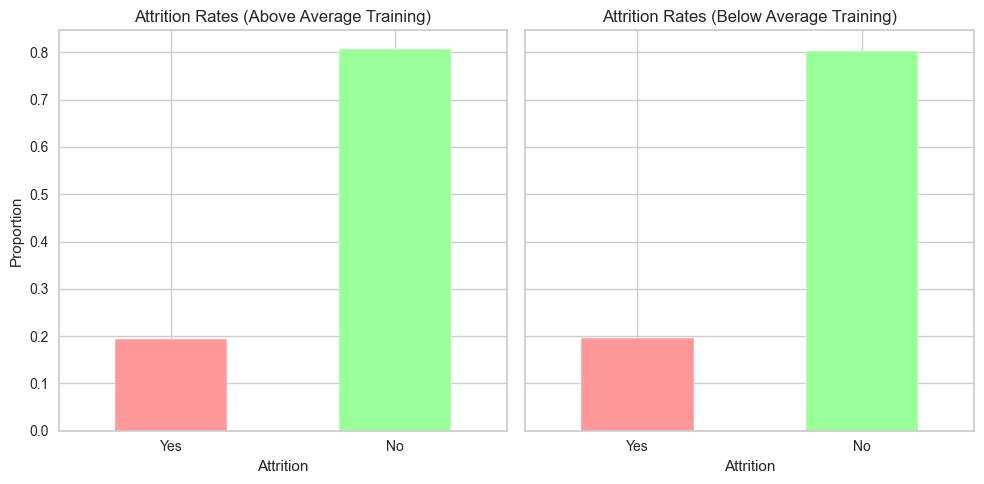


Attrition Rates (Above Average):
Yes    0.193899
No     0.806101
dtype: float64

Attrition Rates (Below Average):
Yes    0.196737
No     0.803263
dtype: float64


In [222]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the average TrainingTimesLastYear
avg_training = df['TrainingTimesLastYear'].mean()
print(f"Average TrainingTimesLastYear: {avg_training:.2f}")

# Split data into above and below average training
df_above_avg = df[df['TrainingTimesLastYear'] > avg_training]
df_below_avg = df[df['TrainingTimesLastYear'] <= avg_training]

# Calculate the proportion of Attrition Yes and No for each group
def calculate_attrition_rates(df_group):
    yes_rate = df_group['Attrition'].value_counts(normalize=True).get('Yes', 0)
    no_rate = df_group['Attrition'].value_counts(normalize=True).get('No', 0)
    return pd.Series({'Yes': yes_rate, 'No': no_rate})

attrition_above = calculate_attrition_rates(df_above_avg)
attrition_below = calculate_attrition_rates(df_below_avg)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Plot for Above Average
attrition_above.plot(kind='bar', ax=ax1, color=['#FF9999', '#99FF99'])
ax1.set_title('Attrition Rates (Above Average Training)')
ax1.set_xlabel('Attrition')
ax1.set_ylabel('Proportion')
ax1.set_xticklabels(attrition_above.index, rotation=0)

# Plot for Below Average
attrition_below.plot(kind='bar', ax=ax2, color=['#FF9999', '#99FF99'])
ax2.set_title('Attrition Rates (Below Average Training)')
ax2.set_xlabel('Attrition')
ax2.set_xticklabels(attrition_below.index, rotation=0)

# Adjust layout
plt.tight_layout()
plt.show()

# Print the rates for reference
print("\nAttrition Rates (Above Average):")
print(attrition_above)
print("\nAttrition Rates (Below Average):")
print(attrition_below)

Terlihat bahwa karyawan dengan jumlah pelatihan di atas rata-rata yang mengundurkan diri proporsinya tidak jauh berbeda dibandingkan karyawan dengan jumlah pelatihan di bawa rata-rata yang mengundurkan diri. Hal ini menunjukkan bahwa dugaan karyawan dengan tingkat pelatihan lebih tinggi memiliki tingkat pengunduran diri yang lebih tinggi tidak benar.

Apakah Work-Life Balance yang baik berkorelasi dengan tingkat kepuasan kerja yang tinggi?

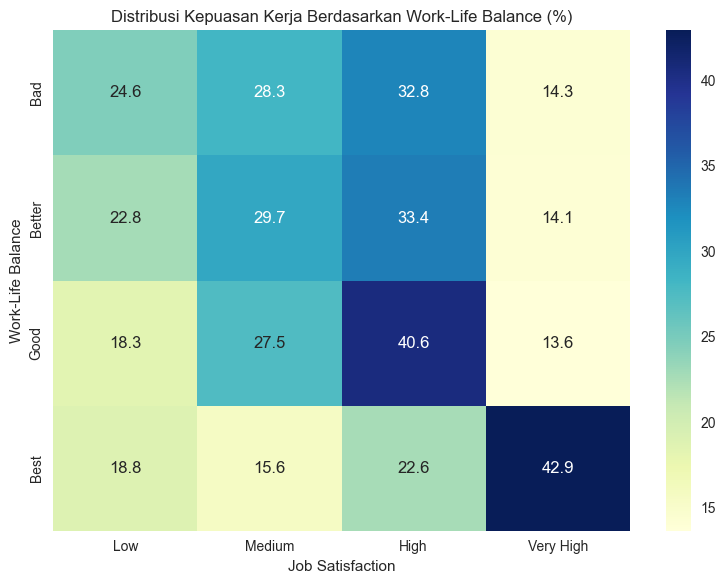

In [223]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Salin data untuk keperluan visualisasi
df_viz = df.copy()

# Pastikan kolom berupa kategorikal berurutan
wlb_order = ['Bad', 'Better', 'Good', 'Best']
satisfaction_order = ['Low', 'Medium', 'High', 'Very High']

# Hitung jumlah karyawan dalam setiap kombinasi WLB dan JobSatisfaction
heatmap_data = pd.crosstab(df_viz['WorkLifeBalance'], df_viz['JobSatisfaction'], normalize='index') * 100

# Urutkan
heatmap_data = heatmap_data.loc[wlb_order, satisfaction_order]

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".1f")
plt.title('Distribusi Kepuasan Kerja Berdasarkan Work-Life Balance (%)')
plt.xlabel('Job Satisfaction')
plt.ylabel('Work-Life Balance')
plt.tight_layout()
plt.show()


C:\Users\Fikri Budianto\AppData\Local\Temp\ipykernel_13864\1402601544.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_satisfaction.index, y=avg_satisfaction.values, palette='Blues_d')


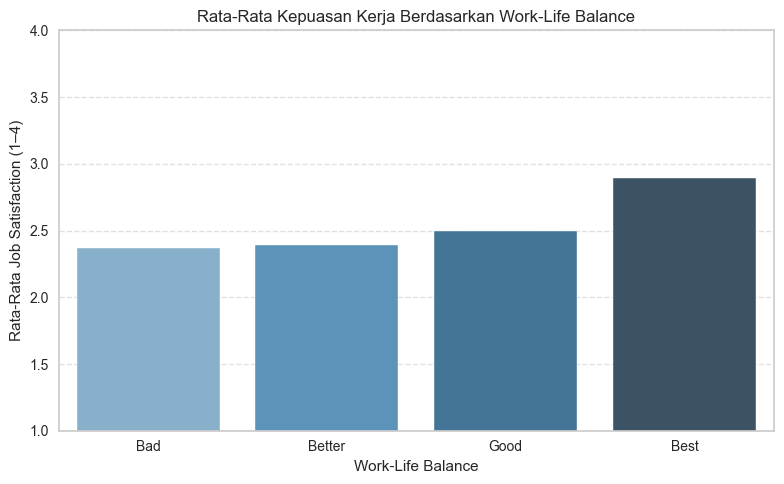

In [224]:
# Buat mapping angka untuk tingkat kepuasan kerja
satisfaction_mapping = {
    'Low': 1,
    'Medium': 2,
    'High': 3,
    'Very High': 4
}
df_viz['JobSatisfactionNum'] = df_viz['JobSatisfaction'].map(satisfaction_mapping)

# Hitung rata-rata Job Satisfaction per Work-Life Balance
avg_satisfaction = df_viz.groupby('WorkLifeBalance')['JobSatisfactionNum'].mean().reindex(wlb_order)

# Plot bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=avg_satisfaction.index, y=avg_satisfaction.values, palette='Blues_d')
plt.title('Rata-Rata Kepuasan Kerja Berdasarkan Work-Life Balance')
plt.xlabel('Work-Life Balance')
plt.ylabel('Rata-Rata Job Satisfaction (1–4)')
plt.ylim(1, 4)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Berdasarkan heatmap, terlihat bahwa semakin tinggi work-life balance seseorang maka semakin tinggi juga tingkat kepuasan kerjanya. Selain itu, berdasarkan bar plot, semakin tinggi work-life balance maka nilai rata-rata kepuasan kerjanya juga meningkat. Kedua visualisasi ini menunjukkan bahwa work-life balance yang baik berkorelasi dengan tingkat kepuasan kerja.

### Stats

In [225]:
import pandas as pd

df = pd.read_csv('employee_train.csv')

In [226]:
# Get categorical cols
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print("Categorical cols:")
print(categorical_cols)

# Get numerical cols (should use 'number' instead)
numerical_cols = df.select_dtypes(include=['number']).columns
print("\nNumerical cols:")
print(numerical_cols)

Categorical cols:
Index(['ID', 'BusinessTravel', 'Department', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobRole',
       'JobSatisfaction', 'MaritalStatus', 'OverTime', 'PerformanceRating',
       'RelationshipSatisfaction', 'WorkLifeBalance', 'Attrition'],
      dtype='object')

Numerical cols:
Index(['Age', 'DistanceFromHome', 'JobLevel', 'NumCompaniesWorked',
       'PercentSalaryHike', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'MonthlyIncome'],
      dtype='object')


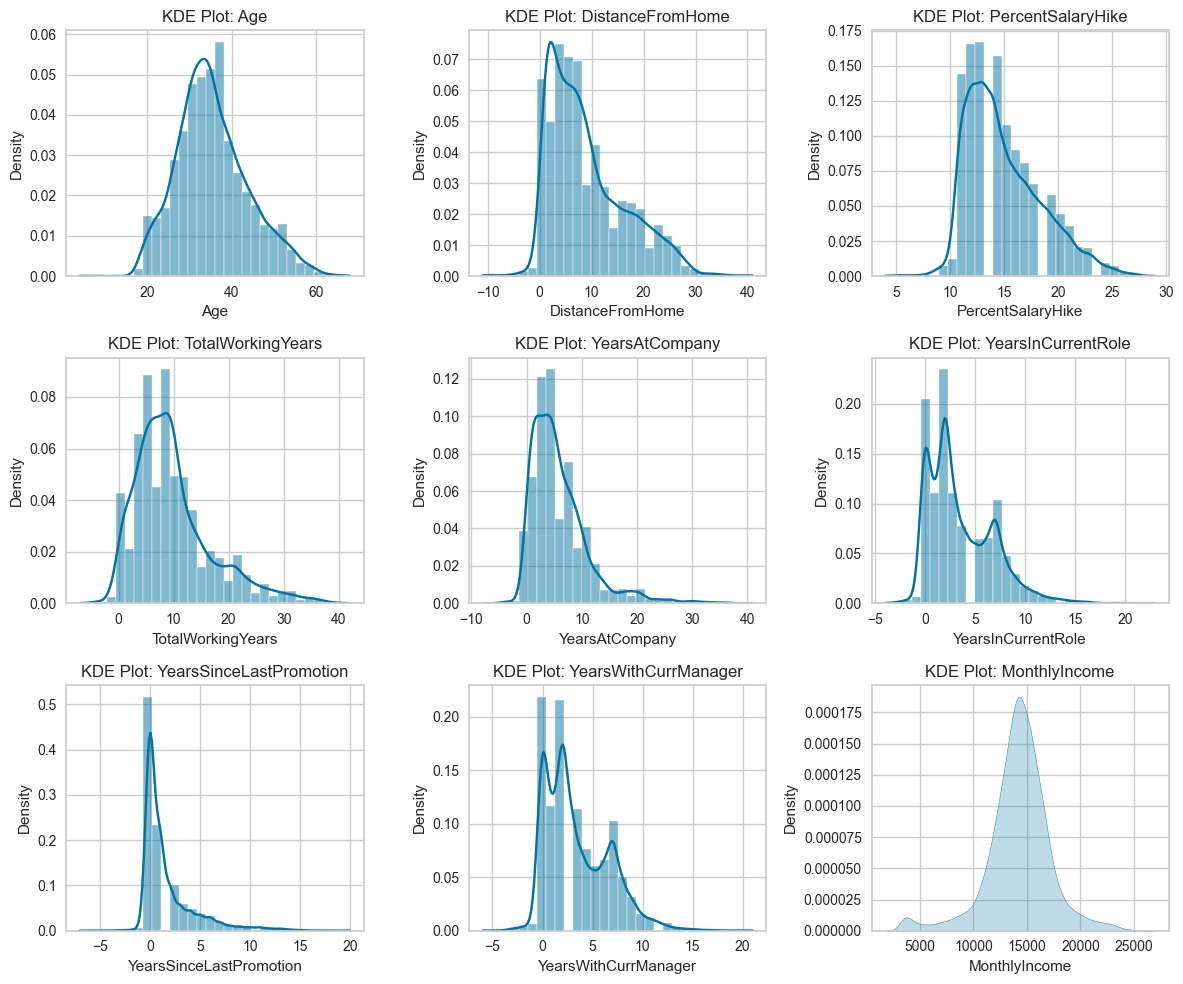

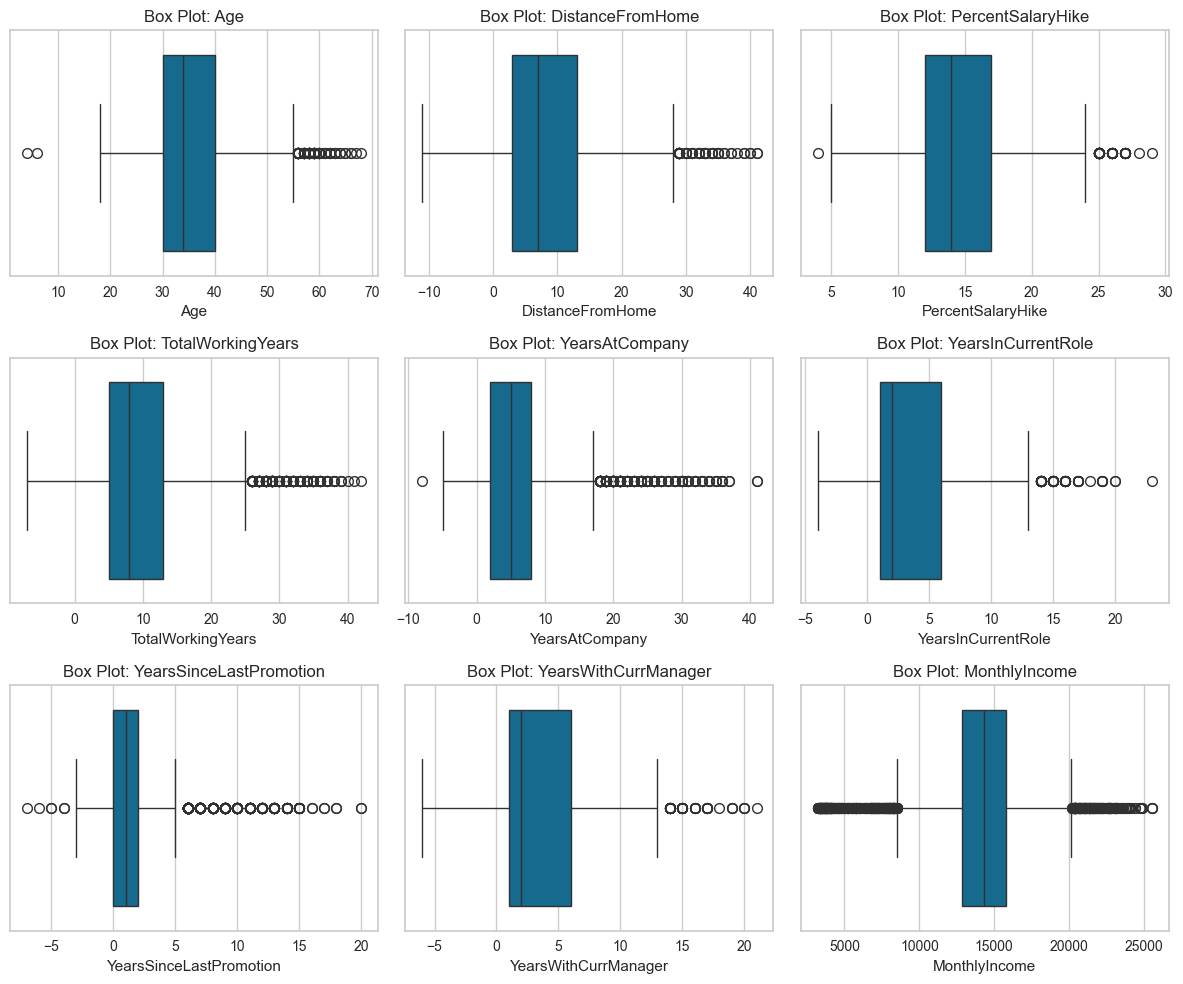

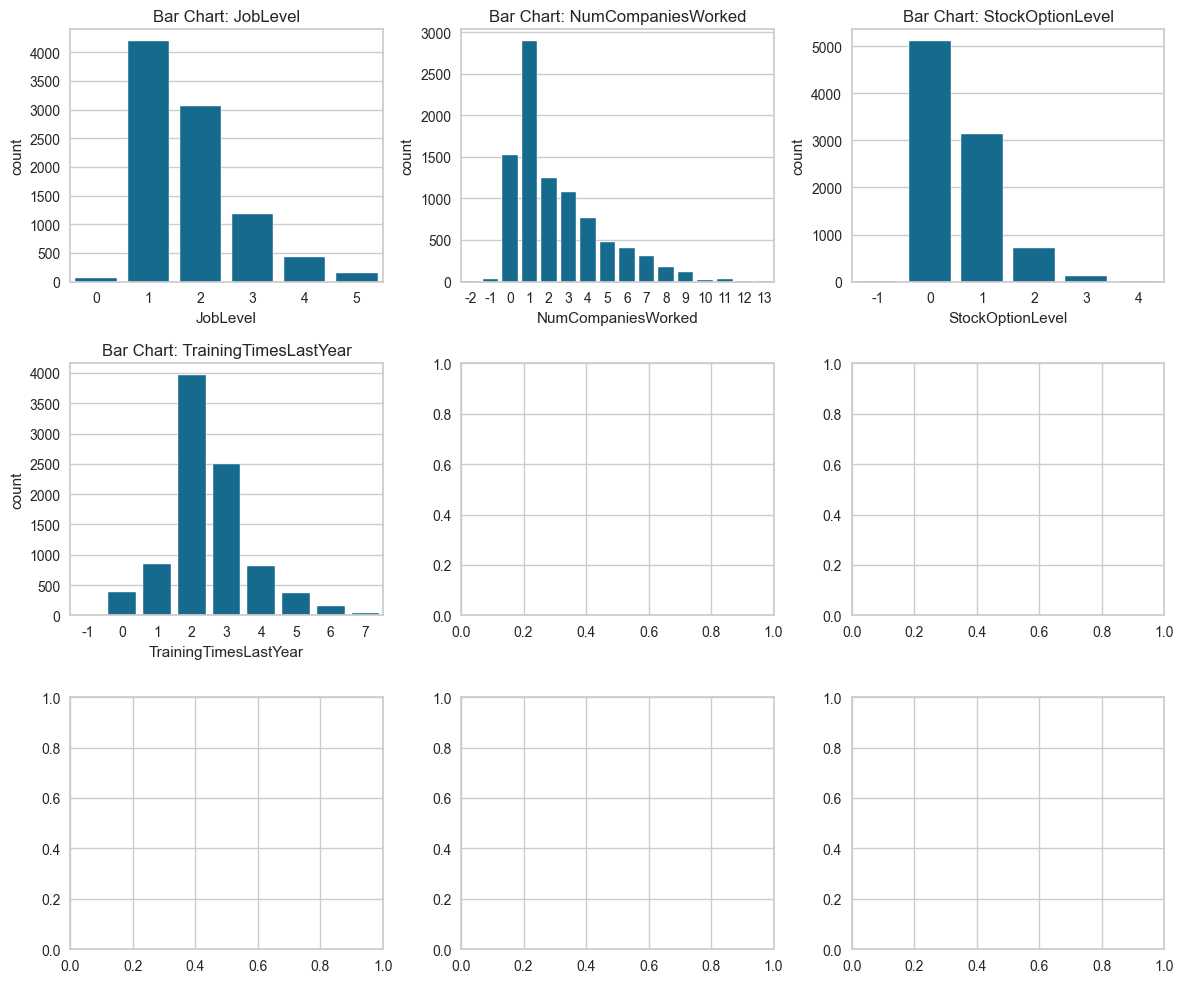

In [227]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Define continuous and discrete columns
continuous_cols = ['Age', 'DistanceFromHome', 'PercentSalaryHike', 'TotalWorkingYears', 
                   'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 
                   'YearsWithCurrManager', 'MonthlyIncome']

discrete_cols = ['JobLevel', 'NumCompaniesWorked', 'StockOptionLevel', 'TrainingTimesLastYear']

# Call the functions with df
plot_kde_histograms(df, continuous_cols)
plot_box_plots(df, continuous_cols)
# plot_box_plots(df, discrete_cols)
plot_bar_charts(df, discrete_cols)
# plot_bar_plots_mean(df, discrete_cols, target_col='MonthlyIncome')

BusinessTravel
value counts: BusinessTravel
Travel_Rarely        4982
Travel_Frequently    2942
Non-Travel           1154
Name: count, dtype: int64
Department
value counts: Department
Research & Development    5542
Sales                     1351
Human Resources            676
Name: count, dtype: int64
Education
value counts: Education
Bachelor         3232
College          2013
Master           1066
Below College    1033
Doctor             66
Name: count, dtype: int64
EducationField
value counts: EducationField
Life Sciences       3128
Medical             1839
Marketing           1719
Other                575
Human Resources      408
Technical Degree     308
Name: count, dtype: int64
EnvironmentSatisfaction
value counts: EnvironmentSatisfaction
High         2586
Medium       2109
Low          1612
Very High    1115
Name: count, dtype: int64
Gender
value counts: Gender
Male      4871
Female    3664
Name: count, dtype: int64
JobInvolvement
value counts: JobInvolvement
High         4391
M

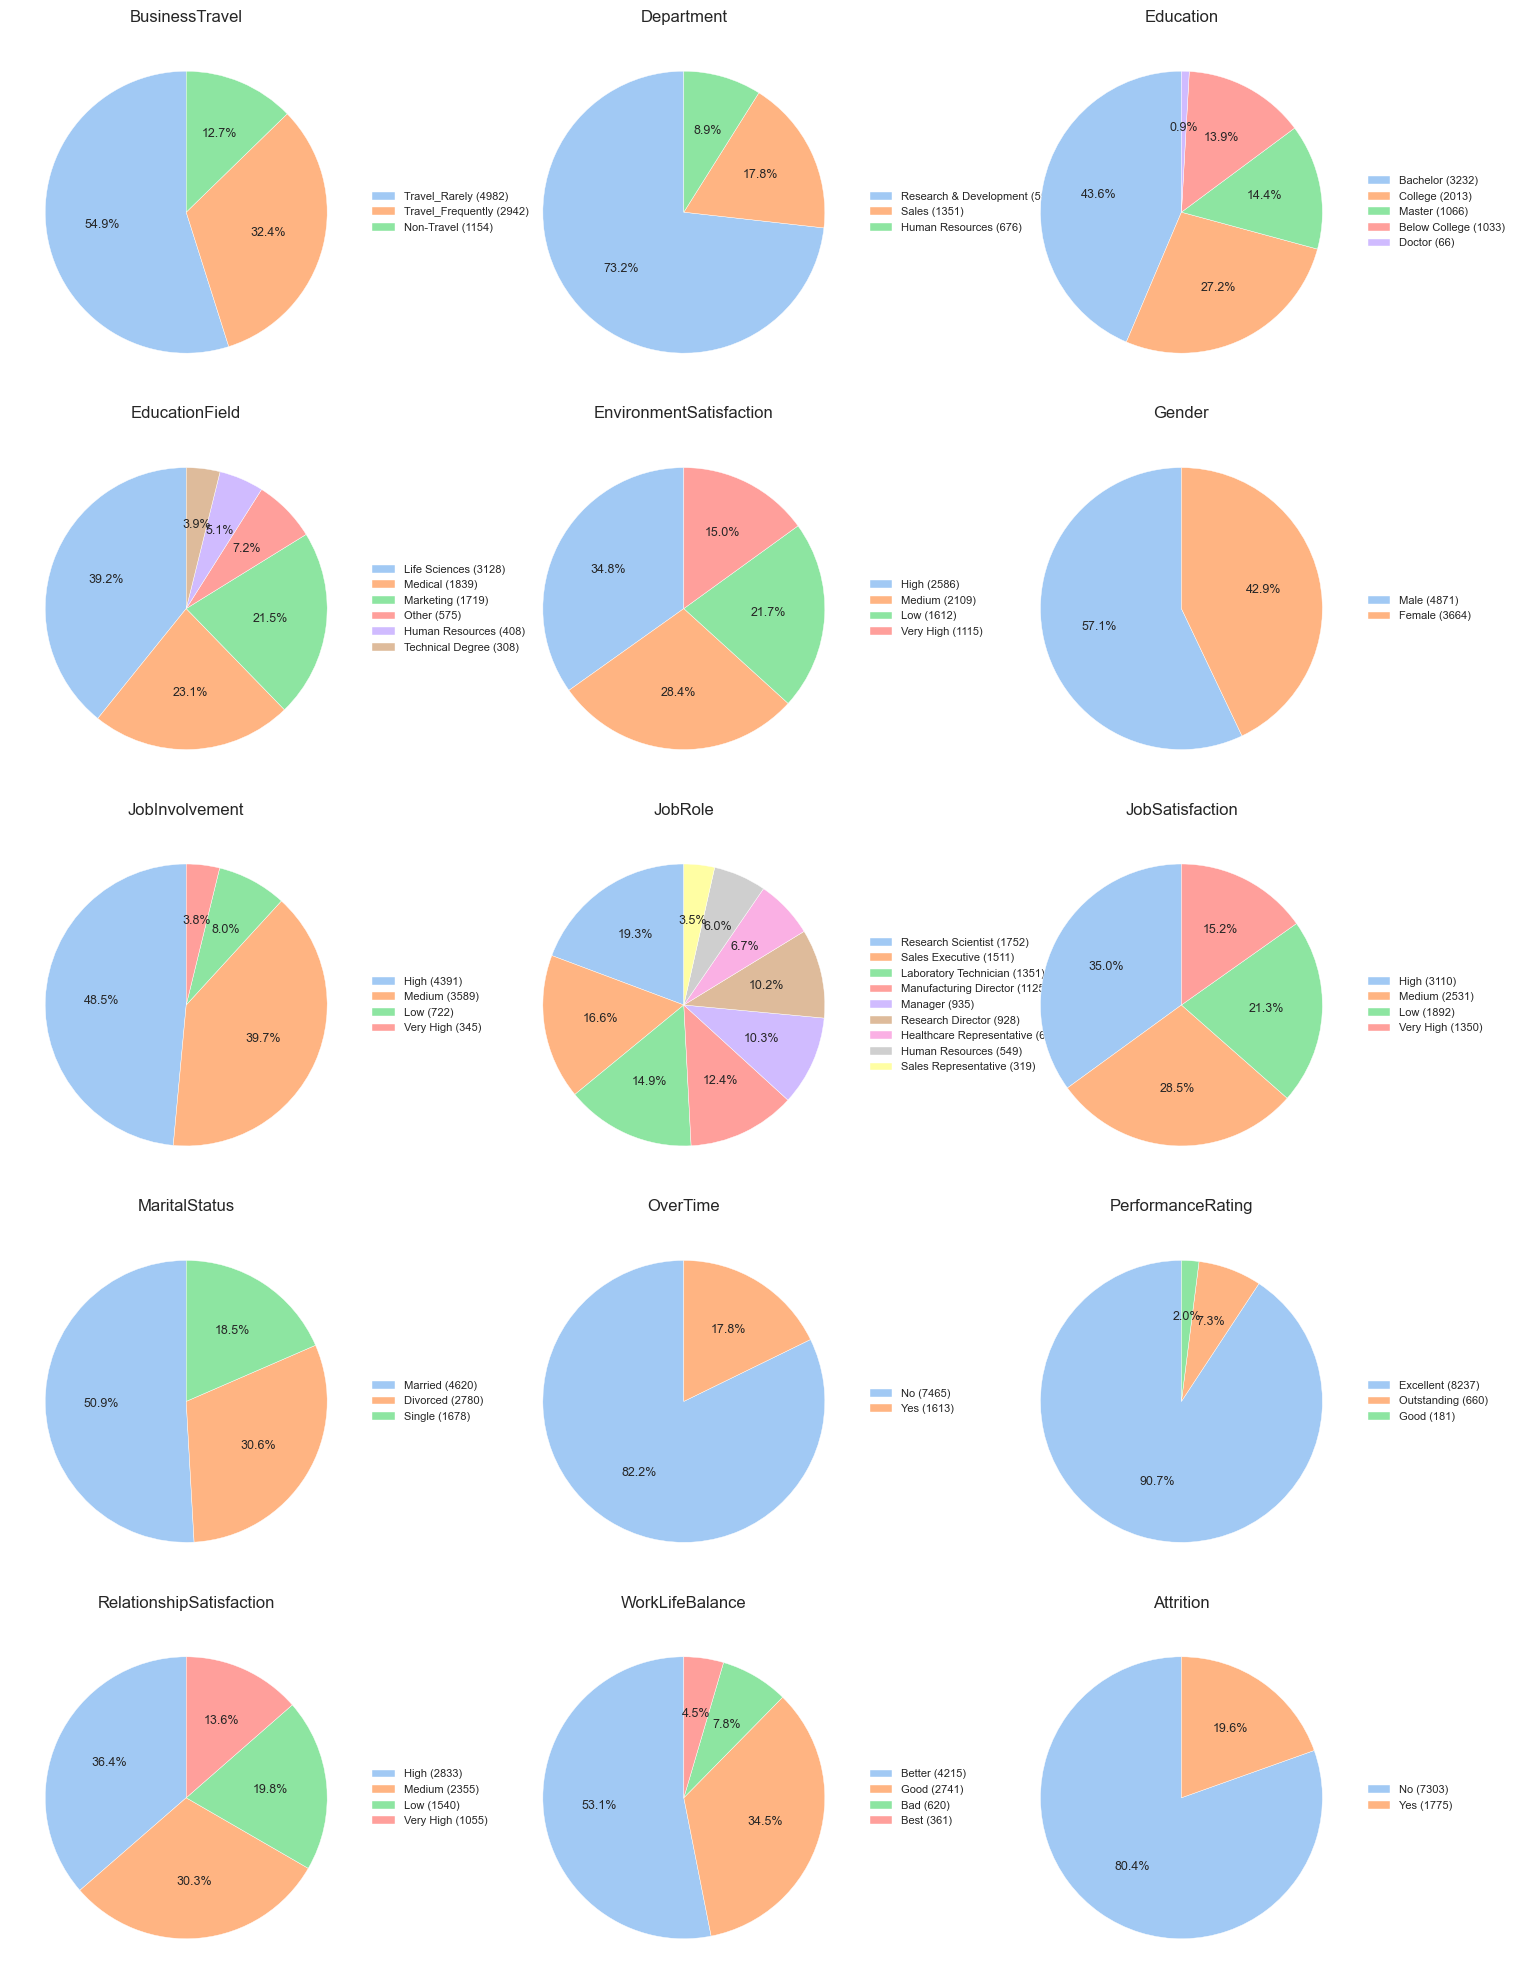

In [228]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define categorical columns
categorical_cols = ['BusinessTravel', 'Department', 'Education', 'EducationField', 
                    'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobRole', 
                    'JobSatisfaction', 'MaritalStatus', 'OverTime', 'PerformanceRating', 
                    'RelationshipSatisfaction', 'WorkLifeBalance', 'Attrition']

fig = create_categorical_pie_charts(df, categorical_cols)
# plt.savefig('categorical_pie_charts.png', dpi=300, bbox_inches='tight')
plt.show()

Correlation Analysis

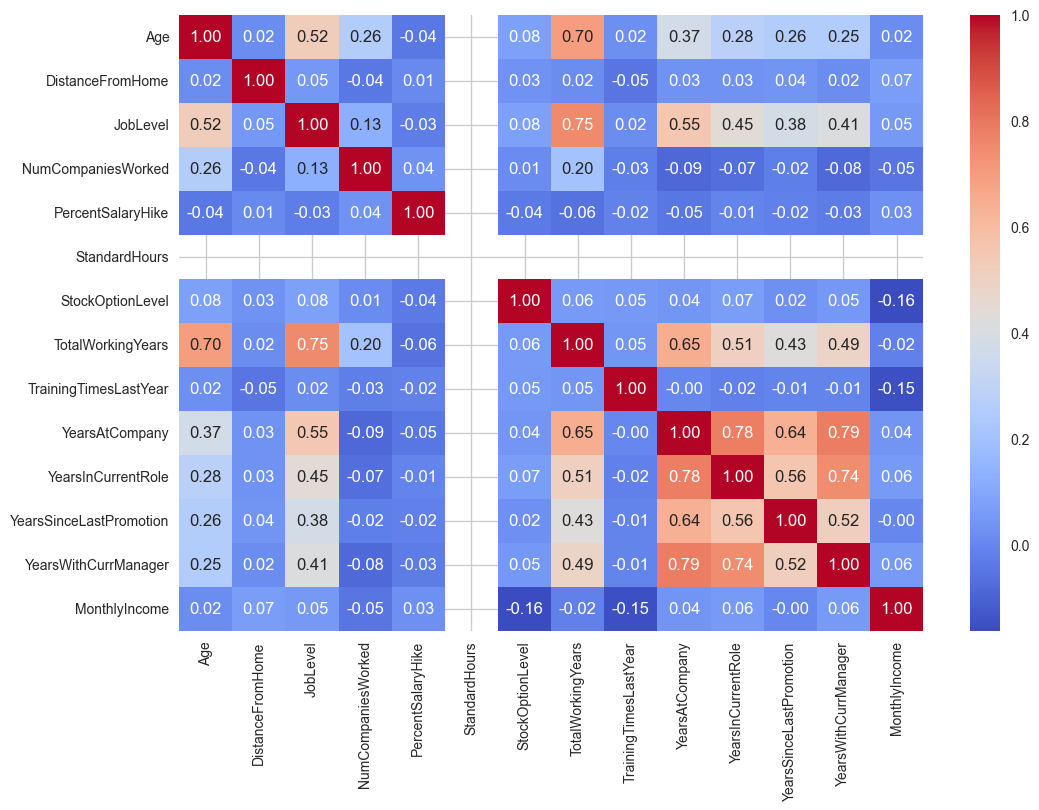

In [229]:
show_corr(df, numerical_cols)

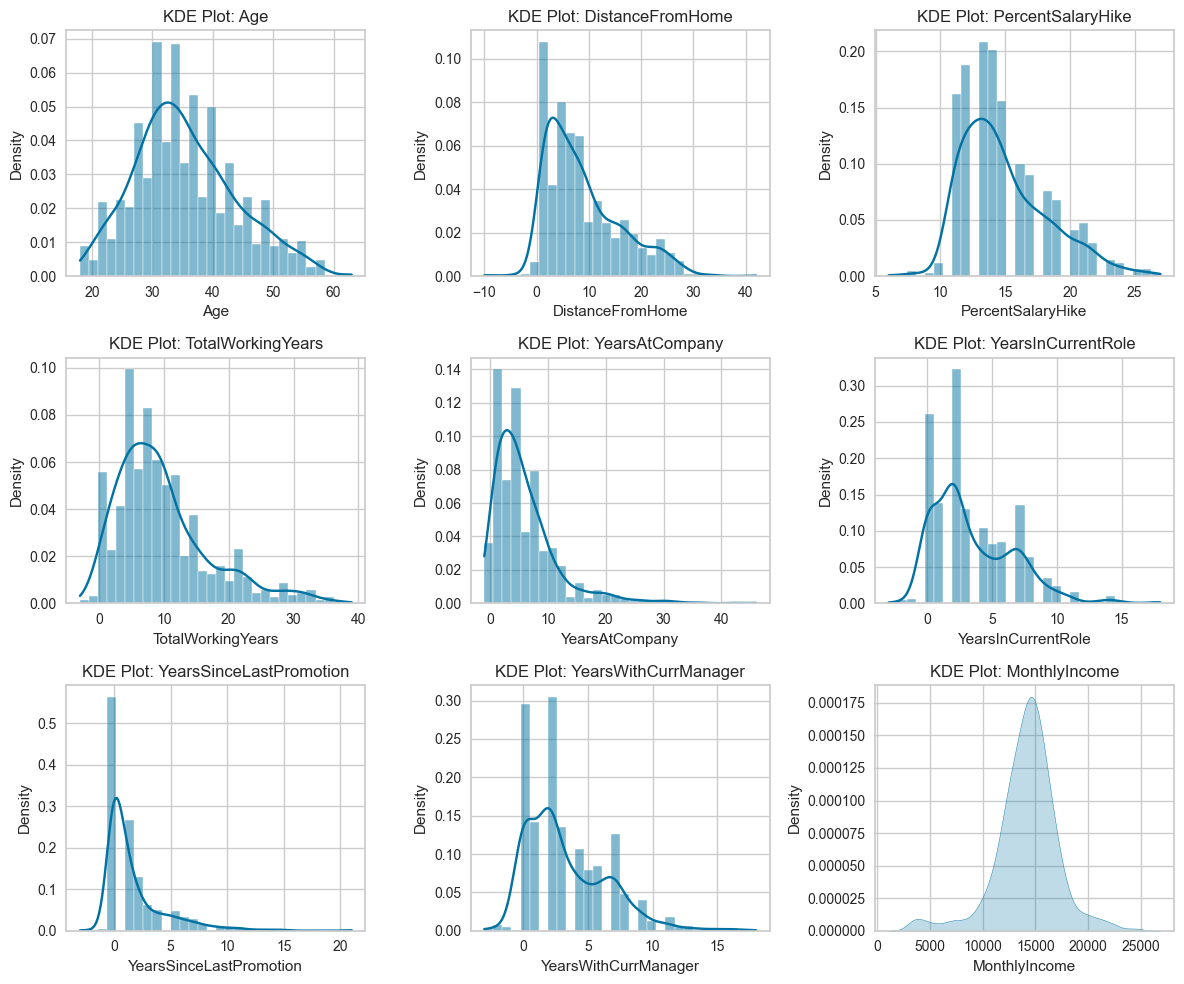

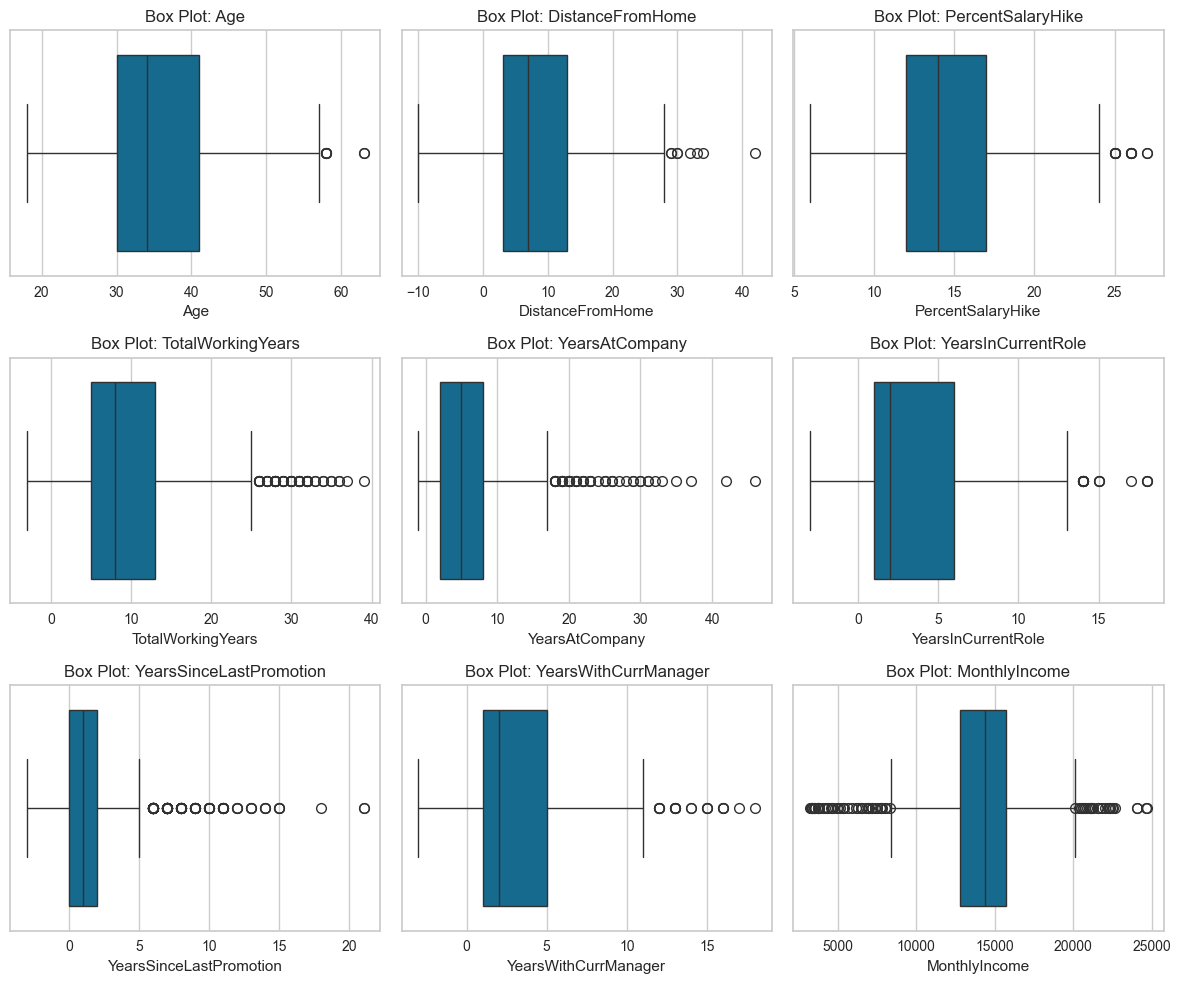

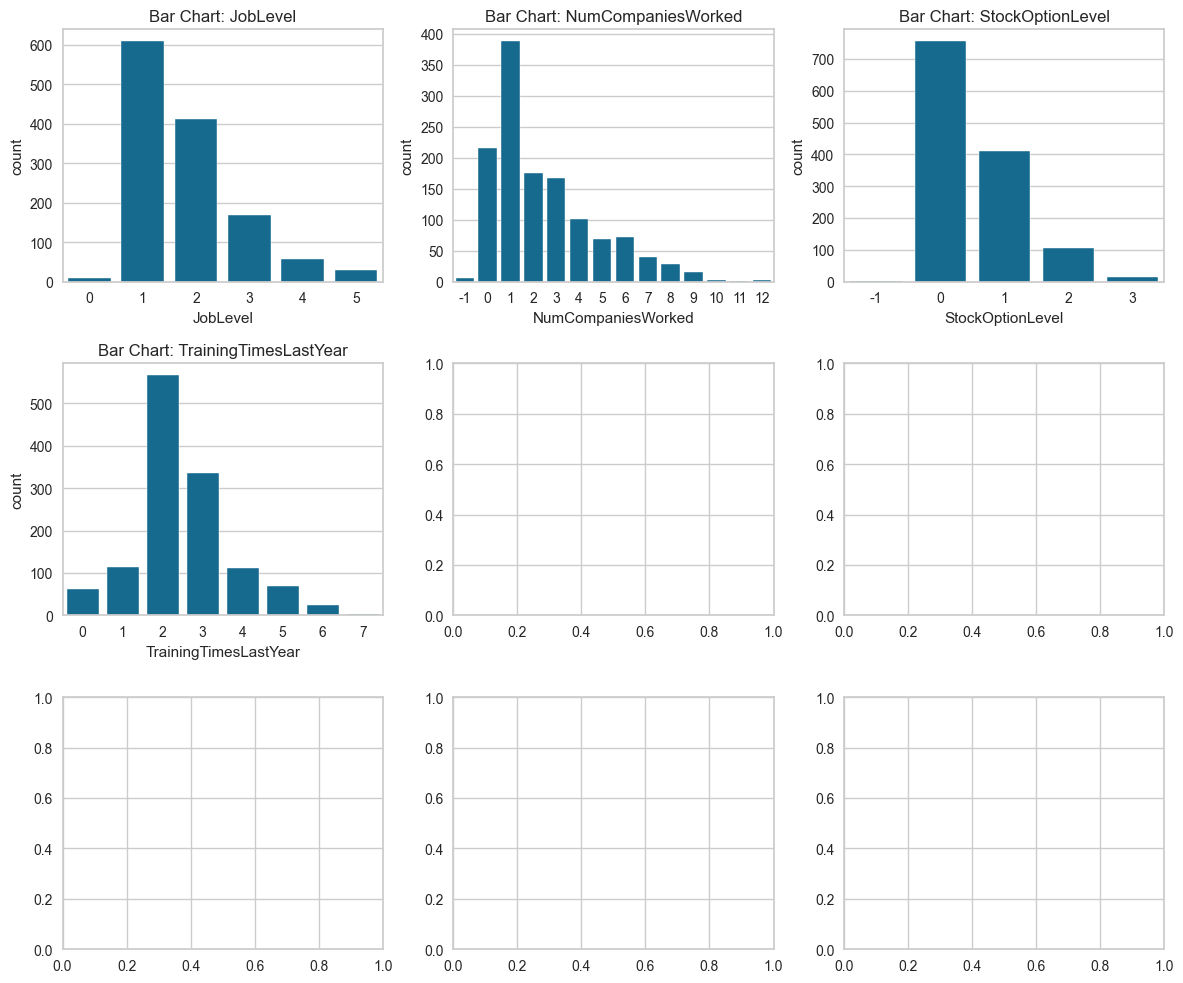

In [230]:
df_test = pd.read_csv('employee_test_classif.csv')

plot_kde_histograms(df_test, continuous_cols)
plot_box_plots(df_test, continuous_cols)
plot_bar_charts(df_test, discrete_cols)

### Classification

In [231]:
import pandas as pd

df_classif = pd.read_csv('employee_train.csv')
df_classif_test = pd.read_csv('employee_test_classif.csv')
df_classif = df_classif.drop(['ID'], axis=1)

In [232]:
df_classif.duplicated().sum()

np.int64(1367)

Menghilangkan data duplikat menyebabkan performa lebih buruk (skor Kaggle 0,75913 turun ke 0,72926) sehingga lebih baik jika tidak dilakukan 

In [233]:
# df_classif = df_classif.drop_duplicates()
# df_classif_test = df_classif_test.drop_duplicates()

In [234]:
import pandas as pd

# Count the number of 'Yes' and 'No' in the 'Attrition' column
attrition_counts = df_classif['Attrition'].value_counts()

# Print the counts
print("Attrition Counts:")
print(attrition_counts)

Attrition Counts:
Attrition
No     7303
Yes    1775
Name: count, dtype: int64


In [235]:
# Get categorical cols
categorical_cols = df_classif.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical cols:")
print(categorical_cols)

# Get numerical cols (should use 'number' instead)
numerical_cols = df_classif.select_dtypes(include=['number']).columns.tolist()
print("\nNumerical cols:")
print(numerical_cols)

Categorical cols:
['BusinessTravel', 'Department', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'OverTime', 'PerformanceRating', 'RelationshipSatisfaction', 'WorkLifeBalance', 'Attrition']

Numerical cols:
['Age', 'DistanceFromHome', 'JobLevel', 'NumCompaniesWorked', 'PercentSalaryHike', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'MonthlyIncome']


Data Cleaning

Menghilangkan nilai negatif agar data lebih mudah diprediksi oleh model.

In [236]:
#menghilangkan nilai negatif
for col in numerical_cols:
    df_classif[col] = df_classif[col].abs()
    df_classif_test[col] = df_classif_test[col].abs()

In [237]:
df_classif.loc[df_classif['PercentSalaryHike']==0].count()

Age                         0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EnvironmentSatisfaction     0
Gender                      0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
NumCompaniesWorked          0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
MonthlyIncome               0
Attrition                   0
dtype: int64

In [238]:
df_classif[numerical_cols].describe()

Age  DistanceFromHome     JobLevel  NumCompaniesWorked  \
count  9078.000000       9078.000000  9078.000000         9078.000000   
mean     35.413197          9.069729     1.801058            2.403173   
std       8.450982          7.274296     0.960880            2.274885   
min       4.000000          0.000000     0.000000            0.000000   
25%      30.000000          3.000000     1.000000            1.000000   
50%      34.000000          7.000000     2.000000            2.000000   
75%      40.000000         13.000000     2.000000            4.000000   
max      68.000000         41.000000     5.000000           13.000000   

       PercentSalaryHike  StandardHours  StockOptionLevel  TotalWorkingYears  \
count        8506.000000         9078.0       9078.000000        8032.000000   
mean           14.949330           80.0          0.544063           9.845867   
std             3.440793            0.0          0.699697           7.091353   
min             4.000000           80.0          0.000000           0.000000   
25%            12.000000           80.0          0.000000           5.000000   
50%            14.000000           80.0          0.000000           8.000000   
75%            17.000000           80.0          1.000000          13.000000   
max            29.000000           80.0          4.000000          42.000000   

       TrainingTimesLastYear  YearsAtCompany  YearsInCurrentRole  \
count            9078.000000     7968.000000         9078.000000   
mean                2.486561        5.940889            3.545715   
std                 1.192216        5.276266            3.196694   
min                 0.000000        0.000000            0.000000   
25%                 2.000000        2.000000            1.000000   
50%                 2.000000        5.000000            2.000000   
75%                 3.000000        8.000000            6.000000   
max                 7.000000       41.000000           23.000000   

       YearsSinceLastPromotion  YearsWithCurrManager  MonthlyIncome  
count              8546.000000           8538.000000    9078.000000  
mean                  1.713550              3.458304   14213.461360  
std                   2.676705              3.130028    2984.634565  
min                   0.000000              0.000000    3206.160000  
25%                   0.000000              1.000000   12871.332500  
50%                   1.000000              2.000000   14321.610000  
75%                   2.000000              6.000000   15786.557500  
max                  20.000000             21.000000   25535.330000

Beberapa kolom yang sebenarnya kolom kategorikal tetapi nilainya berbentuk integer dijadikan string lalu dimasukkan ke categorical cols untuk menghindari salah interpretasi oleh model.

In [239]:
# Add to categorical_cols
categorical_cols += ['JobLevel', 'StockOptionLevel']

# Create test version without 'Attrition'
categorical_cols_test = [col for col in categorical_cols if col != 'Attrition']

# Remove from numerical_cols
numerical_cols = [col for col in numerical_cols if col not in ['JobLevel', 'StockOptionLevel']]


In [240]:
for col in df_classif.columns:
    print(f"\n{col} - Unique values ({df_classif[col].nunique()}):")
    print(df_classif[col].unique())


Age - Unique values (53):
[28 25 36 38 50 53 37 27 34 41 30 31 56 60 33 29 23 32 35 40 26 48 51 24
 54 21 39 44 46 47 49 45 20 42 55 57 22 59 18 19 52 43 58 66  4 63 61 65
 62 68 64 67  6]

BusinessTravel - Unique values (3):
['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']

Department - Unique values (3):
['Research & Development' 'Sales' nan 'Human Resources']

DistanceFromHome - Unique values (42):
[ 4 14  3 12  1  2 10 15  8 11  0 28 17 23 21 26  7  6 18 24 13  9 25  5
 27 16 19 37 20 22 33 36 30 29 38 32 31 35 34 39 40 41]

Education - Unique values (5):
[nan 'Below College' 'Bachelor' 'Master' 'College' 'Doctor']

EducationField - Unique values (6):
['Other' 'Marketing' 'Life Sciences' 'Medical' 'Human Resources' nan
 'Technical Degree']

EnvironmentSatisfaction - Unique values (4):
['Very High' 'High' 'Medium' nan 'Low']

Gender - Unique values (2):
['Male' 'Female' nan]

JobInvolvement - Unique values (4):
['High' 'Medium' 'Very High' 'Low' nan]

JobLevel - Unique values (6)

In [241]:
# Check for missing values in all columns
missing_values_all = df_classif.isnull().sum().sort_values(ascending=False)

print("🔍 Missing Values (All Columns):\n")
print(missing_values_all)


🔍 Missing Values (All Columns):

Education                   1668
EnvironmentSatisfaction     1656
Department                  1509
RelationshipSatisfaction    1295
WorkLifeBalance             1141
YearsAtCompany              1110
EducationField              1101
TotalWorkingYears           1046
PercentSalaryHike            572
Gender                       543
YearsWithCurrManager         540
YearsSinceLastPromotion      532
JobSatisfaction              195
JobInvolvement                31
JobRole                        0
MaritalStatus                  0
DistanceFromHome               0
BusinessTravel                 0
Age                            0
JobLevel                       0
NumCompaniesWorked             0
StockOptionLevel               0
StandardHours                  0
OverTime                       0
PerformanceRating              0
YearsInCurrentRole             0
TrainingTimesLastYear          0
MonthlyIncome                  0
Attrition                      0
dtype: int

Handle missing values dengan mode untuk kategorikal dan median untuk numerikal karena data numerikal bersifat skewed.

In [242]:
df_classif = impute_values(df_classif, numerical_cols, 'median')
df_classif = impute_values(df_classif, categorical_cols_test, 'mode')

df_classif_test = impute_values(df_classif_test, numerical_cols, 'median')
df_classif_test = impute_values(df_classif_test, categorical_cols_test, 'mode')

In [243]:
# df_classif.duplicated().sum()

Data umur dibawah 18 tahun dianggap salah input sehingga digantikan dengan median.

In [244]:
# Step 1: Count rows where Age < 18 before replacement
num_invalid_age = df_classif.loc[df_classif['Age'] < 18].shape[0]
print(f"Number of rows with Age < 18 before replacement: {num_invalid_age}")

# Step 2: Compute median Age (excluding invalid values)
# Only use Age >= 18 to calculate the median to avoid skewing it with invalid values
median_age = df_classif.loc[df_classif['Age'] >= 18, 'Age'].median()
print(f"Median Age (for Age >= 18): {median_age}")

# Step 3: Replace Age < 18 with the median
df_classif.loc[df_classif['Age'] < 18, 'Age'] = median_age

# Step 4: Verify the replacement
num_invalid_age_after = df_classif.loc[df_classif['Age'] < 18].shape[0]
print(f"Number of rows with Age < 18 after replacement: {num_invalid_age_after}")

# Apply the same replacement to the test set
num_invalid_age_test = df_classif_test.loc[df_classif_test['Age'] < 18].shape[0]
print(f"\nNumber of rows with Age < 18 in test set before replacement: {num_invalid_age_test}")
df_classif_test.loc[df_classif_test['Age'] < 18, 'Age'] = median_age
num_invalid_age_test_after = df_classif_test.loc[df_classif_test['Age'] < 18].shape[0]
print(f"Number of rows with Age < 18 in test set after replacement: {num_invalid_age_test_after}")

# Step 5 : replace numcompanies worked=0 to median 
# Exclude zeros to compute the median
median_nonzero = df_classif.loc[df_classif["NumCompaniesWorked"] != 0, "NumCompaniesWorked"].median()
# Replace 0s with the computed median
df_classif["NumCompaniesWorked"] = df_classif["NumCompaniesWorked"].replace(0, median_nonzero)
# Exclude zeros to compute the median
median_nonzero = df_classif_test.loc[df_classif_test["NumCompaniesWorked"] != 0, "NumCompaniesWorked"].median()
# Replace 0s with the computed median
df_classif_test["NumCompaniesWorked"] = df_classif_test["NumCompaniesWorked"].replace(0, median_nonzero)

Number of rows with Age < 18 before replacement: 2
Median Age (for Age >= 18): 34.0
Number of rows with Age < 18 after replacement: 0

Number of rows with Age < 18 in test set before replacement: 0
Number of rows with Age < 18 in test set after replacement: 0


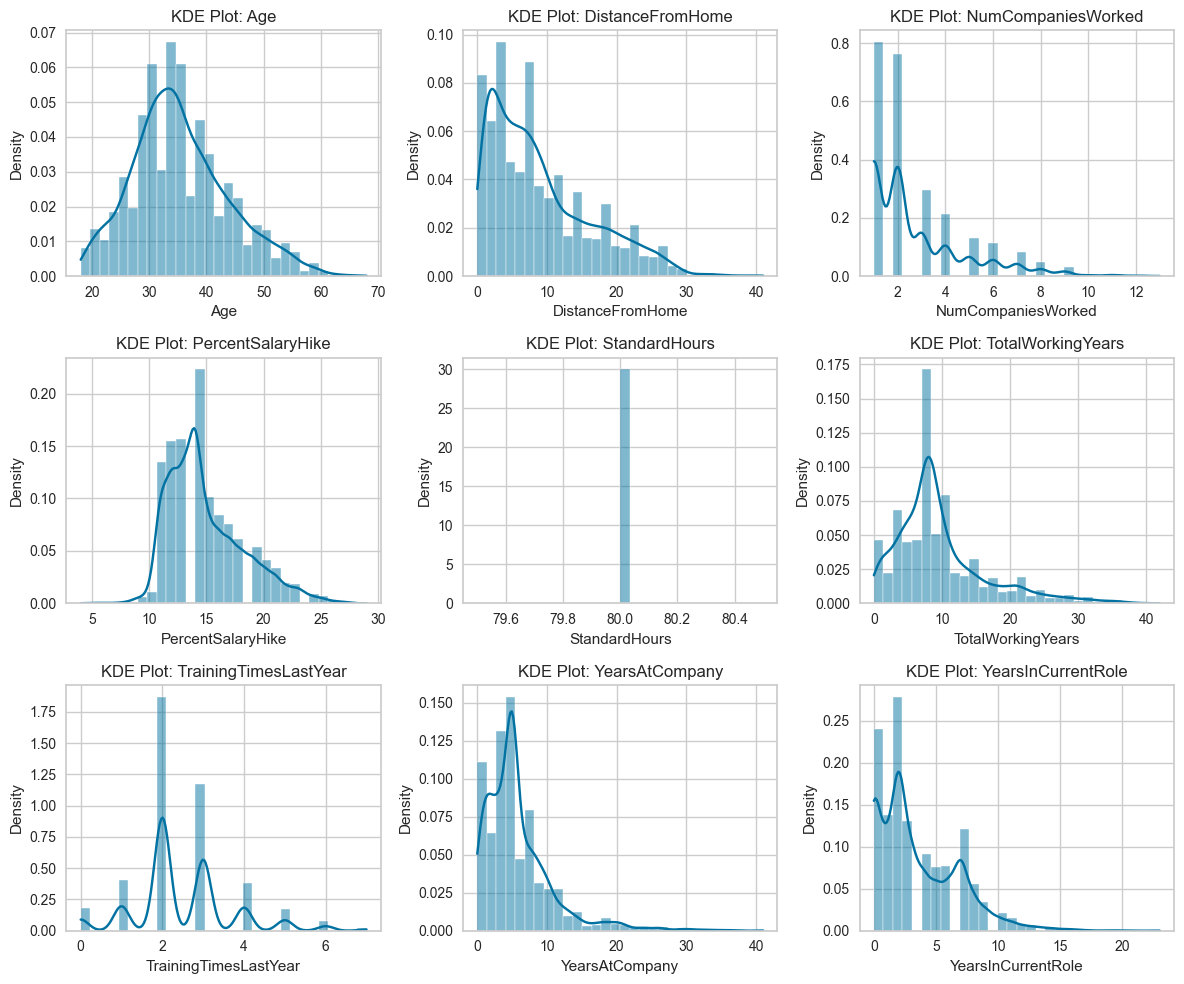

In [245]:
plot_kde_histograms(df_classif, numerical_cols)

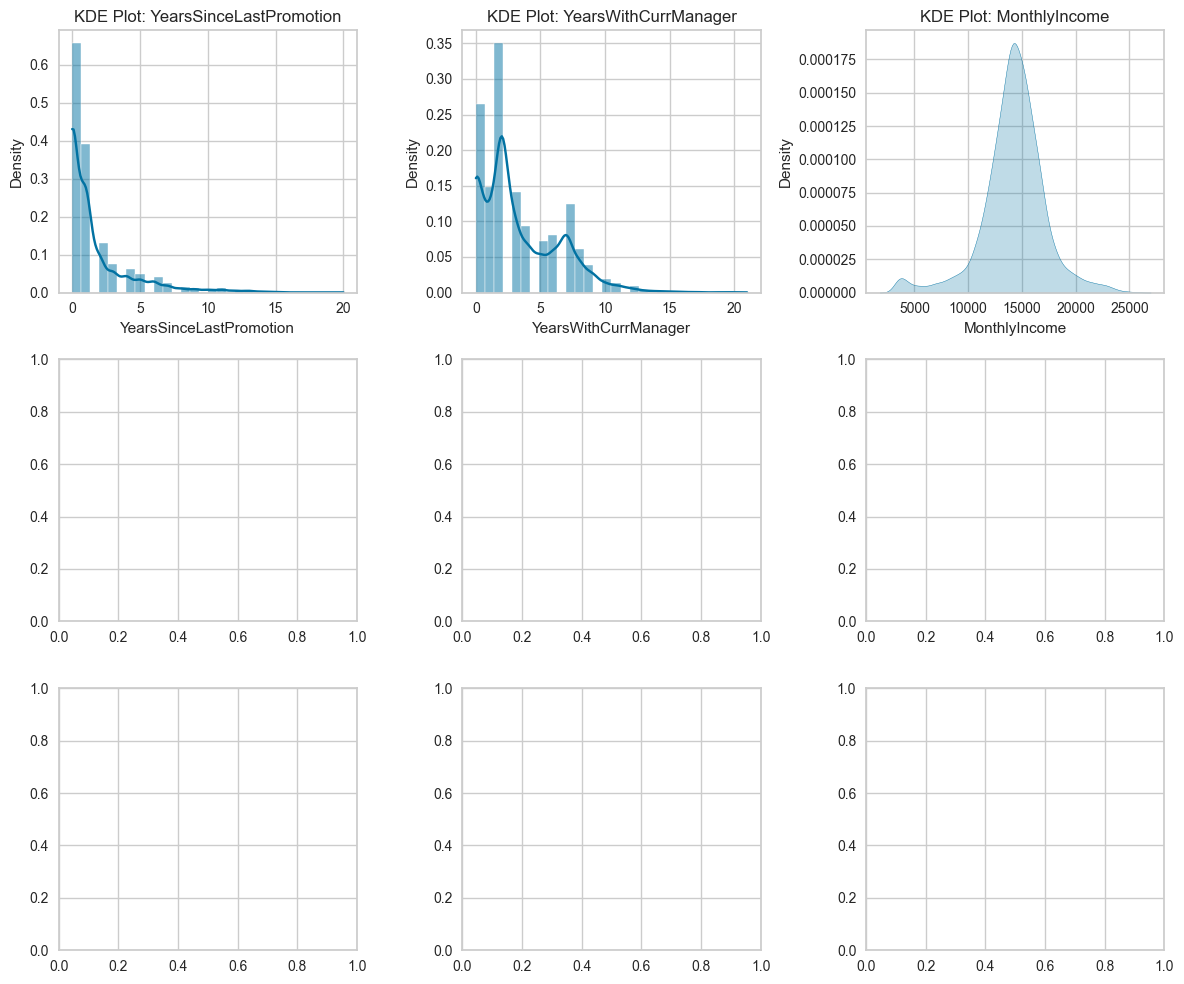

In [246]:
plot_kde_histograms(df_classif, ['YearsSinceLastPromotion','YearsWithCurrManager','MonthlyIncome'])

In [247]:
# Apply scaling/normalization based on column-specific methods
def apply_scaling(df, numerical_cols):
    df_copy = df.copy()
    
    # Columns for Log1p + StandardScaler
    log_then_standard_cols = [
        'DistanceFromHome', 'NumCompaniesWorked', 'TotalWorkingYears',
        'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager'
    ]
    df_copy = log_transform(df_copy, [col for col in log_then_standard_cols if col in numerical_cols])
    df_copy = standard_scale(df_copy, [col for col in log_then_standard_cols if col in numerical_cols])
    
    # Columns for StandardScaler only
    standard_cols = ['Age', 'PercentSalaryHike', 'MonthlyIncome']
    df_copy = standard_scale(df_copy, [col for col in standard_cols if col in numerical_cols])
    
    # Columns for MinMaxScaler
    minmax_cols = ['TrainingTimesLastYear']
    df_copy = minmax_scale(df_copy, [col for col in minmax_cols if col in numerical_cols])

    
    return df_copy

Outlier tidak dihandle karena hanya akan menyebabkan hilangnya informasi sehingga menyebabkan performa model lebih buruk dibandingkan jika tidak dihandle.

In [248]:
# df_classif = winsorize_outliers(df_classif, numerical_cols)
# df_classif_test = winsorize_outliers(df_classif_test, numerical_cols)

Scaling digunakan agar distribusi data bersifat lebih normal.

In [249]:
# Step 3: Apply scaling/normalization

# decent
df_classif = apply_scaling(df_classif, numerical_cols)
df_classif_test = apply_scaling(df_classif_test, numerical_cols)

# bad
# df_classif = log_transform(df_classif, numerical_cols)
# df_classif_test = log_transform(df_classif_test, numerical_cols)

# worse
# df_classif = standard_scale(df_classif, numerical_cols)
# df_classif_test = standard_scale(df_classif_test, numerical_cols)

In [250]:
# Fixed transformation pipeline
# df_classif = standard_scale(df_classif, ['Age', 'PercentSalaryHike', 'MonthlyIncome'])
# df_classif = log_transform(df_classif, [col for col in numerical_cols if col not in ['Age', 'PercentSalaryHike', 'MonthlyIncome']])

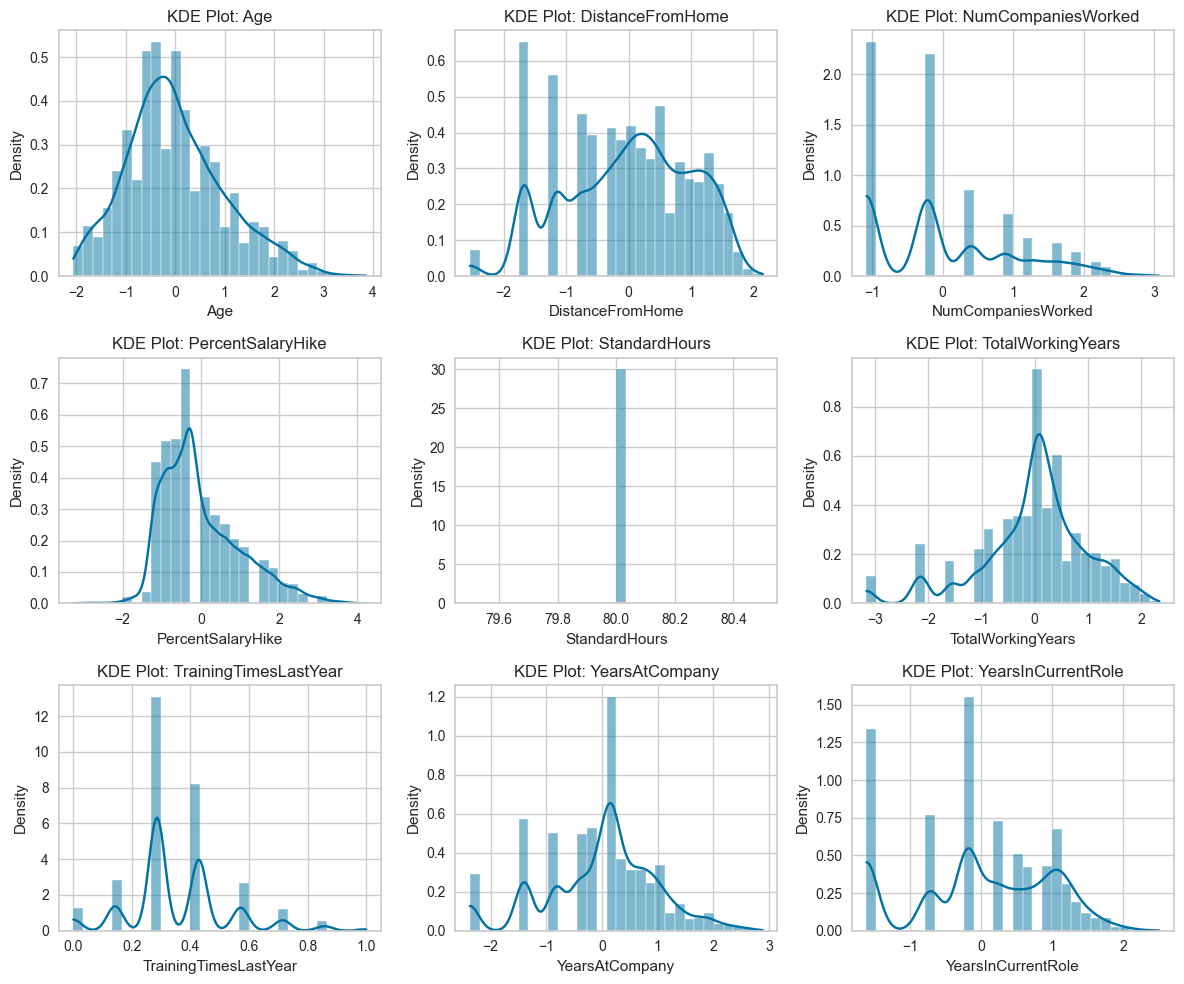

In [251]:
plot_kde_histograms(df_classif, numerical_cols)

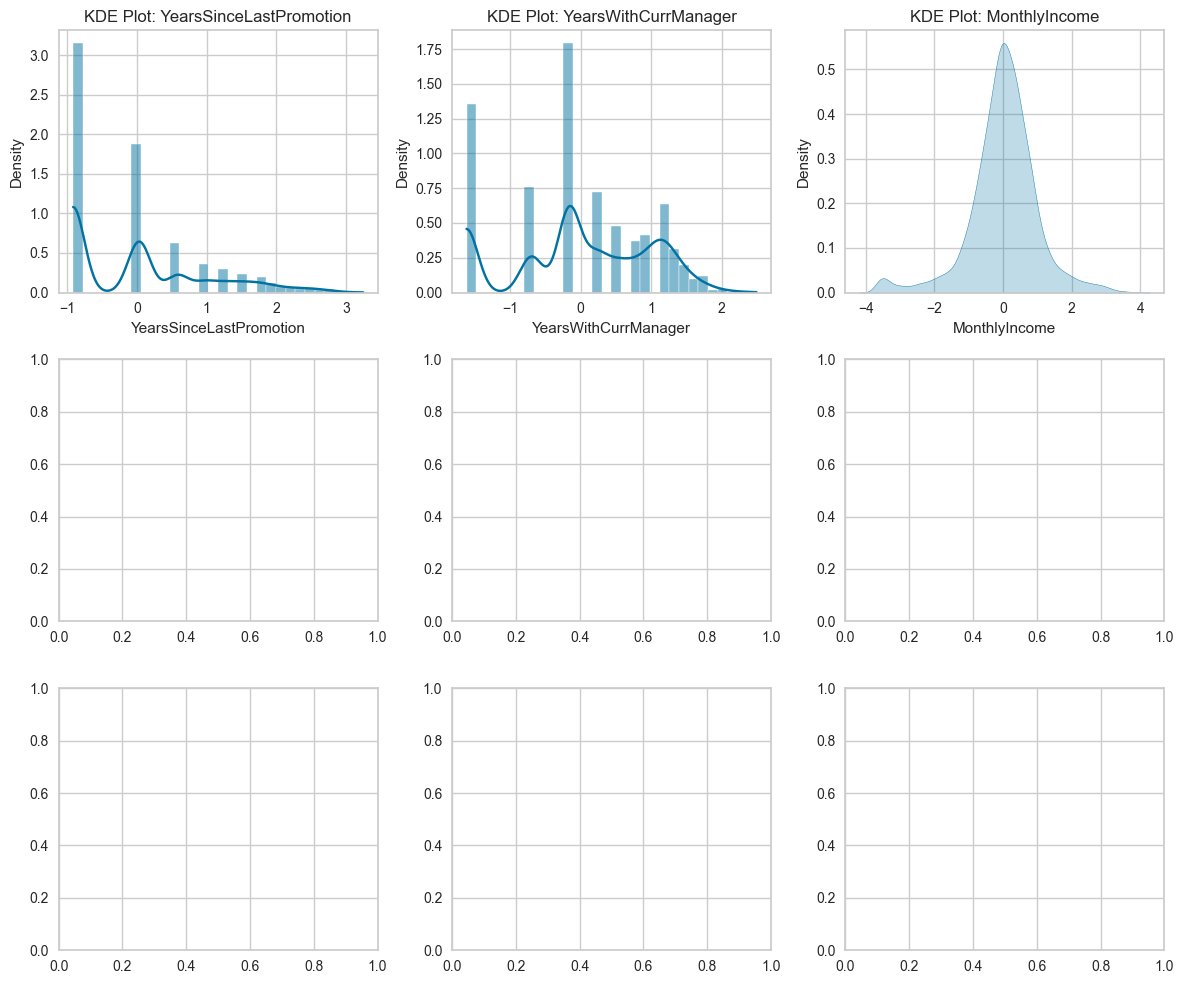

In [252]:
plot_kde_histograms(df_classif, ['YearsSinceLastPromotion','YearsWithCurrManager','MonthlyIncome'])

Categorical cols

Ordinal cols diencode dengan label encoding untuk menunjukkan urutan, non-ordinal cols diencode dengan onehot encoding agar model tidak salah mengira bahwa terdapat urutan pada nilai di suatu kolom. Label diencode dengan label encoding dengan No bernilai 0 dan Yes bernilai 1.

In [253]:
import pandas as pd

# Define columns (same as before)
ordinal_cols = [
    'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobSatisfaction',
    'PerformanceRating', 'RelationshipSatisfaction', 'WorkLifeBalance',
    'JobLevel', 'StockOptionLevel'
]
non_ordinal_cols = [
    'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
    'MaritalStatus', 'OverTime'
]
target_col = ['Attrition']
all_categorical_cols = ordinal_cols + non_ordinal_cols + target_col
all_categorical_cols_test = ordinal_cols + non_ordinal_cols

# Step 1: Impute missing values in categorical columns (already done)
# df_classif = impute_values(df_classif, all_categorical_cols, strategy='mode')
# df_classif_test = impute_values(df_classif_test, all_categorical_cols_test, strategy='mode')

# Step 2: Apply label encoding to ordinal columns and one-hot encoding to non-ordinal columns for df_classif
df_encoded, encoders = encode_categorical(df_classif, ordinal_cols, non_ordinal_cols)

# Step 3: Label encode the target column (Attrition) for df_classif
df_encoded, target_encoder = label_encode(df_encoded, target_col)
encoders.update(target_encoder)

# Step 4: Apply the same encoding to df_classif_test
# 4.1: Apply label encoding to ordinal columns using the same encoders
df_encoded_test = df_classif_test.copy()
for col in ordinal_cols:
    if col in encoders:
        mapping = encoders[col]
        if isinstance(mapping, dict):  # Custom mapping
            df_encoded_test[col] = df_encoded_test[col].map(mapping)
        else:  # LabelEncoder
            # Transform using the encoder, then add 1 to start from 1 (as per previous modification)
            df_encoded_test[col] = mapping.transform(df_encoded_test[col].astype(str)) + 1

# 4.2: Apply one-hot encoding to non-ordinal columns using get_dummies
df_encoded_test, _ = one_hot_encode(df_encoded_test, non_ordinal_cols)

# Align columns with df_encoded (to handle missing categories in test set)
missing_cols = set(df_encoded.columns) - set(df_encoded_test.columns) - set(target_col)
for col in missing_cols:
    df_encoded_test[col] = 0
df_encoded_test = df_encoded_test[df_encoded.columns.drop(target_col)]  # Exclude target for alignment

# 4.3: Label encode the target column (Attrition) using the target_encoder
# target_mapping = encoders['Attrition']
# if isinstance(target_mapping, dict):
#     df_encoded_test['Attrition'] = df_encoded_test['Attrition'].map(target_mapping)
# else:
    # df_encoded_test['Attrition'] = target_mapping.transform(df_encoded_test['Attrition'].astype(str)) + 1

# Print the first few rows of both DataFrames
print("Encoded Training Data (df_encoded):")
print(df_encoded.head())
print("\nEncoded Test Data (df_encoded_test):")
print(df_encoded_test.head())

# Print the encoders for reference
print("\nEncoders used:")
for col, encoder in encoders.items():
    print(f"{col}: {type(encoder)}")

Encoded Training Data (df_encoded):
        Age  DistanceFromHome  Education  EnvironmentSatisfaction  \
0 -0.879258         -0.520764          2                        3   
1 -1.234773          0.858031          0                        2   
2  0.068782         -0.800816          0                        1   
3  0.068782         -0.520764          2                        3   
4  0.305792          0.678435          2                        3   

   JobInvolvement  JobLevel  JobSatisfaction  NumCompaniesWorked  \
0               2         1                0            0.876326   
1               2         2                2           -0.214763   
2               1         2                1           -0.214763   
3               2         2                1            1.880222   
4               1         2                2            0.876326   

   PercentSalaryHike  PerformanceRating  ...  JobRole_Manufacturing Director  \
0          -1.165079                  1  ...                

In [254]:
# Get numerical cols (should use 'number' instead)
numerical_cols = df_classif.select_dtypes(include=['number']).columns.tolist()
print("\nNumerical cols:")
print(numerical_cols)

# Get numerical cols (should use 'number' instead)
numerical_cols_test = df_classif_test.select_dtypes(include=['number']).columns.tolist()
print("\nNumerical cols:")
print(numerical_cols)


Numerical cols:
['Age', 'DistanceFromHome', 'JobLevel', 'NumCompaniesWorked', 'PercentSalaryHike', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'MonthlyIncome']

Numerical cols:
['Age', 'DistanceFromHome', 'JobLevel', 'NumCompaniesWorked', 'PercentSalaryHike', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'MonthlyIncome']


Dilakukan feature engineering agar model dapat memahami interaksi antar fitur dan memahami informasi yang penting untuk prediksi.

In [255]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

# Assume df_encoded and df_encoded_test are the DataFrames after preprocessing
# Columns as provided
columns = [
    'Age', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction',
    'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'NumCompaniesWorked',
    'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
    'StandardHours', 'StockOptionLevel', 'TotalWorkingYears',
    'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
    'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
    'MonthlyIncome', 'BusinessTravel_Non-Travel',
    'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely',
    'Department_Human Resources', 'Department_Research & Development',
    'Department_Sales', 'EducationField_Human Resources',
    'EducationField_Life Sciences', 'EducationField_Marketing',
    'EducationField_Medical', 'EducationField_Other',
    'EducationField_Technical Degree', 'Gender_Female', 'Gender_Male',
    'JobRole_Healthcare Representative', 'JobRole_Human Resources',
    'JobRole_Laboratory Technician', 'JobRole_Manager',
    'JobRole_Manufacturing Director', 'JobRole_Research Director',
    'JobRole_Research Scientist', 'JobRole_Sales Executive',
    'JobRole_Sales Representative', 'MaritalStatus_Divorced',
    'MaritalStatus_Married', 'MaritalStatus_Single', 'OverTime_No',
    'OverTime_Yes', 'Attrition'
]

# Feature engineering function
def feature_engineering(df):
    df_fe = df.copy()
    
    # 1. Interaction Features
    df_fe['YearsAtCompany_JobLevel'] = df_fe['YearsAtCompany'] * df_fe['JobLevel']
    df_fe['MonthlyIncome_JobLevel'] = df_fe['MonthlyIncome'] * df_fe['JobLevel']
    
    # 2. Binned Features
    # Bin Age into categories
    age_bins = [0, 30, 40, 50, 100]
    age_labels = ['Under_30', '30_to_40', '40_to_50', 'Over_50']
    df_fe['Age_Binned'] = pd.cut(df_fe['Age'], bins=age_bins, labels=age_labels, include_lowest=True)
    age_binned_encoded = pd.get_dummies(df_fe['Age_Binned'], prefix='Age')
    df_fe = pd.concat([df_fe, age_binned_encoded], axis=1)
    df_fe = df_fe.drop('Age_Binned', axis=1)
    
    # Bin MonthlyIncome into quartiles
    df_fe['MonthlyIncome_Binned'] = pd.qcut(df_fe['MonthlyIncome'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    income_binned_encoded = pd.get_dummies(df_fe['MonthlyIncome_Binned'], prefix='MonthlyIncome')
    df_fe = pd.concat([df_fe, income_binned_encoded], axis=1)
    df_fe = df_fe.drop('MonthlyIncome_Binned', axis=1)
    
    # 3. Ratio Features
    # Avoid division by zero by adding a small constant
    df_fe['YearsInCurrentRole_to_YearsAtCompany'] = df_fe['YearsInCurrentRole'] / (df_fe['YearsAtCompany'] + 1e-10)
    df_fe['SalaryHike_to_Income'] = df_fe['PercentSalaryHike'] / (df_fe['MonthlyIncome'] + 1e-10)
    
    # 4. Aggregation of Time-Related Features
    df_fe['YearsWorkedElsewhere'] = df_fe['TotalWorkingYears'] - df_fe['YearsAtCompany']
    df_fe['YearsWorkedElsewhere'] = df_fe['YearsWorkedElsewhere'].clip(lower=0)
    
    # 5. Group Rare Categories (for JobRole)
    jobrole_cols = [
        'JobRole_Healthcare Representative', 'JobRole_Human Resources',
        'JobRole_Laboratory Technician', 'JobRole_Manager',
        'JobRole_Manufacturing Director', 'JobRole_Research Director',
        'JobRole_Research Scientist', 'JobRole_Sales Executive',
        'JobRole_Sales Representative'
    ]
    jobrole_sums = df_fe[jobrole_cols].sum()
    threshold = 0.05 * len(df_fe)
    rare_jobroles = jobrole_sums[jobrole_sums < threshold].index
    df_fe['JobRole_Other'] = df_fe[rare_jobroles].sum(axis=1)
    df_fe = df_fe.drop(columns=rare_jobroles)
    remaining_jobroles = [col for col in jobrole_cols if col not in rare_jobroles]
    for col in remaining_jobroles:
        df_fe.loc[df_fe['JobRole_Other'] == 1, col] = 0
    
    # 6. Polynomial Features (for YearsAtCompany)
    poly = PolynomialFeatures(degree=2, include_bias=False)
    years_at_company_poly = poly.fit_transform(df_fe[['YearsAtCompany']])
    df_fe['YearsAtCompany_Squared'] = years_at_company_poly[:, 1]  # Second column is the squared term
    
    # Drop StandardHours (constant column)
    if 'StandardHours' in df_fe.columns:
        df_fe = df_fe.drop('StandardHours', axis=1)

    # Existing New Features
    # 1. OverTime_JobLevel interaction
    df_fe['OverTime_JobLevel'] = df_fe['OverTime_Yes'] * df_fe['JobLevel']
    
    # 2. Satisfaction Score (average of satisfaction metrics)
    satisfaction_cols = ['EnvironmentSatisfaction', 'JobSatisfaction', 'RelationshipSatisfaction']
    df_fe['Satisfaction_Score'] = df_fe[satisfaction_cols].mean(axis=1)
    
    # 3. Career Stagnation (lack of promotion relative to tenure)
    df_fe['Career_Stagnation'] = df_fe['YearsSinceLastPromotion'] / (df_fe['YearsAtCompany'] + 1e-10)
    
    # New Employee Welfare Features
    # 1. Welfare Index (composite score of satisfaction and work-life balance)
    welfare_cols = ['EnvironmentSatisfaction', 'JobSatisfaction', 'RelationshipSatisfaction', 'WorkLifeBalance']
    df_fe['Welfare_Index'] = df_fe[welfare_cols].mean(axis=1)  # Average score (0-4 scale)
    
    # 2. OverTime Stress Indicator (interaction of OverTime and DistanceFromHome)
    df_fe['OverTime_Stress'] = df_fe['OverTime_Yes'] * df_fe['DistanceFromHome']
    
    # 3. WorkLifeBalance_Satisfaction (interaction of WorkLifeBalance and average satisfaction)
    df_fe['WorkLifeBalance_Satisfaction'] = df_fe['WorkLifeBalance'] * df_fe['Satisfaction_Score']
    
    # 4. Tenure_Stress (ratio of tenure to work-life balance)
    df_fe['Tenure_Stress'] = df_fe['YearsAtCompany'] / (df_fe['WorkLifeBalance'] + 1e-10)  # Avoid division by zero
    
    return df_fe

# Apply feature engineering to both training and test sets
df_encoded = feature_engineering(df_encoded)
df_encoded_test = feature_engineering(df_encoded_test)

# Print the new columns added
print("New columns added after feature engineering:")
new_cols = set(df_encoded.columns) - set(columns)
print(new_cols)

# Print the first few rows of the feature-engineered training DataFrame
print("\nFeature-engineered Training Data (df_encoded):")
print(df_encoded.head())

New columns added after feature engineering:
{'YearsAtCompany_JobLevel', 'Welfare_Index', 'JobRole_Other', 'OverTime_JobLevel', 'YearsWorkedElsewhere', 'Age_30_to_40', 'Age_40_to_50', 'Tenure_Stress', 'MonthlyIncome_JobLevel', 'OverTime_Stress', 'SalaryHike_to_Income', 'Age_Over_50', 'Age_Under_30', 'WorkLifeBalance_Satisfaction', 'Satisfaction_Score', 'MonthlyIncome_Q3', 'MonthlyIncome_Q4', 'YearsInCurrentRole_to_YearsAtCompany', 'YearsAtCompany_Squared', 'MonthlyIncome_Q1', 'Career_Stagnation', 'MonthlyIncome_Q2'}

Feature-engineered Training Data (df_encoded):
        Age  DistanceFromHome  Education  EnvironmentSatisfaction  \
0 -0.879258         -0.520764          2                        3   
1 -1.234773          0.858031          0                        2   
2  0.068782         -0.800816          0                        1   
3  0.068782         -0.520764          2                        3   
4  0.305792          0.678435          2                        3   

   JobInvolveme

In [256]:
X_train_classification = df_encoded.drop(['Attrition'], axis=1)
y_train_classification = df_encoded['Attrition']

In [257]:
len(X_train_classification.columns)

69

Pilih beberapa fitur yang memiliki importance paling tinggi. Hal ini karena apabila semua fitur diambil akan menyebabkan terlalu banyak noise  yang menyebabkan overfitting.

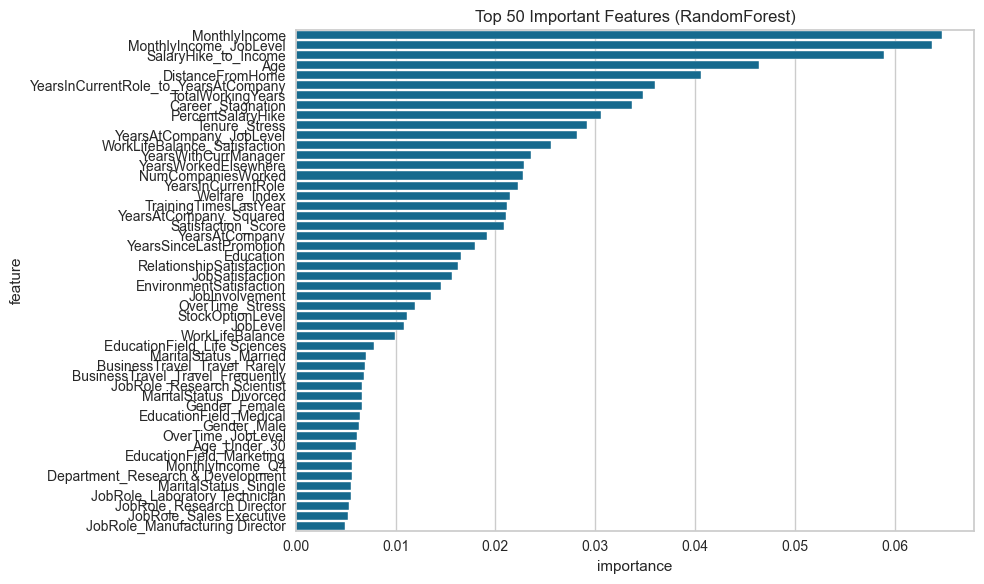

In [258]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

weights = {0: 1775, 1: 7303}

# Step 1: Fit a RandomForest on all features
rf = RandomForestClassifier(n_estimators=100, class_weight=weights, random_state=42)
rf.fit(X_train_classification, y_train_classification)

# Step 2: Get and sort feature importances
importances = rf.feature_importances_
feature_names = X_train_classification.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Optional: Plot top 30
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df.head(50))
plt.title("Top 50 Important Features (RandomForest)")
plt.tight_layout()
plt.show()

# Step 3: Select top N important features (e.g., top 35)
top_features = importance_df.head(35)['feature'].tolist()
X_train_classification = X_train_classification[top_features]
df_encoded_test = df_encoded_test[top_features]

Dipilih top 35, hal ini karena kalo dipilih semua ternyata kebanyakan noise yang ditangkap sehingga menyebabkan ada misclassification/class noise dan juga untuk mengurangi resiko overfitting.

In [259]:
top_features[:10]

['MonthlyIncome',
 'MonthlyIncome_JobLevel',
 'SalaryHike_to_Income',
 'Age',
 'DistanceFromHome',
 'YearsInCurrentRole_to_YearsAtCompany',
 'TotalWorkingYears',
 'Career_Stagnation',
 'PercentSalaryHike',
 'Tenure_Stress']

Dilakukan undersampling dengan Tomek Links untuk mengurangi noise sehingga meningkatkan performa model.

In [260]:
from collections import Counter
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
import pandas as pd

# Assuming X and y are your features and target
print("🔍 Original class distribution:")
print(Counter(y_train_classification))

# Step 1: Remove Tomek links (under-sampling)
tomek = TomekLinks()
X_train_classification, y_train_classification = tomek.fit_resample(X_train_classification, y_train_classification)

print("\n🧹 After Tomek Links:")
print(Counter(y_train_classification))

# # Step 2: Apply SMOTE (over-sampling) -> tidak digunakan karena mengakibatkan overfitting
# smote = SMOTE(random_state=42)
# X_train_classification, y_train_classification = smote.fit_resample(X_tomek, y_tomek)

# print("\n🔁 After SMOTE:")
# print(Counter(y_train_classification))

🔍 Original class distribution:
Counter({0: 7303, 1: 1775})

🧹 After Tomek Links:
Counter({0: 6973, 1: 1775})


Modelling dilakukan dengan RandomizedSearchCV untuk mencari hyperparameter terbaik, sambil memberi bobot lebih besar ke kelas 1 agar model lebih fokus mendeteksi kasus minoritas. Diujikan juga ensemble 3 model terbaik untuk membandingkan performa terhadap model terbaik.

🔍 Tuning LogisticRegression...


C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
60 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Fikri Budianto\Ap

🔍 Tuning XGBoost...


C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [21:46:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔍 Tuning RandomForest...


C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
26 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_trai

🔍 Tuning GradientBoosting...


C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


🔍 Tuning ExtraTrees...


C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line

🔍 Tuning KNN...
🔍 Tuning LightGBM...


C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1775, number of negative: 6973
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2025
[LightGBM] [Info] Number of data points in the train set: 8748, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.884214 -> initscore=2.032952
[LightGBM] [Info] Start training from score 2.032952
🔍 Tuning BalancedRandomForest...


C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line

🔍 Tuning EasyEnsemble...
🔍 Tuning CatBoost...
🔍 Tuning GaussianNB...


C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


🔍 Tuning RidgeClassifier...
🔍 Tuning MLP...


C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Fikri Budianto\Ap


📊 Model Performance Summary (Sorted by F1 Weighted):



best_threshold  f1_weighted  f1_micro  f1_macro  \
XGBoost                         0.80     0.819759  0.841335  0.692888   
BalancedRandomForest            0.70     0.819035  0.843736  0.688154   
KNN                             0.70     0.816789  0.846708  0.678793   
ExtraTrees                      0.85     0.816748  0.851052  0.673986   
CatBoost                        0.85     0.816730  0.840078  0.686092   
RandomForest                    0.60     0.816490  0.839963  0.685571   
LightGBM                        0.85     0.815955  0.838706  0.685570   
GradientBoosting                0.55     0.813036  0.834476  0.682535   
MLP                             0.70     0.790478  0.800869  0.661265   
EasyEnsemble                    0.60     0.724238  0.768176  0.517740   
RidgeClassifier                 0.60     0.720519  0.755258  0.522300   
GaussianNB                      0.35     0.707099  0.797096  0.443547   
LogisticRegression              0.85     0.638018  0.608253  0.499010   

                      precision    recall  accuracy   roc_auc  
XGBoost                0.717172  0.360000  0.841335  0.763866  
BalancedRandomForest   0.756927  0.338592  0.843736  0.764716  
KNN                    0.834877  0.304789  0.846708  0.741365  
ExtraTrees             0.948669  0.281127  0.851052  0.741627  
CatBoost               0.722222  0.344225  0.840078  0.737754  
RandomForest           0.722420  0.343099  0.839963  0.728658  
LightGBM               0.709677  0.347042  0.838706  0.756879  
GradientBoosting       0.677524  0.351549  0.834476  0.740709  
MLP                    0.512159  0.391549  0.800869  0.689545  
EasyEnsemble           0.310912  0.117183  0.768176  0.593980  
RidgeClassifier        0.288194  0.140282  0.755258  0.565099  
GaussianNB             0.000000  0.000000  0.797096  0.495674  
LogisticRegression     0.213989  0.348169  0.608253  0.514137

C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [22:01:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


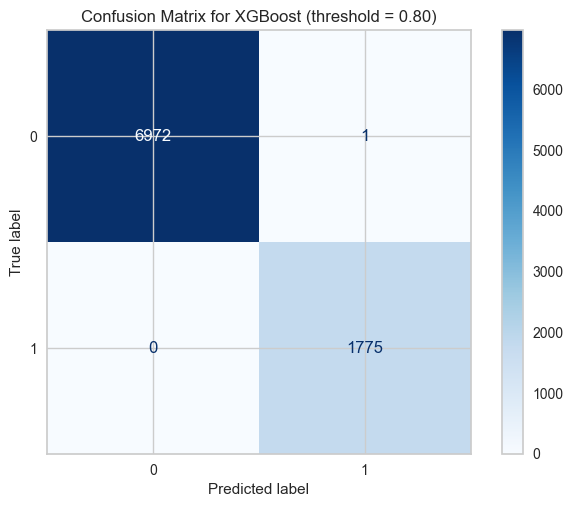

C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [22:01:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X

In [261]:
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

weights = {0: 1, 1: 30}

models_and_params = {
    "LogisticRegression": (
        LogisticRegression(max_iter=1000, solver='lbfgs', class_weight=weights, random_state=42),
        {
            'C': np.logspace(-2, 2, 20),  # Added more granularity
            'solver': ['lbfgs', 'liblinear', 'newton-cg'],  # Added 'newton-cg'
            'penalty': ['l2', 'l1', 'elasticnet'],  # Added 'elasticnet' with 'l1_ratio'
            'l1_ratio': np.linspace(0, 1, 5)  # For elasticnet
        }
    ),
    "XGBoost": (
        XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=30),
        {
            'n_estimators': [100, 200, 300, 500],  # Added 500
            'max_depth': [3, 5, 7, 10, 15],  # Added 15
            'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],  # Added 0.001 and 0.3
            'subsample': [0.6, 0.8, 1.0, 0.9],  # Added 0.9
            'colsample_bytree': [0.6, 0.8, 1.0, 0.7],  # Added 0.7
            'min_child_weight': [1, 3, 5, 7],  # Added to control over-fitting
            'gamma': [0, 0.1, 0.2, 0.5],  # Added for regularization
            'reg_alpha': [0, 0.1, 1.0, 10.0],  # L1 regularization
            'reg_lambda': [0, 0.1, 1.0, 10.0]  # L2 regularization
        }
    ),
    "RandomForest": (
        RandomForestClassifier(class_weight=weights, random_state=42),
        {
            'n_estimators': [100, 200, 300, 400],  # Added 400
            'max_depth': [None, 10, 20, 30, 50],  # Added 50
            'min_samples_split': [2, 5, 10, 15],  # Added 15
            'min_samples_leaf': [1, 2, 4],  # Added to prevent over-fitting
            'max_features': ['auto', 'sqrt', 'log2']  # Added feature selection strategy
        }
    ),
    "GradientBoosting": (
        GradientBoostingClassifier(random_state=42),
        {
            'n_estimators': [100, 200, 300],  # Added 300
            'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],  # Added 0.001 and 0.3
            'max_depth': [3, 5, 7, 10],  # Added 10
            'min_samples_split': [2, 5, 10],  # Added to control splits
            'min_samples_leaf': [1, 2, 4],  # Added to prevent over-fitting
            'subsample': [0.6, 0.8, 1.0]  # Added for stochastic gradient boosting
        }
    ),
    "ExtraTrees": (
        ExtraTreesClassifier(class_weight=weights, random_state=42),
        {
            'n_estimators': [100, 200, 300, 400],  # Added 400
            'max_depth': [None, 10, 20, 30],  # Added 30
            'min_samples_split': [2, 5, 10, 15],  # Added 15
            'min_samples_leaf': [1, 2, 4],  # Added to prevent over-fitting
            'max_features': ['auto', 'sqrt', 'log2']  # Added feature selection strategy
        }
    ),
    "KNN": (
        KNeighborsClassifier(),
        {
            'n_neighbors': [3, 5, 7, 9, 11],  # Added 11
            'weights': ['uniform', 'distance'],
            'p': [1, 2],  # Added Manhattan (1) and Euclidean (2) distances
            'leaf_size': [20, 30, 40]  # Added to optimize tree structure
        }
    ),
    "LightGBM": (
        LGBMClassifier(class_weight=weights, random_state=42),
        {
            'n_estimators': [100, 200, 300],  # Added 300
            'learning_rate': [0.001, 0.01, 0.1, 0.2],  # Added 0.001
            'max_depth': [-1, 10, 20, 30],  # Added 30
            'num_leaves': [31, 50, 70],  # Added to control tree complexity
            'subsample': [0.6, 0.8, 1.0],  # Added for stochastic training
            'colsample_bytree': [0.6, 0.8, 1.0]  # Added for column sampling
        }
    ),
    "BalancedRandomForest": (
        BalancedRandomForestClassifier(sampling_strategy='auto', n_jobs=-1, random_state=42),
        {
            'n_estimators': [100, 200, 300, 400],  # Added 400
            'max_depth': [None, 10, 20, 30],  # Added 30
            'min_samples_split': [2, 5, 10, 15],  # Added 15
            'min_samples_leaf': [1, 2, 4],  # Added to prevent over-fitting
            'max_features': ['auto', 'sqrt', 'log2']  # Added feature selection strategy
        }
    ),
    "EasyEnsemble": (
        EasyEnsembleClassifier(random_state=42, n_jobs=-1),
        {
            'n_estimators': [10, 20, 30, 50],  # Added 50
            'sampling_strategy': ['auto', 0.5, 1.0],  # Added sampling options
            'replacement': [True, False]  # Added to control sampling with replacement
        }
    ),
    "CatBoost": (
        CatBoostClassifier(verbose=0, random_state=42, class_weights=weights),
        {
            'iterations': [100, 200, 300, 500],  # Added 500
            'depth': [4, 6, 8, 10],  # Added 10
            'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],  # Added 0.001 and 0.3
            'l2_leaf_reg': [1, 3, 5, 10],  # Added L2 regularization
            'border_count': [32, 64, 128]  # Added to control split points
        }
    ),
    "GaussianNB": (
        GaussianNB(),
        {
            'var_smoothing': np.logspace(0, -9, num=10)  # Added to handle noise
        }
    ),
    "RidgeClassifier": (
        RidgeClassifier(class_weight=weights, random_state=42),
        {
            'alpha': [0.1, 1.0, 10.0, 100.0],  # Added 100.0
            'solver': ['auto', 'svd', 'cholesky']  # Added solver options
        }
    ),
    'MLP': (
        MLPClassifier(random_state=42, max_iter=500),
        {
            'hidden_layer_sizes': [(50,), (50, 30), (100,)],
            'alpha': [1e-4, 1e-3],
            'activation': ['relu', 'tanh'],
            'solver': ['sgd', 'adam']
        }
    ),
}

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

threshold_metrics = {}

for name, (model, param_dist) in models_and_params.items():
    print(f"🔍 Tuning {name}...")
    search = RandomizedSearchCV(
        model,
        param_distributions=param_dist,
        n_iter=10,
        scoring='f1',
        refit=True,
        cv=cv,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train_classification, y_train_classification)
    best_model = search.best_estimator_
    
    # Get predicted probabilities (only for classifiers supporting predict_proba)
    if hasattr(best_model, "predict_proba"):
        probas = cross_val_predict(best_model, X_train_classification, y_train_classification, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]
    elif hasattr(best_model, "decision_function"):
        raw_scores = cross_val_predict(best_model, X_train_classification, y_train_classification, cv=cv, method="decision_function", n_jobs=-1)
        probas = (raw_scores - raw_scores.min()) / (raw_scores.max() - raw_scores.min())  # normalize
    else:
        print(f"⚠️ Skipping threshold tuning for {name} (no probability output)")
        continue

    # Compute ROC AUC before thresholding
    auc = roc_auc_score(y_train_classification, probas)

    # Try different thresholds
    best_threshold = 0.5
    best_f1 = 0
    for threshold in np.arange(0.1, 0.9, 0.05):
        preds = (probas >= threshold).astype(int)
        f1 = f1_score(y_train_classification, preds, average='weighted')
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    final_preds = (probas >= best_threshold).astype(int)
    threshold_metrics[name] = {
        "best_threshold": best_threshold,
        "f1_weighted": f1_score(y_train_classification, final_preds, average='weighted'),
        "f1_micro": f1_score(y_train_classification, final_preds, average='micro'),
        "f1_macro": f1_score(y_train_classification, final_preds, average='macro'),
        "precision": precision_score(y_train_classification, final_preds),
        "recall": recall_score(y_train_classification, final_preds),
        "accuracy": accuracy_score(y_train_classification, final_preds),
        "roc_auc": auc
    }

# Show result
threshold_df = pd.DataFrame(threshold_metrics).T.sort_values("f1_weighted", ascending=False)
print("\n📊 Model Performance Summary (Sorted by F1 Weighted):\n")
display(threshold_df)


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# =======================
# Best Model Prediction
# =======================
top1_name = threshold_df.head(1).index[0]
best_model, best_param_grid = models_and_params[top1_name]

search_best = RandomizedSearchCV(
    best_model,
    param_distributions=best_param_grid,
    n_iter=10,
    scoring='f1',
    refit=True,
    cv=cv,
    n_jobs=-1,
    random_state=42
)
search_best.fit(X_train_classification, y_train_classification)
best_model_fitted = search_best.best_estimator_

# Train and predict on training set (for confusion matrix)
if hasattr(best_model_fitted, "predict_proba"):
    train_probas = best_model_fitted.predict_proba(X_train_classification)[:, 1]
elif hasattr(best_model_fitted, "decision_function"):
    raw_scores_train = best_model_fitted.decision_function(X_train_classification)
    train_probas = (raw_scores_train - raw_scores_train.min()) / (raw_scores_train.max() - raw_scores_train.min())
else:
    raise ValueError(f"{top1_name} doesn't support proba or decision_function")

best_threshold = threshold_df.loc[top1_name, 'best_threshold']
train_preds = (train_probas >= best_threshold).astype(int)

# ✅ Now train_preds and y_train_classification have same length
cm = confusion_matrix(y_train_classification, train_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix for {top1_name} (threshold = {best_threshold:.2f})")
plt.show()

# Predict on test set
if hasattr(best_model_fitted, "predict_proba"):
    best_probas = best_model_fitted.predict_proba(df_encoded_test)[:, 1]
elif hasattr(best_model_fitted, "decision_function"):
    raw_scores = best_model_fitted.decision_function(df_encoded_test)
    best_probas = (raw_scores - raw_scores.min()) / (raw_scores.max() - raw_scores.min())

best_preds = (best_probas >= best_threshold).astype(int)
decoded_best_preds = encoders['Attrition'].inverse_transform(best_preds)

# Save top-1 model predictions
submission_best_df = pd.DataFrame({
    'ID': df_classif_test['ID'],
    'Attrition': decoded_best_preds
})
submission_best_df.to_csv("attrition_predictions_top1.csv", index=False)

# =======================
# Top-3 Ensemble Prediction
# =======================
top3_names = threshold_df.head(3).index.tolist()
ensemble_probas = []
thresholds = []

for name in top3_names:
    model, param_grid = models_and_params[name]

    search = RandomizedSearchCV(
        model,
        param_distributions=param_grid,
        n_iter=10,
        scoring='f1',
        refit=True,
        cv=cv,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train_classification, y_train_classification)
    best = search.best_estimator_

    if hasattr(best, "predict_proba"):
        probas = best.predict_proba(df_encoded_test)[:, 1]
    elif hasattr(best, "decision_function"):
        raw_scores = best.decision_function(df_encoded_test)
        probas = (raw_scores - raw_scores.min()) / (raw_scores.max() - raw_scores.min())

    ensemble_probas.append(probas)
    thresholds.append(threshold_df.loc[name, 'best_threshold'])

avg_probas = np.mean(ensemble_probas, axis=0)
avg_threshold = np.mean(thresholds)
final_preds = (avg_probas >= avg_threshold).astype(int)
decoded_preds = encoders['Attrition'].inverse_transform(final_preds)

# Save top-3 ensemble predictions
submission_ensemble_df = pd.DataFrame({
    'ID': df_classif_test['ID'],
    'Attrition': decoded_preds
})
submission_ensemble_df.to_csv("attrition_predictions_top3_ensemble.csv", index=False)

In [262]:
df_encoded_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1285 entries, 0 to 1284
Data columns (total 35 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   MonthlyIncome                         1285 non-null   float64
 1   MonthlyIncome_JobLevel                1285 non-null   float64
 2   SalaryHike_to_Income                  1285 non-null   float64
 3   Age                                   1285 non-null   float64
 4   DistanceFromHome                      1285 non-null   float64
 5   YearsInCurrentRole_to_YearsAtCompany  1285 non-null   float64
 6   TotalWorkingYears                     1285 non-null   float64
 7   Career_Stagnation                     1285 non-null   float64
 8   PercentSalaryHike                     1285 non-null   float64
 9   Tenure_Stress                         1285 non-null   float64
 10  YearsAtCompany_JobLevel               1285 non-null   float64
 11  WorkLifeBalance_S

In [263]:
X_train_classification.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8748 entries, 0 to 8747
Data columns (total 35 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   MonthlyIncome                         8748 non-null   float64
 1   MonthlyIncome_JobLevel                8748 non-null   float64
 2   SalaryHike_to_Income                  8748 non-null   float64
 3   Age                                   8748 non-null   float64
 4   DistanceFromHome                      8748 non-null   float64
 5   YearsInCurrentRole_to_YearsAtCompany  8748 non-null   float64
 6   TotalWorkingYears                     8748 non-null   float64
 7   Career_Stagnation                     8748 non-null   float64
 8   PercentSalaryHike                     8748 non-null   float64
 9   Tenure_Stress                         8748 non-null   float64
 10  YearsAtCompany_JobLevel               8748 non-null   float64
 11  WorkLifeBalance_S

Modelling w/ optuna (max f1 = 0,72)

### Regression

In [264]:
import pandas as pd

df_regression = pd.read_csv('employee_train.csv')
df_regression_test = pd.read_csv('employee_test_regress.csv')
df_regression = df_regression.drop(['ID'], axis=1)
df_regression_test = df_regression_test.drop(['ID'], axis=1)

Data Cleaning

> Address duplicate data 

In [265]:
df_regression.duplicated().sum()

np.int64(1367)

In [266]:
df_regression = df_regression.drop_duplicates()
df_regression_test = df_regression_test.drop_duplicates()

Terdapat peningkatan dari 0.76935 ke 0.77438 sehingga lebih baik handle duplicate

> Address missing values

In [267]:
# Get categorical cols
categorical_cols = df_regression.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical cols:")
print(categorical_cols)

# Get numerical cols (should use 'number' instead)
numerical_cols = df_regression.select_dtypes(include=['number']).columns.tolist()
print("\nNumerical cols:")
print(numerical_cols)

# Get categorical cols
categorical_cols_test = df_regression_test.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical cols test:")
print(categorical_cols_test)

# Get numerical cols (should use 'number' instead)
numerical_cols_test = df_regression_test.select_dtypes(include=['number']).columns.tolist()
print("\nNumerical cols test:")
print(numerical_cols_test)

Categorical cols:
['BusinessTravel', 'Department', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'OverTime', 'PerformanceRating', 'RelationshipSatisfaction', 'WorkLifeBalance', 'Attrition']

Numerical cols:
['Age', 'DistanceFromHome', 'JobLevel', 'NumCompaniesWorked', 'PercentSalaryHike', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'MonthlyIncome']
Categorical cols test:
['BusinessTravel', 'Department', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'OverTime', 'PerformanceRating', 'RelationshipSatisfaction', 'WorkLifeBalance', 'Attrition']

Numerical cols test:
['Age', 'DistanceFromHome', 'JobLevel', 'NumCompaniesWorked', 'PercentSalaryHike', 'StandardHours', 'StockOptionLevel', 'TotalWo

In [268]:
import pandas as pd

def get_continuous_and_discrete_cols(df, discrete_threshold=15):
    continuous_cols = []
    discrete_cols = []
    
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            # If numeric but with few unique values → discrete (e.g. integers like 0, 1, 2)
            if df[col].nunique() <= discrete_threshold:
                discrete_cols.append(col)
            else:
                continuous_cols.append(col)
        else:
            discrete_cols.append(col)
    
    return continuous_cols, discrete_cols

continuous_cols, discrete_cols = get_continuous_and_discrete_cols(df_regression)
print("Continuous:", continuous_cols)
print("Discrete:", discrete_cols)

Continuous: ['Age', 'DistanceFromHome', 'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'MonthlyIncome']
Discrete: ['BusinessTravel', 'Department', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'OverTime', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TrainingTimesLastYear', 'WorkLifeBalance', 'Attrition']


In [269]:
df_regression.describe()

Age  DistanceFromHome     JobLevel  NumCompaniesWorked  \
count  7711.000000       7711.000000  7711.000000         7711.000000   
mean     35.426663          8.975879     1.797173            2.392556   
std       8.480192          7.322030     0.962782            2.285201   
min       4.000000        -11.000000     0.000000           -2.000000   
25%      30.000000          3.000000     1.000000            1.000000   
50%      34.000000          7.000000     2.000000            2.000000   
75%      40.000000         13.000000     2.000000            4.000000   
max      68.000000         41.000000     5.000000           13.000000   

       PercentSalaryHike  StandardHours  StockOptionLevel  TotalWorkingYears  \
count        7228.000000         7711.0       7711.000000        6819.000000   
mean           14.941339           80.0          0.539100           9.789852   
std             3.441683            0.0          0.703149           7.124813   
min             4.000000           80.0         -1.000000          -7.000000   
25%            12.000000           80.0          0.000000           5.000000   
50%            14.000000           80.0          0.000000           8.000000   
75%            17.000000           80.0          1.000000          13.000000   
max            29.000000           80.0          4.000000          42.000000   

       TrainingTimesLastYear  YearsAtCompany  YearsInCurrentRole  \
count            7711.000000     6759.000000         7711.000000   
mean                2.482298        5.920107            3.526391   
std                 1.197345        5.317374            3.227564   
min                -1.000000       -8.000000           -4.000000   
25%                 2.000000        2.000000            1.000000   
50%                 2.000000        5.000000            2.000000   
75%                 3.000000        8.000000            6.000000   
max                 7.000000       41.000000           23.000000   

       YearsSinceLastPromotion  YearsWithCurrManager  MonthlyIncome  
count              7254.000000           7257.000000    7711.000000  
mean                  1.692721              3.421800   14210.009599  
std                   2.701422              3.173325    2963.498723  
min                  -7.000000             -6.000000    3206.160000  
25%                   0.000000              1.000000   12865.850000  
50%                   1.000000              2.000000   14318.760000  
75%                   2.000000              6.000000   15777.285000  
max                  20.000000             21.000000   25535.330000

Menghilangkan nilai negatif agar data lebih mudah diprediksi oleh model.

In [270]:
#menghilangkan nilai negatif
for col in numerical_cols:
    df_regression[col] = df_regression[col].abs()

for col in numerical_cols_test:
    df_regression_test[col] = df_regression_test[col].abs()

Beberapa kolom yang sebenarnya kolom kategorikal tetapi nilainya berbentuk integer dijadikan string lalu dimasukkan ke categorical cols untuk menghindari salah interpretasi oleh model.

In [271]:
# Add to categorical_cols
categorical_cols += ['JobLevel', 'StockOptionLevel']

# Add to categorical_cols
categorical_cols_test += ['JobLevel', 'StockOptionLevel']

# Remove from numerical_cols
numerical_cols = [col for col in numerical_cols if col not in ['JobLevel', 'StockOptionLevel', 'MonthlyIncome']]

# Remove from numerical_cols
numerical_cols_test = [col for col in numerical_cols_test if col not in ['JobLevel', 'StockOptionLevel']]

In [272]:
numerical_cols

['Age',
 'DistanceFromHome',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'StandardHours',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

Handle missing values dengan mode untuk kategorikal dan median untuk numerikal karena data numerikal bersifat skewed.

In [273]:
df_regression = impute_values(df_regression, numerical_cols, 'median')
df_regression = impute_values(df_regression, categorical_cols, 'mode')

df_regression_test = impute_values(df_regression_test, numerical_cols_test, 'median')
df_regression_test = impute_values(df_regression_test, categorical_cols_test, 'mode')

Data umur dibawah 18 tahun dianggap salah input sehingga digantikan dengan median.

In [274]:
# Step 1: Count rows where Age < 18 before replacement
num_invalid_age = df_regression.loc[df_regression['Age'] < 18].shape[0]
print(f"Number of rows with Age < 18 before replacement: {num_invalid_age}")

# Step 2: Compute median Age (excluding invalid values)
# Only use Age >= 18 to calculate the median to avoid skewing it with invalid values
median_age = df_regression.loc[df_regression['Age'] >= 18, 'Age'].median()
print(f"Median Age (for Age >= 18): {median_age}")

# Step 3: Replace Age < 18 with the median
df_regression.loc[df_regression['Age'] < 18, 'Age'] = median_age

# Step 4: Verify the replacement
num_invalid_age_after = df_regression.loc[df_regression['Age'] < 18].shape[0]
print(f"Number of rows with Age < 18 after replacement: {num_invalid_age_after}")

# Apply the same replacement to the test set
num_invalid_age_test = df_regression_test.loc[df_regression_test['Age'] < 18].shape[0]
print(f"\nNumber of rows with Age < 18 in test set before replacement: {num_invalid_age_test}")
df_regression_test.loc[df_regression_test['Age'] < 18, 'Age'] = median_age
num_invalid_age_test_after = df_regression_test.loc[df_regression_test['Age'] < 18].shape[0]
print(f"Number of rows with Age < 18 in test set after replacement: {num_invalid_age_test_after}")

Number of rows with Age < 18 before replacement: 2
Median Age (for Age >= 18): 34.0
Number of rows with Age < 18 after replacement: 0

Number of rows with Age < 18 in test set before replacement: 0
Number of rows with Age < 18 in test set after replacement: 0


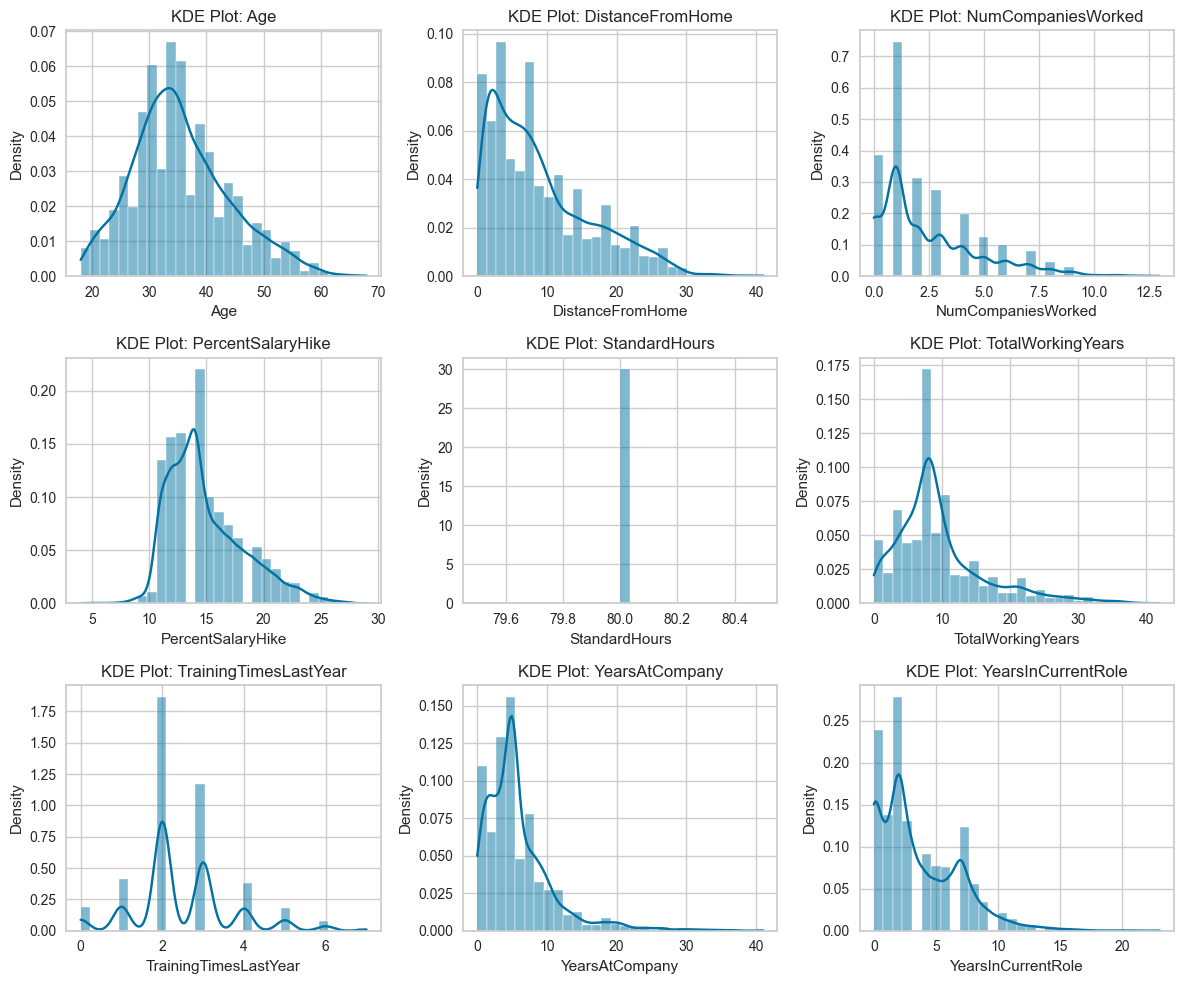

In [275]:
plot_kde_histograms(df_regression, numerical_cols)

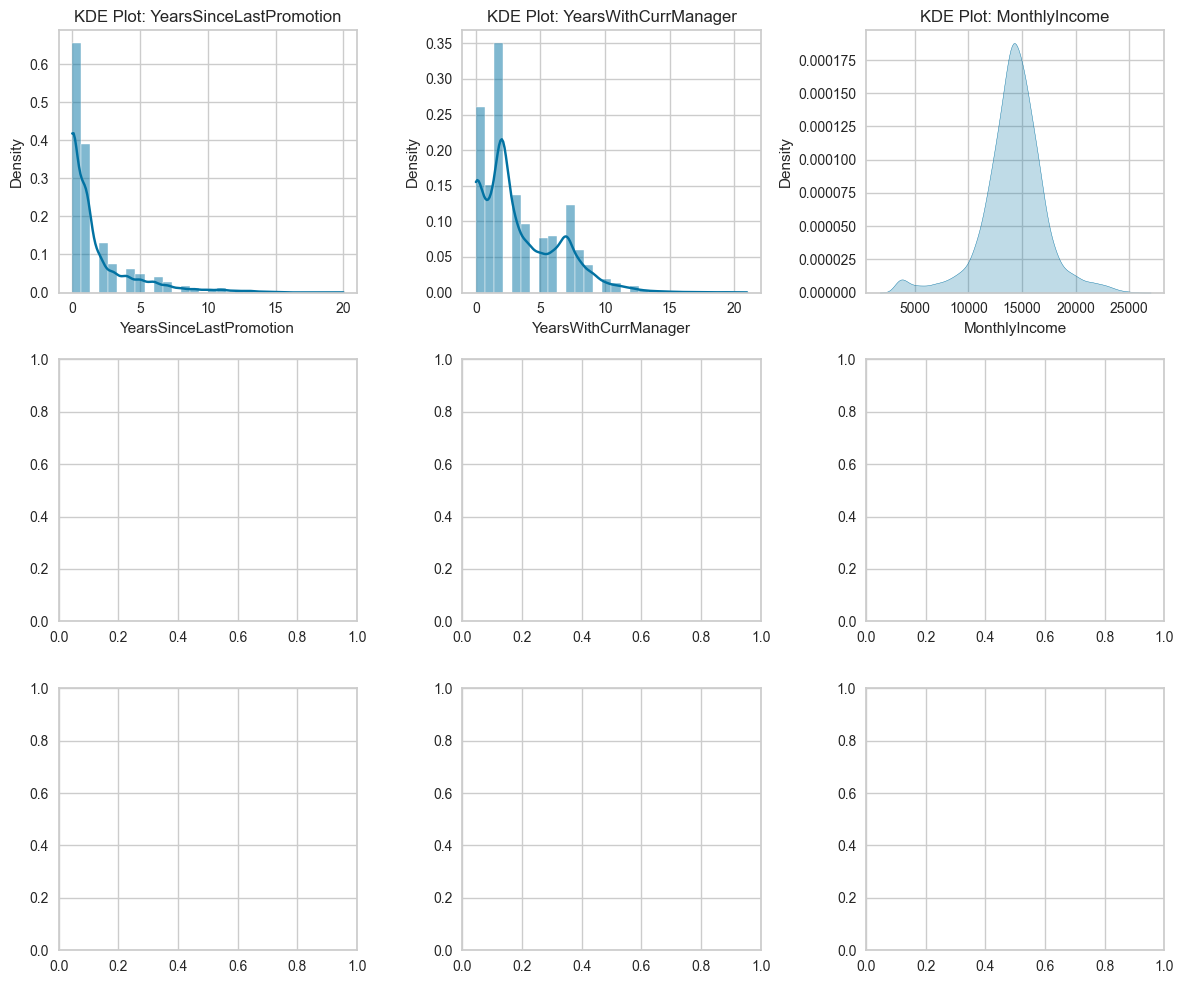

In [276]:
plot_kde_histograms(df_regression, ['YearsSinceLastPromotion','YearsWithCurrManager','MonthlyIncome'])

In [277]:
numerical_cols

['Age',
 'DistanceFromHome',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'StandardHours',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

Outlier tidak dihandle karena hanya akan menyebabkan hilangnya informasi sehingga menyebabkan performa model lebih buruk dibandingkan jika tidak dihandle.

In [278]:
# df_classif = winsorize_outliers(df_classif, numerical_cols)
# df_classif_test = winsorize_outliers(df_classif_test, numerical_cols)

Scaling digunakan agar distribusi data bersifat lebih normal.

In [279]:
#decent
df_regression = apply_scaling(df_regression, numerical_cols)
df_regression_test = apply_scaling(df_regression_test, numerical_cols)

# bad
# df_classif = log_transform(df_classif, numerical_cols)
# df_classif_test = log_transform(df_classif_test, numerical_cols)

# worse
# df_classif = standard_scale(df_classif, numerical_cols)
# df_classif_test = standard_scale(df_classif_test, numerical_cols)

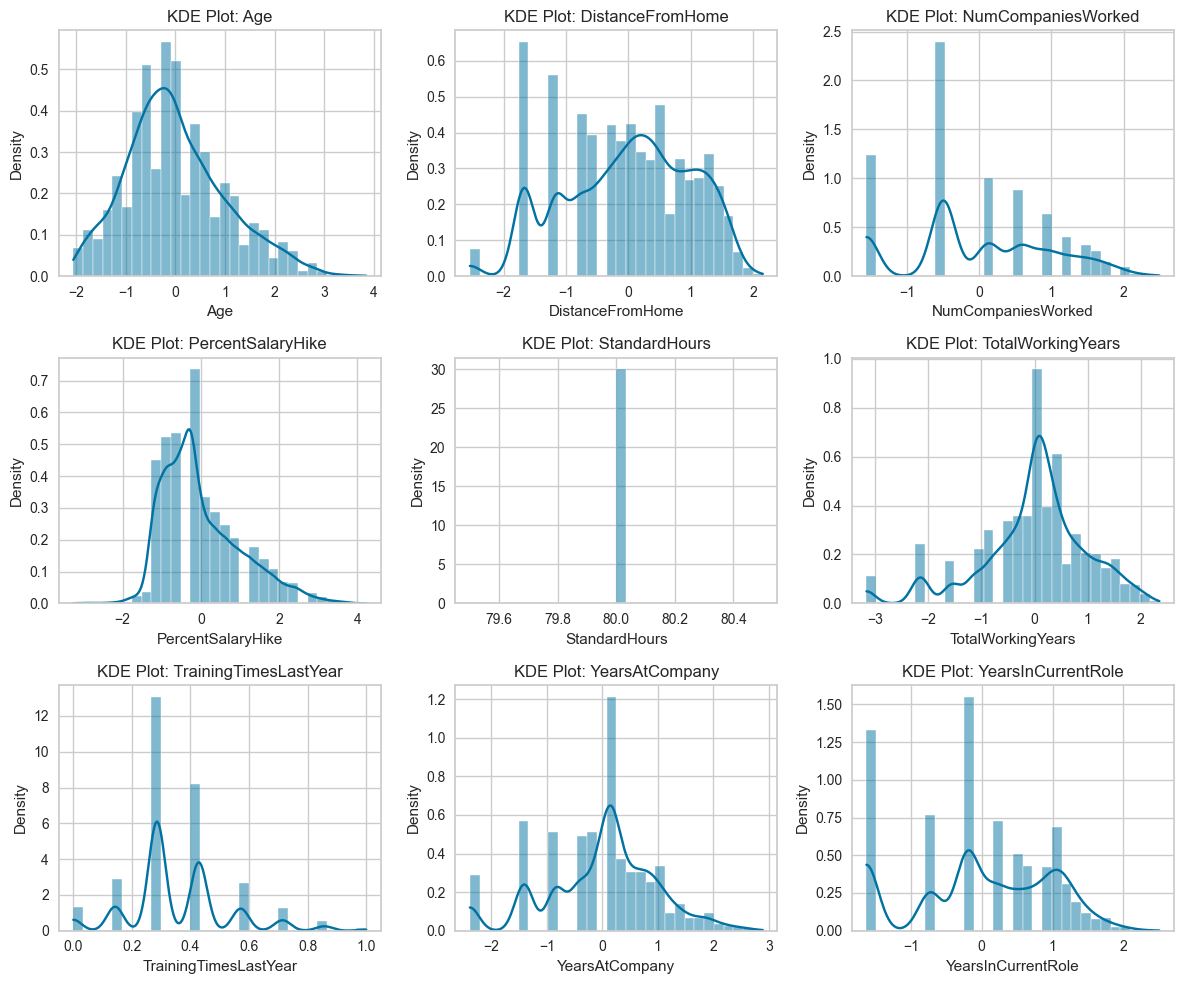

In [280]:
plot_kde_histograms(df_regression, numerical_cols)

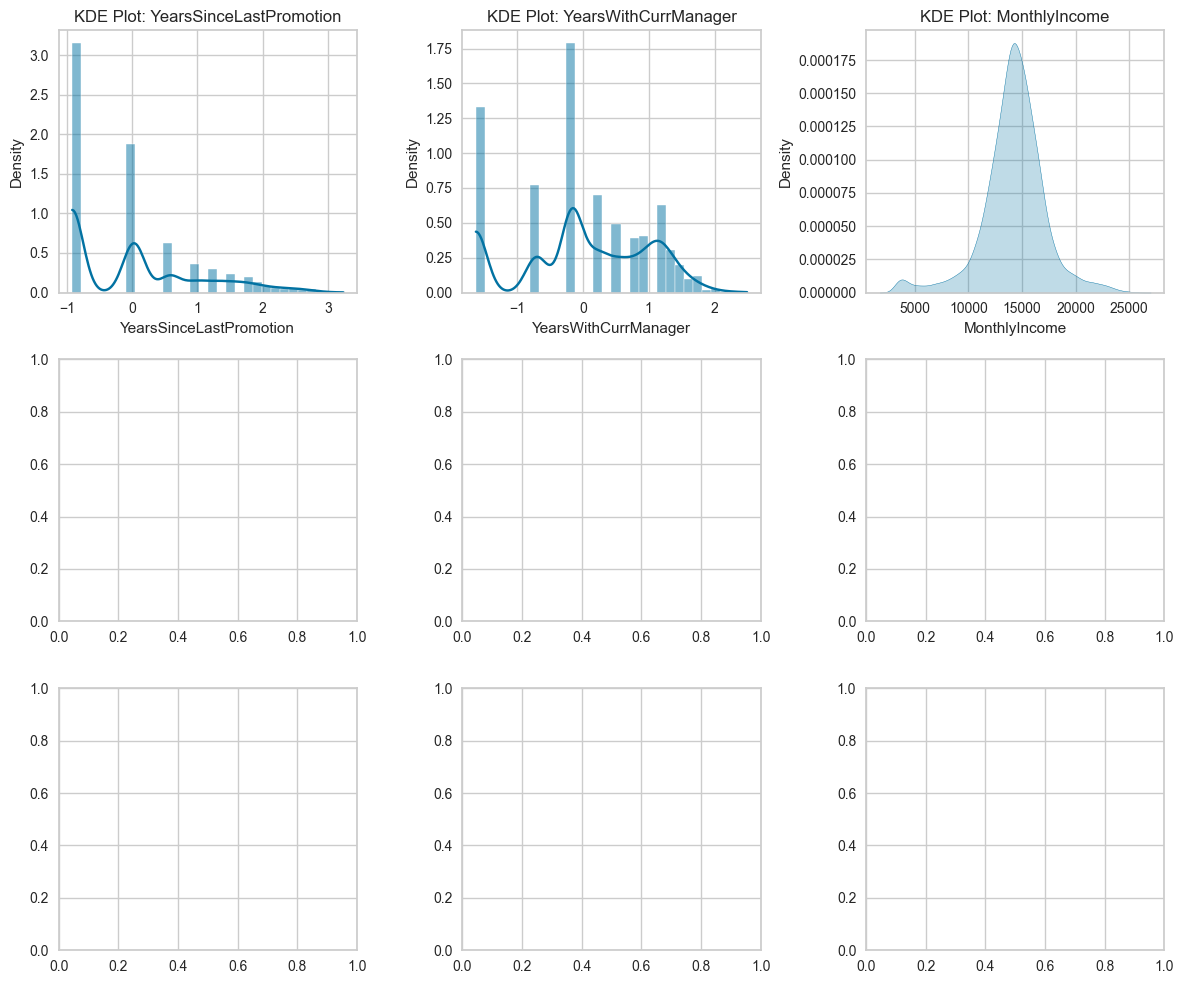

In [281]:
plot_kde_histograms(df_regression, ['YearsSinceLastPromotion','YearsWithCurrManager','MonthlyIncome'])

Ordinal cols diencode dengan label encoding untuk menunjukkan urutan, non-ordinal cols diencode dengan onehot encoding agar model tidak salah mengira bahwa terdapat urutan pada nilai di suatu kolom. Label diencode dengan label encoding dengan No bernilai 0 dan Yes bernilai 1.

In [282]:
import pandas as pd

# Define columns (same as before)
ordinal_cols = [
    'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobSatisfaction',
    'PerformanceRating', 'RelationshipSatisfaction', 'WorkLifeBalance',
    'JobLevel', 'StockOptionLevel'
]
non_ordinal_cols = [
    'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
    'MaritalStatus', 'OverTime', 'Attrition'
]
all_categorical_cols = ordinal_cols + non_ordinal_cols
all_categorical_cols_test = ordinal_cols + non_ordinal_cols

# Step 1: Impute missing values in categorical columns (already done)
df_regression = impute_values(df_regression, all_categorical_cols, strategy='mode')
df_regression_test = impute_values(df_regression_test, all_categorical_cols_test, strategy='mode')

# Step 2: Apply label encoding to ordinal columns and one-hot encoding to non-ordinal columns for df_regression
df_encoded, encoders = encode_categorical(df_regression, ordinal_cols, non_ordinal_cols)

# Step 3: Label encode the target column (Attrition) for df_regression
# df_encoded, target_encoder = label_encode(df_encoded, target_col)
# encoders.update(target_encoder)

# Step 4: Apply the same encoding to df_regression_test
# 4.1: Apply label encoding to ordinal columns using the same encoders
df_encoded_test = df_regression_test.copy()
for col in ordinal_cols:
    if col in encoders:
        mapping = encoders[col]
        if isinstance(mapping, dict):  # Custom mapping
            df_encoded_test[col] = df_encoded_test[col].map(mapping)
        else:  # LabelEncoder
            # Transform using the encoder, then add 1 to start from 1 (as per previous modification)
            df_encoded_test[col] = mapping.transform(df_encoded_test[col].astype(str)) + 1

# 4.2: Apply one-hot encoding to non-ordinal columns using get_dummies
df_encoded_test, _ = one_hot_encode(df_encoded_test, non_ordinal_cols)

# Align columns with df_encoded (to handle missing categories in test set)
missing_cols = set(df_encoded.columns) - set(df_encoded_test.columns) - set(target_col)
for col in missing_cols:
    df_encoded_test[col] = 0
# df_encoded_test = df_encoded_test[df_encoded.columns.drop(target_col)]  # Exclude target for alignment

# Print the first few rows of both DataFrames
print("Encoded Training Data (df_encoded):")
print(df_encoded.head())
print("\nEncoded Test Data (df_encoded_test):")
print(df_encoded_test.head())

# Print the encoders for reference
print("\nEncoders used:")
for col, encoder in encoders.items():
    print(f"{col}: {type(encoder)}")

Encoded Training Data (df_encoded):
        Age  DistanceFromHome  Education  EnvironmentSatisfaction  \
0 -0.878176         -0.519044          2                        3   
1 -1.232556          0.861400          0                        2   
2  0.066838         -0.799432          0                        1   
3  0.066838         -0.519044          2                        3   
4  0.303091          0.681589          2                        3   

   JobInvolvement  JobLevel  JobSatisfaction  NumCompaniesWorked  \
0               2         1                0            0.911948   
1               2         2                2           -1.560077   
2               1         2                1           -1.560077   
3               2         2                1            1.633852   
4               1         2                2            0.911948   

   PercentSalaryHike  PerformanceRating  ...  JobRole_Research Scientist  \
0          -1.162486                  1  ...                    

In [283]:
X_train_regression = df_encoded.drop(['MonthlyIncome'], axis=1)
y_train_regression = df_encoded['MonthlyIncome']
X_test_regression = df_encoded_test.drop(['MonthlyIncome'], axis=1)

In [284]:
X_train_regression['Attrition_No']

0       1.0
1       0.0
2       1.0
3       1.0
4       1.0
       ... 
7706    1.0
7707    1.0
7708    0.0
7709    1.0
7710    0.0
Name: Attrition_No, Length: 7711, dtype: float64

Dilakukan feature engineering agar model dapat memahami interaksi antar fitur dan memahami informasi yang penting untuk prediksi.

In [285]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

# Assume df_encoded and df_encoded_test are the DataFrames after preprocessing
# Columns as provided
columns = [
    'Age', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction',
    'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'NumCompaniesWorked',
    'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
    'StandardHours', 'StockOptionLevel', 'TotalWorkingYears',
    'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
    'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
    'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently',
    'BusinessTravel_Travel_Rarely', 'Department_Human Resources',
    'Department_Research & Development', 'Department_Sales',
    'EducationField_Human Resources', 'EducationField_Life Sciences',
    'EducationField_Marketing', 'EducationField_Medical',
    'EducationField_Other', 'EducationField_Technical Degree',
    'Gender_Female', 'Gender_Male', 'JobRole_Healthcare Representative',
    'JobRole_Human Resources', 'JobRole_Laboratory Technician',
    'JobRole_Manager', 'JobRole_Manufacturing Director',
    'JobRole_Research Director', 'JobRole_Research Scientist',
    'JobRole_Sales Executive', 'JobRole_Sales Representative',
    'MaritalStatus_Divorced', 'MaritalStatus_Married',
    'MaritalStatus_Single', 'OverTime_No', 'OverTime_Yes', 'Attrition_No',
    'Attrition_Yes'
]

import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

def feature_engineering(df):
    df_fe = df.copy()
    
    # 1. Interaction Features (Focus on Income-Related Interactions)
    df_fe['YearsAtCompany_JobLevel'] = df_fe['YearsAtCompany'] * df_fe['JobLevel']
    df_fe['TotalWorkingYears_JobLevel'] = df_fe['TotalWorkingYears'] * df_fe['JobLevel']
    df_fe['Attrition_JobLevel'] = df_fe['Attrition_Yes'] * df_fe['JobLevel']  # Interaction with Attrition_Yes
    df_fe['Attrition_YearsAtCompany'] = df_fe['Attrition_Yes'] * df_fe['YearsAtCompany']  # Impact of tenure for those who left
    
    # New Interactions with Attrition_No
    df_fe['AttritionNo_JobLevel'] = df_fe['Attrition_No'] * df_fe['JobLevel']  # Interaction for those who stayed
    df_fe['AttritionNo_YearsAtCompany'] = df_fe['Attrition_No'] * df_fe['YearsAtCompany']  # Tenure impact for those who stayed
    df_fe['AttritionNo_Satisfaction'] = df_fe['Attrition_No'] * df_fe['EnvironmentSatisfaction']  # Satisfaction impact for those who stayed
    
    # 2. Binned Features
    # Bin Age into categories (potentially correlated with income)
    age_bins = [0, 30, 40, 50, 100]
    age_labels = ['Under_30', '30_to_40', '40_to_50', 'Over_50']
    df_fe['Age_Binned'] = pd.cut(df_fe['Age'], bins=age_bins, labels=age_labels, include_lowest=True)
    age_binned_encoded = pd.get_dummies(df_fe['Age_Binned'], prefix='Age')
    df_fe = pd.concat([df_fe, age_binned_encoded], axis=1)
    df_fe = df_fe.drop('Age_Binned', axis=1)
    
    # Bin TotalWorkingYears into quartiles (experience might predict income)
    df_fe['TotalWorkingYears_Binned'] = pd.qcut(df_fe['TotalWorkingYears'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    twy_binned_encoded = pd.get_dummies(df_fe['TotalWorkingYears_Binned'], prefix='TotalWorkingYears')
    df_fe = pd.concat([df_fe, twy_binned_encoded], axis=1)
    df_fe = df_fe.drop('TotalWorkingYears_Binned', axis=1)
    
    # 3. Ratio Features (Adjust for Income Prediction)
    # Avoid division by zero by adding a small constant
    df_fe['YearsInCurrentRole_to_YearsAtCompany'] = df_fe['YearsInCurrentRole'] / (df_fe['YearsAtCompany'] + 1e-10)
    df_fe['YearsSinceLastPromotion_to_YearsAtCompany'] = df_fe['YearsSinceLastPromotion'] / (df_fe['YearsAtCompany'] + 1e-10)
    
    # 4. Aggregation of Time-Related Features
    df_fe['YearsWorkedElsewhere'] = df_fe['TotalWorkingYears'] - df_fe['YearsAtCompany']
    df_fe['YearsWorkedElsewhere'] = df_fe['YearsWorkedElsewhere'].clip(lower=0)
    
    # 5. Group Rare Categories (for JobRole)
    jobrole_cols = [
        'JobRole_Healthcare Representative', 'JobRole_Human Resources',
        'JobRole_Laboratory Technician', 'JobRole_Manager',
        'JobRole_Manufacturing Director', 'JobRole_Research Director',
        'JobRole_Research Scientist', 'JobRole_Sales Executive',
        'JobRole_Sales Representative'
    ]
    jobrole_sums = df_fe[jobrole_cols].sum()
    threshold = 0.05 * len(df_fe)
    rare_jobroles = jobrole_sums[jobrole_sums < threshold].index
    df_fe['JobRole_Other'] = df_fe[rare_jobroles].sum(axis=1)
    df_fe = df_fe.drop(columns=rare_jobroles)
    remaining_jobroles = [col for col in jobrole_cols if col not in rare_jobroles]
    for col in remaining_jobroles:
        df_fe.loc[df_fe['JobRole_Other'] == 1, col] = 0
    
    # 6. Polynomial Features (for TotalWorkingYears, as experience often has non-linear effects on income)
    poly = PolynomialFeatures(degree=2, include_bias=False)
    twy_poly = poly.fit_transform(df_fe[['TotalWorkingYears']])
    df_fe['TotalWorkingYears_Squared'] = twy_poly[:, 1]  # Squared term
    
    # Polynomial for YearsAtCompany (retained from original)
    years_at_company_poly = poly.fit_transform(df_fe[['YearsAtCompany']])
    df_fe['YearsAtCompany_Squared'] = years_at_company_poly[:, 1]
    
    # 7. Drop Constant Columns
    if 'StandardHours' in df_fe.columns:
        df_fe = df_fe.drop('StandardHours', axis=1)
    
    # 8. Satisfaction Score (average of satisfaction metrics, might correlate with income)
    satisfaction_cols = ['EnvironmentSatisfaction', 'JobSatisfaction', 'RelationshipSatisfaction']
    df_fe['Satisfaction_Score'] = df_fe[satisfaction_cols].mean(axis=1)
    
    # 9. Career Stagnation (retained, as lack of promotion might affect income growth)
    df_fe['Career_Stagnation'] = df_fe['YearsSinceLastPromotion'] / (df_fe['YearsAtCompany'] + 1e-10)
    
    # 10. Education and JobLevel Interaction (higher education and level might predict higher income)
    df_fe['Education_JobLevel'] = df_fe['Education'] * df_fe['JobLevel']
    
    return df_fe

# Apply feature engineering to both training and test sets
X_train_regression = feature_engineering(X_train_regression)
X_test_regression = feature_engineering(X_test_regression)

# Print the new columns added
print("New columns added after feature engineering:")
new_cols = set(X_train_regression.columns) - set(columns)
print(new_cols)

# Print the first few rows of the feature-engineered training DataFrame
print("\nFeature-engineered Training Data (X_train_regression):")
print(X_train_regression.head())

New columns added after feature engineering:
{'YearsAtCompany_JobLevel', 'JobRole_Other', 'YearsWorkedElsewhere', 'Attrition_YearsAtCompany', 'YearsSinceLastPromotion_to_YearsAtCompany', 'TotalWorkingYears_Q3', 'AttritionNo_JobLevel', 'AttritionNo_Satisfaction', 'Age_30_to_40', 'Age_40_to_50', 'AttritionNo_YearsAtCompany', 'TotalWorkingYears_Q4', 'TotalWorkingYears_Squared', 'Attrition_JobLevel', 'Age_Over_50', 'Age_Under_30', 'TotalWorkingYears_Q1', 'Satisfaction_Score', 'YearsInCurrentRole_to_YearsAtCompany', 'YearsAtCompany_Squared', 'Education_JobLevel', 'Career_Stagnation', 'TotalWorkingYears_JobLevel', 'TotalWorkingYears_Q2'}

Feature-engineered Training Data (X_train_regression):
        Age  DistanceFromHome  Education  EnvironmentSatisfaction  \
0 -0.878176         -0.519044          2                        3   
1 -1.232556          0.861400          0                        2   
2  0.066838         -0.799432          0                        1   
3  0.066838         -0.51904

Pilih beberapa fitur yang memiliki importance paling tinggi. Hal ini karena apabila semua fitur diambil akan menyebabkan terlalu banyak noise  yang menyebabkan overfitting.

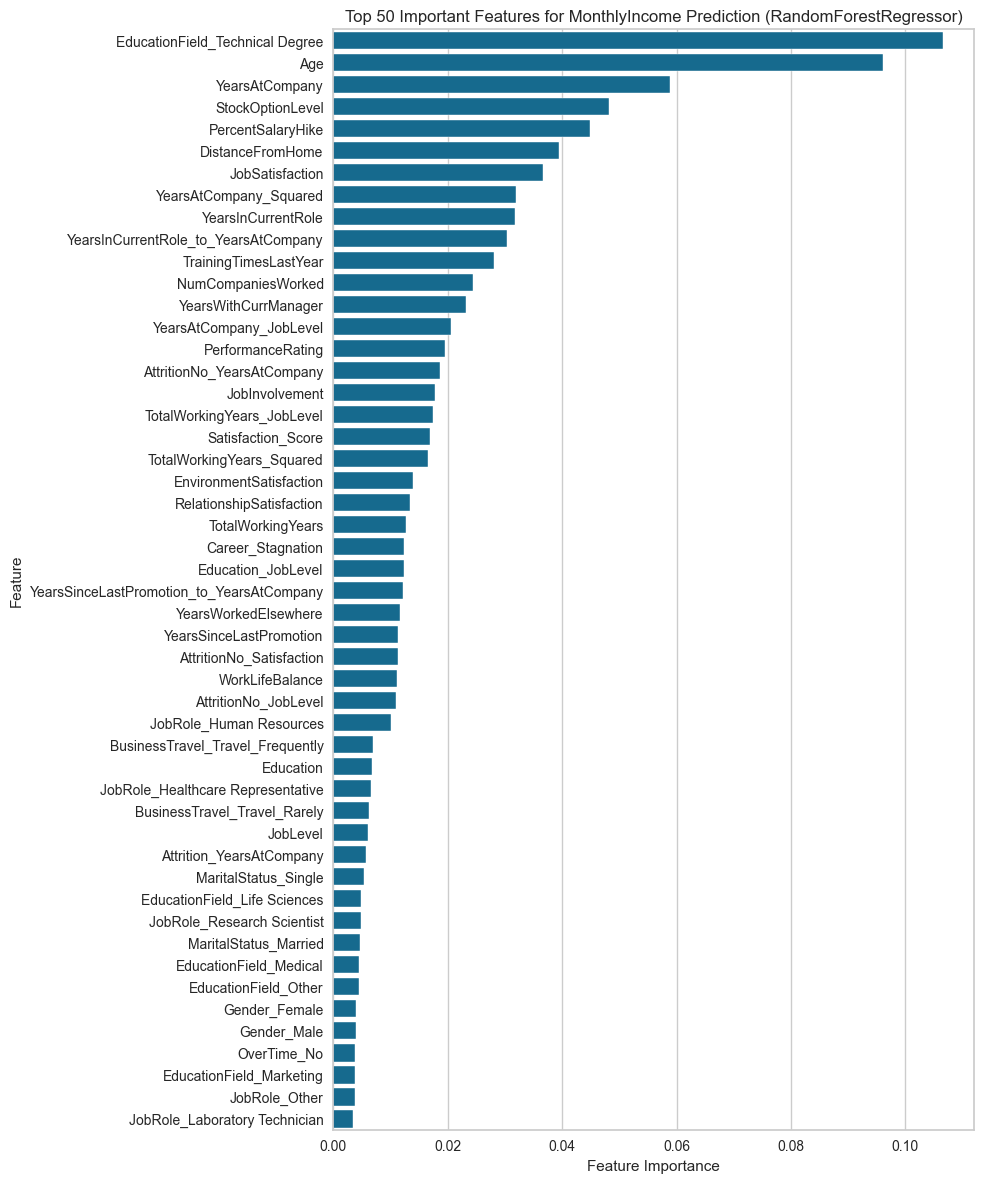

Selected Top 35 Features:
['EducationField_Technical Degree', 'Age', 'YearsAtCompany', 'StockOptionLevel', 'PercentSalaryHike', 'DistanceFromHome', 'JobSatisfaction', 'YearsAtCompany_Squared', 'YearsInCurrentRole', 'YearsInCurrentRole_to_YearsAtCompany', 'TrainingTimesLastYear', 'NumCompaniesWorked', 'YearsWithCurrManager', 'YearsAtCompany_JobLevel', 'PerformanceRating', 'AttritionNo_YearsAtCompany', 'JobInvolvement', 'TotalWorkingYears_JobLevel', 'Satisfaction_Score', 'TotalWorkingYears_Squared', 'EnvironmentSatisfaction', 'RelationshipSatisfaction', 'TotalWorkingYears', 'Career_Stagnation', 'Education_JobLevel', 'YearsSinceLastPromotion_to_YearsAtCompany', 'YearsWorkedElsewhere', 'YearsSinceLastPromotion', 'AttritionNo_Satisfaction', 'WorkLifeBalance', 'AttritionNo_JobLevel', 'JobRole_Human Resources', 'BusinessTravel_Travel_Frequently', 'Education', 'JobRole_Healthcare Representative']
Shape of X_train_regression: (7711, 35)
Shape of X_test_regression: (1286, 35)


In [286]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Fit a RandomForestRegressor on all features
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_regression, y_train_regression)

# Step 2: Get and sort feature importances
importances = rf.feature_importances_
feature_names = X_train_regression.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Step 3: Plot top 50 features
plt.figure(figsize=(10, 12))  # Adjusted height for better visibility
sns.barplot(x='importance', y='feature', data=importance_df.head(50))
plt.title("Top 50 Important Features for MonthlyIncome Prediction (RandomForestRegressor)")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Step 4: Select top 35 important features
top_features = importance_df.head(35)['feature'].tolist()
X_train_regression = X_train_regression[top_features]
X_test_regression = X_test_regression[top_features]

# Verify the selected features
print(f"Selected Top 35 Features:\n{top_features}")
print(f"Shape of X_train_regression: {X_train_regression.shape}")
print(f"Shape of X_test_regression: {X_test_regression.shape}")

Dipilih top 35, hal ini karena kalo dipilih semua ternyata kebanyakan noise yang ditangkap sehingga menyebabkan ada misclassification/class noise dan juga untuk mengurangi resiko overfitting.

Modelling dilakukan dengan RandomizedSearchCV untuk mencari hyperparameter terbaik. Diujikan juga ensemble 3 model terbaik untuk membandingkan performa terhadap model terbaik.

In [287]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_predict, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import pandas as pd
import numpy as np

cv = KFold(n_splits=5, shuffle=True, random_state=42)

regression_models = {
    "LinearRegression": (
        LinearRegression(),
        {}
    ),
    "Ridge": (
        Ridge(random_state=42),
        {'alpha': [0.1, 1.0, 10.0]}
    ),
    "Lasso": (
        Lasso(random_state=42),
        {'alpha': [0.001, 0.01, 0.1, 1.0]}
    ),
    "ElasticNet": (
        ElasticNet(random_state=42),
        {
            'alpha': [0.001, 0.01, 0.1, 1.0],
            'l1_ratio': [0.1, 0.5, 0.9]
        }
    ),
    "RandomForest": (
        RandomForestRegressor(random_state=42),
        {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20]
        }
    ),
    "GradientBoosting": (
        GradientBoostingRegressor(random_state=42),
        {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    ),
    "ExtraTrees": (
        ExtraTreesRegressor(random_state=42),
        {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20]
        }
    ),
    "KNN": (
        KNeighborsRegressor(),
        {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance']
        }
    ),
    "LightGBM": (
        LGBMRegressor(random_state=42),
        {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [-1, 10, 20]
        }
    ),
    "XGBoost": (
        XGBRegressor(random_state=42),
        {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 6, 10]
        }
    ),
    "CatBoost": (
        CatBoostRegressor(verbose=0, random_state=42),
        {
            'iterations': [100, 200],
            'depth': [4, 6, 8],
            'learning_rate': [0.01, 0.1]
        }
    ),
    "MLPRegressor": (
        MLPRegressor(max_iter=1000, random_state=42),
        {
            'hidden_layer_sizes': [(50,), (100,), (100, 50)],
            'activation': ['tanh', 'relu'],
            'alpha': [0.0001, 0.001],
            'learning_rate': ['constant', 'adaptive']
        }
    ),
}

regression_results = {}

for name, (model, param_dist) in regression_models.items():
    print(f"🔍 Tuning {name}...")
    search = RandomizedSearchCV(
        model,
        param_distributions=param_dist,
        n_iter=10,
        scoring='r2',
        refit=True,
        cv=cv,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train_regression, y_train_regression)
    best_model = search.best_estimator_

    preds = cross_val_predict(best_model, X_train_regression, y_train_regression, cv=cv, n_jobs=-1)

    regression_results[name] = {
        "r2": r2_score(y_train_regression, preds),
        "mae": mean_absolute_error(y_train_regression, preds),
        "mse": mean_squared_error(y_train_regression, preds),
        "rmse": root_mean_squared_error(y_train_regression, preds)
    }

# Display sorted by R²
regression_df = pd.DataFrame(regression_results).T.sort_values("r2", ascending=False)
print("\n📊 Regression Model Performance:\n", regression_df)


🔍 Tuning LinearRegression...


C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


🔍 Tuning Ridge...


C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


🔍 Tuning Lasso...


C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


🔍 Tuning ElasticNet...


C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.359e+10, tolerance: 6.771e+06
  model = cd_fast.enet_coordinate_descent(


🔍 Tuning RandomForest...


C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


🔍 Tuning GradientBoosting...


C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


🔍 Tuning ExtraTrees...


C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


🔍 Tuning KNN...


C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


🔍 Tuning LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1512
[LightGBM] [Info] Number of data points in the train set: 7711, number of used features: 35
[LightGBM] [Info] Start training from score 14210.009599
🔍 Tuning XGBoost...
🔍 Tuning CatBoost...
🔍 Tuning MLPRegressor...


C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



📊 Regression Model Performance:
                         r2          mae           mse         rmse
XGBoost           0.741351  1029.483380  2.271241e+06  1507.063706
ExtraTrees        0.714220  1083.025093  2.509483e+06  1584.134904
LightGBM          0.710333  1100.878121  2.543619e+06  1594.872817
RandomForest      0.696181  1119.286940  2.667894e+06  1633.368968
CatBoost          0.685809  1151.664400  2.758970e+06  1661.014604
GradientBoosting  0.683735  1162.568394  2.777184e+06  1666.488444
KNN               0.484401  1540.039719  4.527574e+06  2127.809644
MLPRegressor      0.471174  1579.542233  4.643717e+06  2154.928515
Lasso             0.214013  1917.252467  6.901899e+06  2627.146563
ElasticNet        0.213927  1917.409501  6.902656e+06  2627.290672
Ridge             0.213923  1917.519441  6.902689e+06  2627.296908
LinearRegression  0.213914  1917.582335  6.902765e+06  2627.311336


In [288]:
# Get top 3 models by R²
top_3_names = regression_df.head(3).index.tolist()

# Storage for final models and metrics
final_models = {}
final_metrics = {}

print("\n🔁 Performing KFold CV and RandomizedSearchCV on Top 3 Models:\n")

for name in top_3_names:
    print(f"🚀 {name}")
    model, param_dist = regression_models[name]

    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=10,
        scoring='r2',
        refit=True,
        cv=cv,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train_regression, y_train_regression)
    best_model = search.best_estimator_

    preds = cross_val_predict(best_model, X_train_regression, y_train_regression, cv=cv, n_jobs=-1)

    final_metrics[name] = {
        "r2": r2_score(y_train_regression, preds),
        "mae": mean_absolute_error(y_train_regression, preds),
        "mse": mean_squared_error(y_train_regression, preds),
        "rmse": mean_squared_error(y_train_regression, preds)
    }

    final_models[name] = best_model

# Results
final_df = pd.DataFrame(final_metrics).T.sort_values("r2", ascending=False)
print("\n📈 Final Top 3 Model Performance (with tuned hyperparameters):\n")
print(final_df)


🔁 Performing KFold CV and RandomizedSearchCV on Top 3 Models:

🚀 XGBoost
🚀 ExtraTrees


C:\Users\Fikri Budianto\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


🚀 LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1512
[LightGBM] [Info] Number of data points in the train set: 7711, number of used features: 35
[LightGBM] [Info] Start training from score 14210.009599

📈 Final Top 3 Model Performance (with tuned hyperparameters):

                  r2          mae           mse          rmse
XGBoost     0.741351  1029.483380  2.271241e+06  2.271241e+06
ExtraTrees  0.714220  1083.025093  2.509483e+06  2.509483e+06
LightGBM    0.710333  1100.878121  2.543619e+06  2.543619e+06


In [289]:
from sklearn.ensemble import VotingRegressor

# Ensure top 3 models are retrieved and fitted from previous step
print("\n🔗 Building VotingRegressor with Top 3 Models...\n")

# Create a list of (name, model) tuples
ensemble_estimators = [(name, final_models[name]) for name in top_3_names]

# Initialize Voting Regressor
voting_reg = VotingRegressor(estimators=ensemble_estimators, n_jobs=-1)

# Fit on full training data
voting_reg.fit(X_train_regression, y_train_regression)

# Cross-validated predictions
voting_preds = cross_val_predict(voting_reg, X_train_regression, y_train_regression, cv=cv, n_jobs=-1)

# Compute performance metrics
ensemble_metrics = {
    "r2": r2_score(y_train_regression, voting_preds),
    "mae": mean_absolute_error(y_train_regression, voting_preds),
    "mse": mean_squared_error(y_train_regression, voting_preds),
    "rmse": root_mean_squared_error(y_train_regression, voting_preds)
}

# Add to final results
final_df.loc["VotingEnsemble"] = ensemble_metrics

# Display updated table
final_df = final_df.sort_values("r2", ascending=False)
print("\n🏁 Final Performance Including Ensemble:\n")
print(final_df)


🔗 Building VotingRegressor with Top 3 Models...


🏁 Final Performance Including Ensemble:

                      r2          mae           mse          rmse
VotingEnsemble  0.747628  1000.328311  2.216125e+06  1.488666e+03
XGBoost         0.741351  1029.483380  2.271241e+06  2.271241e+06
ExtraTrees      0.714220  1083.025093  2.509483e+06  2.509483e+06
LightGBM        0.710333  1100.878121  2.543619e+06  2.543619e+06


In [290]:
import pandas as pd

# Load test data
df_regression_test = pd.read_csv("employee_test_regress.csv")

# Use ID column if exists, otherwise create synthetic IDs
if 'ID' in df_regression_test.columns:
    ids = df_regression_test['ID']
else:
    ids = [f"S{i+1}" for i in range(len(df_regression_test))]

# Predict with best individual model
best_model_name = final_df.index[1]
best_model = final_models[best_model_name]
pred_best = best_model.predict(X_test_regression)
pred_best = pd.Series(pred_best).clip(lower=0)

# Predict with Voting Ensemble
pred_ensemble = voting_reg.predict(X_test_regression)
pred_ensemble = pd.Series(pred_ensemble).clip(lower=0)

# Create DataFrames
submission_best = pd.DataFrame({
    "ID": ids,
    "MonthlyIncome": pred_best
})

submission_ensemble = pd.DataFrame({
    "ID": ids,
    "MonthlyIncome": pred_ensemble
})

# Save to separate CSVs
submission_best.to_csv(f"{best_model_name}_prediction.csv", index=False)
submission_ensemble.to_csv("voting_ensemble_prediction.csv", index=False)

print(f"✅ {best_model_name}_prediction.csv and voting_ensemble_prediction.csv saved successfully.")

✅ XGBoost_prediction.csv and voting_ensemble_prediction.csv saved successfully.


In [291]:
final_models

{'XGBoost': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...),
 'ExtraTrees': ExtraTreesRegressor(n_estimators=200, random_state=42),
 'LightGBM': LGBMRegressor(max_depth=20, n_estimators=200, random_state=42)}

### Clustering

In [292]:
import pandas as pd

df_original = pd.read_csv('employee_train.csv')
df_original = df_original.drop(['ID'], axis=1)

In [293]:
# Get categorical cols
categorical_cols = df_original.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical cols:")
print(categorical_cols)

# Get numerical cols (should use 'number' instead)
numerical_cols = df_original.select_dtypes(include=['number']).columns.tolist()
print("\nNumerical cols:")
print(numerical_cols)

Categorical cols:
['BusinessTravel', 'Department', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'OverTime', 'PerformanceRating', 'RelationshipSatisfaction', 'WorkLifeBalance', 'Attrition']

Numerical cols:
['Age', 'DistanceFromHome', 'JobLevel', 'NumCompaniesWorked', 'PercentSalaryHike', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'MonthlyIncome']


In [294]:
#menghilangkan nilai negatif agar tidak ada data yang bias
for col in numerical_cols:
    df_original[col] = df_original[col].abs()

In [295]:
df_original.head()

Age     BusinessTravel              Department  DistanceFromHome  \
0   28      Travel_Rarely  Research & Development                 4   
1   25  Travel_Frequently                   Sales                14   
2   36      Travel_Rarely  Research & Development                 3   
3   36  Travel_Frequently  Research & Development                 4   
4   38  Travel_Frequently  Research & Development                12   

       Education EducationField EnvironmentSatisfaction Gender JobInvolvement  \
0            NaN          Other               Very High   Male           High   
1  Below College      Marketing                    High   Male           High   
2  Below College      Marketing                  Medium   Male         Medium   
3            NaN  Life Sciences               Very High   Male           High   
4       Bachelor  Life Sciences               Very High   Male         Medium   

   JobLevel  ... StockOptionLevel TotalWorkingYears TrainingTimesLastYear  \
0         1  ...                0               NaN                     4   
1         2  ...                0               6.0                     2   
2         2  ...                1              10.0                     3   
3         2  ...                3              18.0                     3   
4         2  ...                0               NaN                     4   

   WorkLifeBalance YearsAtCompany  YearsInCurrentRole YearsSinceLastPromotion  \
0             Good            4.0                   1                     0.0   
1             Good            NaN                   4                     1.0   
2              Bad            9.0                   4                     1.0   
3           Better            4.0                   2                     0.0   
4             Good            NaN                   3                     1.0   

  YearsWithCurrManager  MonthlyIncome  Attrition  
0                  NaN       14115.06         No  
1                  4.0       16661.93        Yes  
2                  4.0       13178.42         No  
3                  2.0       13601.03         No  
4                  3.0       15419.15         No  

[5 rows x 29 columns]

Beberapa kolom yang sebenarnya kolom kategorikal tetapi nilainya berbentuk integer dijadikan string lalu dimasukkan ke categorical cols untuk menghindari salah interpretasi oleh model.

In [296]:
# Add to categorical_cols
categorical_cols += ['JobLevel', 'StockOptionLevel']

# Remove from numerical_cols
numerical_cols = [col for col in numerical_cols if col not in ['JobLevel', 'StockOptionLevel']]

Handle missing values dengan mode untuk kategorikal dan median untuk numerikal karena data numerikal bersifat skewed.

In [297]:
df_original = impute_values(df_original, numerical_cols, 'median')
df_original = impute_values(df_original, categorical_cols, 'mode')

In [298]:
df_original.isnull().sum()

Age                         0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EnvironmentSatisfaction     0
Gender                      0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
NumCompaniesWorked          0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
MonthlyIncome               0
Attrition                   0
dtype: int64

Data umur dibawah 18 tahun dianggap salah input sehingga digantikan dengan median.

In [299]:
# Step 1: Count rows where Age < 18 before replacement
num_invalid_age = df_original.loc[df_original['Age'] < 18].shape[0]
print(f"Number of rows with Age < 18 before replacement: {num_invalid_age}")

# Step 2: Compute median Age (excluding invalid values)
# Only use Age >= 18 to calculate the median to avoid skewing it with invalid values
median_age = df_original.loc[df_original['Age'] >= 18, 'Age'].median()
print(f"Median Age (for Age >= 18): {median_age}")

# Step 3: Replace Age < 18 with the median
df_original.loc[df_original['Age'] < 18, 'Age'] = median_age

# Step 4: Verify the replacement
num_invalid_age_after = df_original.loc[df_original['Age'] < 18].shape[0]
print(f"Number of rows with Age < 18 after replacement: {num_invalid_age_after}")

Number of rows with Age < 18 before replacement: 2
Median Age (for Age >= 18): 34.0
Number of rows with Age < 18 after replacement: 0


Encoding

In [300]:
for col in categorical_cols:
    print(f"{col}: {df_original[col].unique()}")

BusinessTravel: ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
Department: ['Research & Development' 'Sales' 'Human Resources']
Education: ['Bachelor' 'Below College' 'Master' 'College' 'Doctor']
EducationField: ['Other' 'Marketing' 'Life Sciences' 'Medical' 'Human Resources'
 'Technical Degree']
EnvironmentSatisfaction: ['Very High' 'High' 'Medium' 'Low']
Gender: ['Male' 'Female']
JobInvolvement: ['High' 'Medium' 'Very High' 'Low']
JobRole: ['Research Scientist' 'Sales Executive' 'Manufacturing Director'
 'Research Director' 'Manager' 'Human Resources' 'Laboratory Technician'
 'Sales Representative' 'Healthcare Representative']
JobSatisfaction: ['Low' 'High' 'Medium' 'Very High']
MaritalStatus: ['Single' 'Married' 'Divorced']
OverTime: ['No' 'Yes']
PerformanceRating: ['Excellent' 'Good' 'Outstanding']
RelationshipSatisfaction: ['Medium' 'High' 'Very High' 'Low']
WorkLifeBalance: ['Good' 'Bad' 'Better' 'Best']
Attrition: ['No' 'Yes']
JobLevel: [1 2 4 5 3 0]
StockOptionLevel: [0 1 3

Encoding dilakukan pada semua kolom dengan melakukan label encoding pada semua kolom. Label encoding dipilih agar kolom tidak menjadi terlalu banyak untuk memudahkan visualisasi.

In [301]:
default_mappings = {
    'Education': ['Below College', 'College', 'Bachelor', 'Master', 'Doctor'],
    'EnvironmentSatisfaction': ['Low', 'Medium', 'High', 'Very High'],
    'JobInvolvement': ['Low', 'Medium', 'High', 'Very High'],
    'JobSatisfaction': ['Low', 'Medium', 'High', 'Very High'],
    'PerformanceRating': ['Good', 'Excellent', 'Outstanding'],
    'RelationshipSatisfaction': ['Low', 'Medium', 'High', 'Very High'],
    'WorkLifeBalance': ['Bad', 'Better', 'Good', 'Best'],
    'JobLevel': [0, 1, 2, 3, 4, 5],
    'StockOptionLevel': [0, 1, 2, 3, 4],

    # Tambahan kolom
    'BusinessTravel': ['Non-Travel', 'Travel_Rarely', 'Travel_Frequently'],
    'Department': ['Human Resources', 'Research & Development', 'Sales'],
    'EducationField': ['Other', 'Human Resources', 'Marketing', 'Life Sciences', 'Medical', 'Technical Degree'],
    'Gender': ['Female', 'Male'],
    'JobRole': [
        'Healthcare Representative',
        'Human Resources',
        'Laboratory Technician',
        'Manager',
        'Manufacturing Director',
        'Research Director',
        'Research Scientist',
        'Sales Executive',
        'Sales Representative'
    ],
    'MaritalStatus': ['Divorced', 'Married', 'Single'],
    'OverTime': ['No', 'Yes'],
    'Attrition': ['No', 'Yes']
}

# Lakukan label encoding berdasarkan default_mappings
for col, categories in default_mappings.items():
    if col in df_original.columns:
        mapping = {label: idx for idx, label in enumerate(categories)}
        df_original[col] = df_original[col].map(mapping)

In [302]:
df_clustering = df_original.copy()

Scaling

Scaling digunakan agar distribusi data berada pada skala yang sama.

In [303]:
cols = df_clustering.columns
df_clustering = minmax_scale(df_clustering, cols)

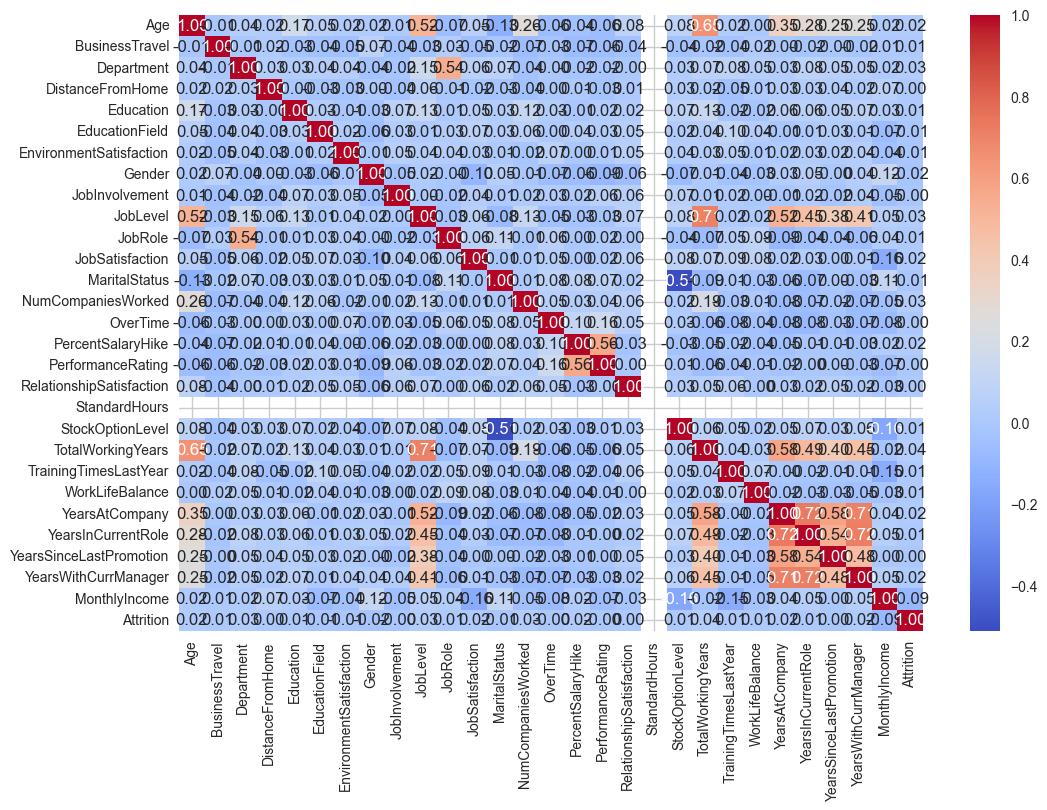

In [304]:
cols = df_clustering.columns
show_corr(df_clustering, cols)

'MonthlyIncome', 'TrainingTimesLastYear', 'PerformanceRating' dipilih untuk mencari hubungan antara pendapatan, jumlah pelatihan, dengan rating performa.

In [305]:
df_selected = df_clustering[['MonthlyIncome', 'TrainingTimesLastYear', 'PerformanceRating']]

In [306]:
# Menghitung silhouette coefficient untuk beberapa nilai k
print("Compare nilai silhouete coefficient")
print("=================================================")
for k in range(2,7):
    clusterer = KMeans(n_clusters=k, n_init=10, random_state=42)
    cluster_labels = clusterer.fit_predict(df_selected)
    silhouette_avg = silhouette_score(df_selected, cluster_labels, random_state=42)
    print(f"Untuk k = {k}, rata-rata silhouette_coefficient adalah: {silhouette_avg:.4f}")

Compare nilai silhouete coefficient
Untuk k = 2, rata-rata silhouette_coefficient adalah: 0.3326
Untuk k = 3, rata-rata silhouette_coefficient adalah: 0.3946
Untuk k = 4, rata-rata silhouette_coefficient adalah: 0.3507
Untuk k = 5, rata-rata silhouette_coefficient adalah: 0.3433
Untuk k = 6, rata-rata silhouette_coefficient adalah: 0.3723


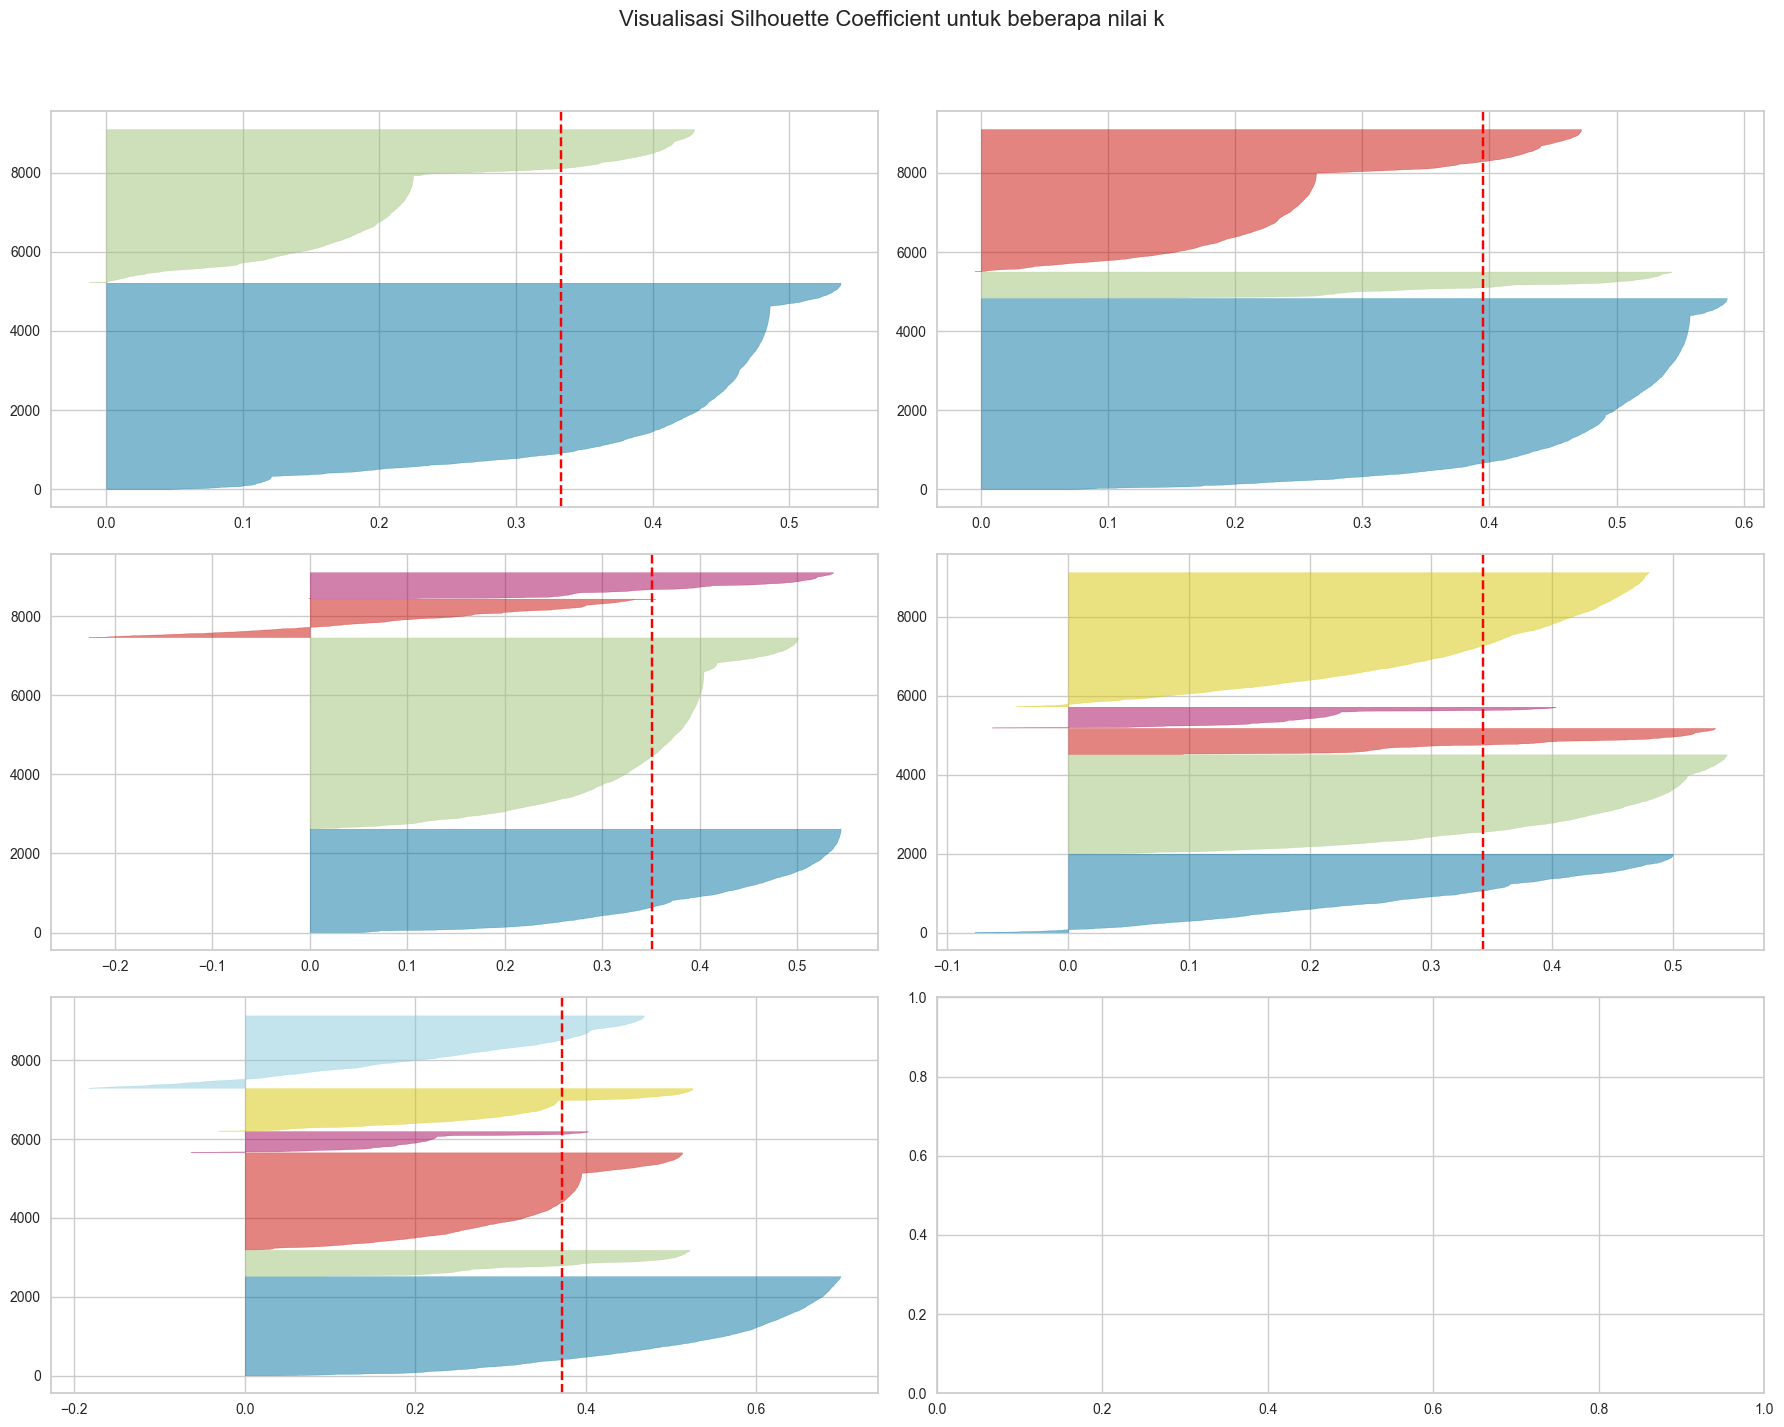

In [307]:
# Visualisasi silhouette coefficient
fig, ax = plt.subplots(3, 2, figsize=(18, 15))
fig.suptitle("Visualisasi Silhouette Coefficient untuk beberapa nilai k", fontsize=16)
k_values = range(2, 7)
for idx, k in enumerate(k_values):
    clusterer = KMeans(n_clusters=k, n_init=10, random_state=42)
    row, col = divmod(idx, 2)
    visualizer = SilhouetteVisualizer(clusterer, colors='yellowbrick', ax=ax[row][col])
    visualizer.fit(df_selected)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

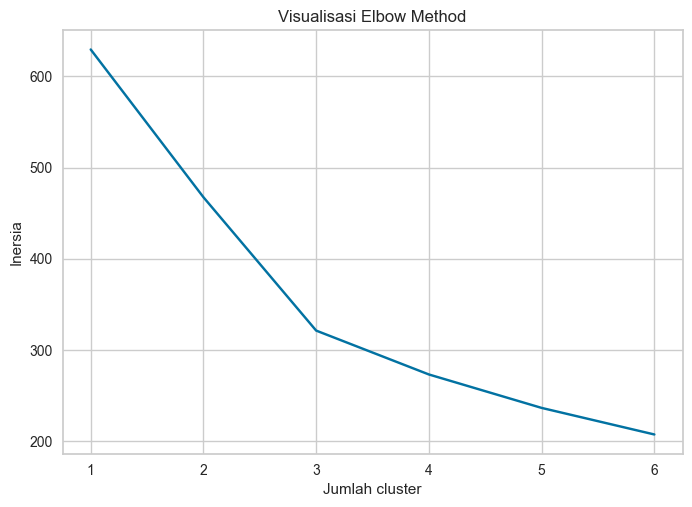

In [308]:
inertia = []
cluster_range = range(1, 7)

for cluster in cluster_range:
    km = KMeans(n_clusters=cluster, n_init=10, random_state=42)
    km = km.fit(df_selected)
    inertia.append(km.inertia_)

plt.plot(cluster_range, inertia, 'bx-')
plt.xlabel('Jumlah cluster')
plt.ylabel('Inersia')
plt.title('Visualisasi Elbow Method')

plt.show()

Dipilih 3 cluster karena panjang antar cluster tidak terlalu jauh berdasarkan silhouette coefficient. Selain itu, titik belok berada pada k=3 pada elbow method sehingga k=3 adalah nilai cluster yang optimal.

In [309]:
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
cluster_assignment = kmeans.fit_predict(df_selected)

In [310]:
# Buat dataframe baru dengan hasil cluster
df_with_clusters = pd.DataFrame(df_selected.copy())
df_with_clusters['cluster'] = cluster_assignment
df_with_clusters.head()

MonthlyIncome  TrainingTimesLastYear  PerformanceRating  cluster
0       0.488549               0.571429                0.5        2
1       0.602610               0.285714                0.5        0
2       0.446602               0.428571                0.5        2
3       0.465529               0.428571                0.5        2
4       0.546952               0.571429                0.5        2

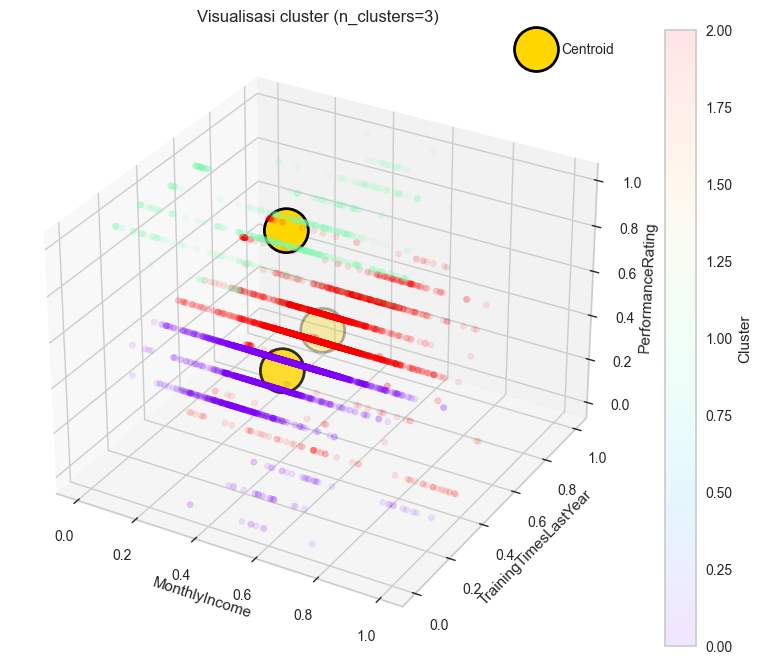

In [311]:
# Visualisasi 3D
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection="3d")

# Optional: adjust view angle
# ax.view_init(elev=0, azim=0)

# Axis assignments
x = df_with_clusters["MonthlyIncome"]             # x-axis
y = df_with_clusters["TrainingTimesLastYear"]     # y-axis
z = df_with_clusters["PerformanceRating"]         # z-axis
cluster = df_with_clusters['cluster']

# Visualisasi hasil clustering
sc = ax.scatter(x, y, z, c=cluster, cmap="rainbow", alpha=0.1)

# Tambah centroid dengan urutan sumbu yang sesuai
centroids = kmeans.cluster_centers_
ax.scatter(
    centroids[:, df_with_clusters.columns.get_loc("MonthlyIncome")],
    centroids[:, df_with_clusters.columns.get_loc("TrainingTimesLastYear")],
    centroids[:, df_with_clusters.columns.get_loc("PerformanceRating")],
    c='gold', s=1000, marker='o', edgecolor='black', linewidth=2, label='Centroid'
)

# Set axis labels secara eksplisit
ax.set_xlabel("MonthlyIncome")            # x-axis
ax.set_ylabel("TrainingTimesLastYear")    # y-axis
ax.set_zlabel("PerformanceRating")        # z-axis

plt.title("Visualisasi cluster (n_clusters=3)")
plt.colorbar(sc, label='Cluster')
plt.legend()
plt.show()


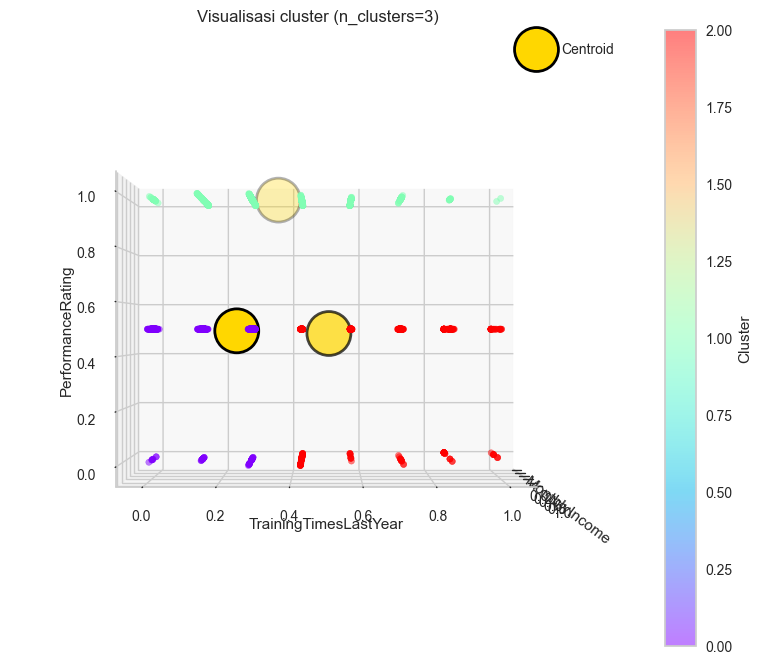

In [312]:
# Visualisasi 3D
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection="3d")

# Atur sudut pandang (opsional)
ax.view_init(elev=0, azim=0)

# Variabel untuk visualisasi
x = df_with_clusters["MonthlyIncome"]             # x-axis (horizontal)
y = df_with_clusters["TrainingTimesLastYear"]     # y-axis (vertical)
z = df_with_clusters["PerformanceRating"]         # z-axis (depth)
cluster = df_with_clusters['cluster']

# Visualisasi hasil clustering
sc = ax.scatter(x, y, z, c=cluster, cmap="rainbow", alpha=0.5)

# Tambahkan centroid dengan urutan yang sesuai dengan sumbu
centroids = kmeans.cluster_centers_
ax.scatter(
    centroids[:, df_with_clusters.columns.get_loc("MonthlyIncome")],
    centroids[:, df_with_clusters.columns.get_loc("TrainingTimesLastYear")],
    centroids[:, df_with_clusters.columns.get_loc("PerformanceRating")],
    c='gold', s=1000, marker='o', edgecolor='black', linewidth=2, label='Centroid'
)

# Label sumbu secara eksplisit
ax.set_xlabel("MonthlyIncome")             # x-axis
ax.set_ylabel("TrainingTimesLastYear")     # y-axis
ax.set_zlabel("PerformanceRating")         # z-axis

plt.title("Visualisasi cluster (n_clusters=3)")
plt.colorbar(sc, label='Cluster')
plt.legend()
plt.show()


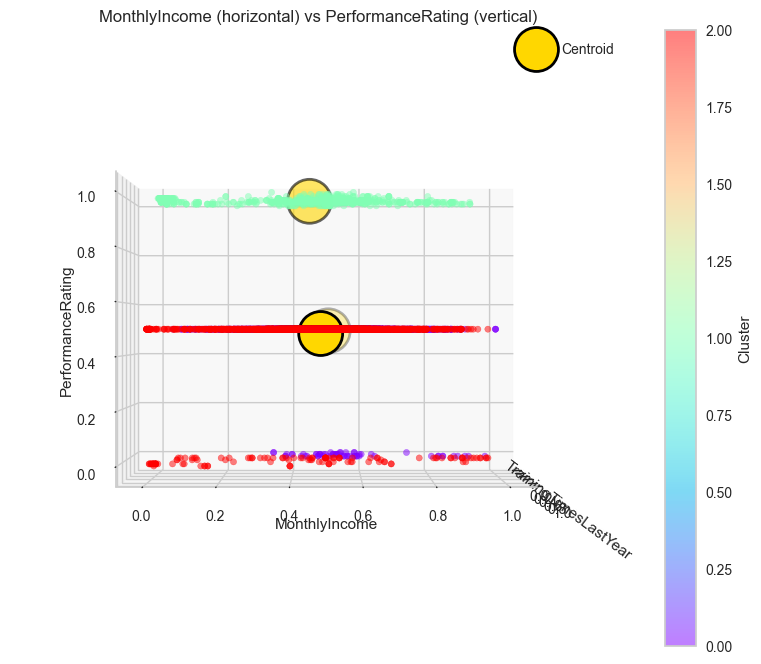

In [313]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection="3d")

ax.view_init(elev=0, azim=0)  # Optional: adjust view angle

# Set desired axes: horizontal (x) = TrainingTimesLastYear, vertical (y) = MonthlyIncome
x = df_with_clusters["TrainingTimesLastYear"]  # horizontal
y = df_with_clusters["MonthlyIncome"]          # vertical
z = df_with_clusters["PerformanceRating"]      # depth
cluster = df_with_clusters["cluster"]

sc = ax.scatter(x, y, z, c=cluster, cmap="rainbow", alpha=0.5)

# Centroids
centroids = kmeans.cluster_centers_
ax.scatter(
    centroids[:, df_with_clusters.columns.get_loc("TrainingTimesLastYear")],
    centroids[:, df_with_clusters.columns.get_loc("MonthlyIncome")],
    centroids[:, df_with_clusters.columns.get_loc("PerformanceRating")],
    c='gold', s=1000, marker='o', edgecolor='black', linewidth=2, label='Centroid'
)

# Correct axis labels
ax.set_xlabel("TrainingTimesLastYear")   # x-axis (horizontal)
ax.set_ylabel("MonthlyIncome")           # y-axis (vertical)
ax.set_zlabel("PerformanceRating")       # z-axis (depth)

plt.title("MonthlyIncome (horizontal) vs PerformanceRating (vertical)")
plt.colorbar(sc, label="Cluster")
plt.legend()
plt.show()


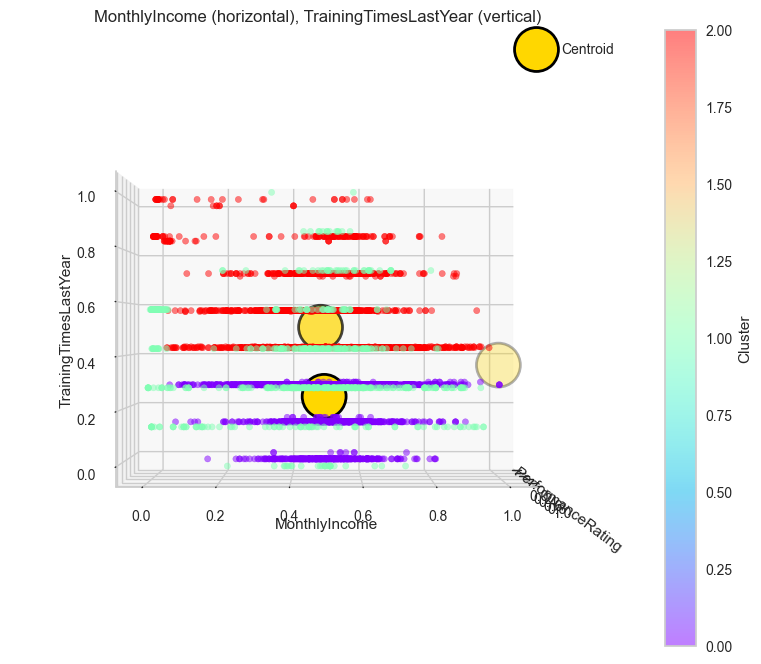

In [314]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection="3d")

ax.view_init(elev=0, azim=0)

x = df_with_clusters["PerformanceRating"]
y = df_with_clusters['MonthlyIncome']
z = df_with_clusters['TrainingTimesLastYear']
cluster = df_with_clusters['cluster']

sc = ax.scatter(x, y, z, c=cluster, cmap="rainbow", alpha=0.5)

# Centroids
ax.scatter(
    centroids[:, 0], centroids[:, 2], centroids[:, 1],
    c='gold', s=1000, marker='o', edgecolor='black', linewidth=2, label='Centroid'
)

# Correct axis labels to match actual axes
ax.set_xlabel("PerformanceRating")          # Horizontal (x)
ax.set_ylabel("MonthlyIncome")              # Vertical (y)
ax.set_zlabel("TrainingTimesLastYear")      # Depth (z)

plt.title("MonthlyIncome (horizontal), TrainingTimesLastYear (vertical)")
plt.colorbar(sc, label='Cluster')
plt.legend()
plt.show()


In [315]:
df_original['cluster'] = df_with_clusters['cluster']

In [316]:
# Select only numeric columns
numeric_cols = df_original.select_dtypes(include='number').columns

# Group by 'cluster' and compute the mean
mean_stats = df_original.groupby('cluster')[numeric_cols].mean()

# Transpose the result to display clusters as columns and features as rows
mean_stats_vertical = mean_stats.T

# Display results
mean_stats_vertical


cluster                              0             1             2
Age                          35.364747     33.087879     35.922006
BusinessTravel                1.232187      0.939394      1.196936
Department                    1.054267      1.056061      1.104735
DistanceFromHome              9.389395      8.159091      8.807242
Education                     1.681027      1.789394      1.665181
EducationField                2.756628      3.019697      2.820891
EnvironmentSatisfaction       1.481980      1.704545      1.576045
Gender                        0.618061      0.415152      0.600557
JobInvolvement                1.443869      1.712121      1.494986
JobLevel                      1.808409      1.742424      1.801950
JobRole                       4.236744      4.312121      4.327577
JobSatisfaction               1.402237      1.565152      1.500836
MaritalStatus                 0.845899      1.083333      0.884958
NumCompaniesWorked            2.433927      2.637879      2.318663
OverTime                      0.167978      0.421212      0.145961
PercentSalaryHike            14.408036     21.751515     14.275487
PerformanceRating             0.987365      2.000000      0.966574
RelationshipSatisfaction      1.459196      1.584848      1.583565
StandardHours                80.000000     80.000000     80.000000
StockOptionLevel              0.517813      0.618182      0.565738
TotalWorkingYears             9.667564      8.568182      9.782730
TrainingTimesLastYear         1.688691      2.525758      3.552368
WorkLifeBalance               1.295153      1.277273      1.344011
YearsAtCompany                5.803645      5.310606      5.950418
YearsInCurrentRole            3.587614      3.422727      3.511978
YearsSinceLastPromotion       1.669221      1.701515      1.669638
YearsWithCurrManager          3.421707      3.136364      3.347354
MonthlyIncome             14495.736208  13269.908136  14007.311546
Attrition                     0.196562      0.204545      0.192479
cluster                       0.000000      1.000000      2.000000

Berikut adalah hasil analisis saya terkait cluster yang dibentuk algoritma K-means:

Klaster 0 ditandai dengan Pendapatan Bulanan rata-rata sebesar $14.495, Jumlah Pelatihan Tahun Lalu yang relatif rendah (1,69), dan Rating Kinerja yang di bawah rata-rata (0,99). Kelompok ini tampaknya terdiri dari karyawan yang stabil dengan pengalaman kerja cukup lama (rata-rata 9,67 tahun), namun kurang mendapatkan pelatihan tambahan, yang mungkin berkontribusi pada kinerja yang tidak menonjol. Tingkat lembur yang rendah (0,17) juga menunjukkan keterlibatan yang tidak terlalu intensif dalam pekerjaan, kemungkinan karena karyawan ini menempati jabatan yang relatif senior dengan pendapatan lebih tinggi dibandingkan klaster lain, sehingga mereka mungkin kurang termotivasi untuk bekerja ekstra.

Klaster 1 memiliki Pendapatan Bulanan yang sedikit lebih rendah ($13.270), tetapi menonjol dengan Jumlah Pelatihan Tahun Lalu yang lebih tinggi (2,53) dan Rating Kinerja yang sangat baik (2,0). Karyawan di klaster ini cenderung lebih muda (usia rata-rata 33,09 tahun) dan menunjukkan keterlibatan tinggi, terlihat dari tingkat lembur yang signifikan (0,42) serta kenaikan gaji yang besar (21,75%). Hal ini mengindikasikan bahwa klaster ini terdiri dari karyawan muda yang ambisius dan termotivasi, yang memanfaatkan pelatihan untuk meningkatkan kinerja mereka, menjadikan mereka kelompok paling produktif di antara ketiga klaster.

Klaster 2 menunjukkan Pendapatan Bulanan rata-rata sebesar $14.007, dengan Jumlah Pelatihan Tahun Lalu yang paling tinggi (3,55), namun Rating Kinerja tetap rendah (0,97). Meskipun karyawan di klaster ini menerima pelatihan terbanyak dan memiliki pengalaman kerja yang panjang (rata-rata 9,78 tahun), kinerja mereka tidak meningkat secara signifikan, ditunjukkan oleh tingkat lembur yang sangat rendah (0,15). Kondisi ini menunjukkan penurunan motivasi, yang mungkin disebabkan oleh pelatihan yang kurang relevan atau efektif, atau karena masa kerja yang lama membuat mereka kehilangan semangat, berbeda dengan klaster 1 yang memiliki masa kerja lebih pendek (rata-rata 8,57 tahun) dan kinerja lebih tinggi.

In [317]:
# Reverse the label encoding using default_mappings
for col, categories in default_mappings.items():
    if col in df_original.columns:
        reverse_mapping = {idx: label for idx, label in enumerate(categories)}
        df_original[col] = df_original[col].map(reverse_mapping)

In [318]:
# Select only categorical columns
categorical_cols = df_original.select_dtypes(include=['object', 'category']).columns

# Initialize an empty DataFrame to store the mode per cluster
mode_stats = pd.DataFrame()

# Calculate mode per cluster for each categorical column
for cluster in df_original['cluster'].unique():
    cluster_data = df_original[df_original['cluster'] == cluster][categorical_cols]
    mode_values = cluster_data.mode().iloc[0]  # Take the first mode in case of ties
    mode_stats[cluster] = mode_values

# Transpose to display clusters as columns and features as rows
mode_stats_vertical = mode_stats

# Display result
mode_stats_vertical


2                       0  \
BusinessTravel                     Travel_Rarely           Travel_Rarely   
Department                Research & Development  Research & Development   
Education                               Bachelor                Bachelor   
EducationField                     Life Sciences           Life Sciences   
EnvironmentSatisfaction                     High                    High   
Gender                                      Male                    Male   
JobInvolvement                              High                    High   
JobRole                       Research Scientist      Research Scientist   
JobSatisfaction                             High                    High   
MaritalStatus                            Married                 Married   
OverTime                                      No                      No   
PerformanceRating                      Excellent               Excellent   
RelationshipSatisfaction                    High                    High   
WorkLifeBalance                           Better                  Better   
Attrition                                     No                      No   

                                               1  
BusinessTravel                     Travel_Rarely  
Department                Research & Development  
Education                               Bachelor  
EducationField                     Life Sciences  
EnvironmentSatisfaction                     High  
Gender                                    Female  
JobInvolvement                              High  
JobRole                       Research Scientist  
JobSatisfaction                        Very High  
MaritalStatus                            Married  
OverTime                                      No  
PerformanceRating                    Outstanding  
RelationshipSatisfaction                    High  
WorkLifeBalance                           Better  
Attrition                                     No

Apabila kita bandingkan perbedaan di antara masing-masing klaster, Klaster 1 menunjukkan perbedaan yang paling mencolok dibandingkan Klaster 0 dan Klaster 2, terutama dalam komposisi gender dan performa kerja. Mayoritas orang di Klaster 1 terdiri dari perempuan, dan mereka memiliki Rating Kinerja tertinggi, lebih baik dibandingkan Klaster 0 (Excellent) dan Klaster 2 (Excellent). Hal ini konsisten dengan analisis sebelumnya, di mana Klaster 1 memiliki Jumlah Pelatihan Tahun Lalu 2,53, usia lebih muda (33,09 tahun), tingkat lembur tinggi (0,42), dan kenaikan gaji besar (21,75%), mengindikasikan kelompok ini terdiri dari karyawan muda yang ambisius dan termotivasi. Keunggulan performa mereka bisa jadi disebabkan oleh kombinasi motivasi tinggi, pelatihan yang efektif, dan lingkungan kerja yang mendukung, ditambah dengan semangat kompetitif yang mungkin lebih menonjol di kalangan perempuan dalam klaster ini, yang mendorong mereka untuk mencapai hasil sangat baik.